In [ ]:
# in this file I build the transformer nesasery to change the data and create it aplicable for optuna

# Readmition predictor project - EDA
data: The Diabetes 130-US Hospitals for Years 1999 – 2008 from the UC Irvine ML Repository:
https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-200


## Predict the 30-day readmission rates for patients diagnosed with diabetes upon admission.
weusedgtthis article as our starting point for the data manipulation :
https://www.hindawi.com/journals/bmri/2014/781670/

# Working with data_transformer pipeline

start the code from 0. setup! 

# 0. setup

In [4]:
import data_transformers as dt
from sklearn.pipeline import Pipeline
from copy import deepcopy
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
from paths import DATA_PATH
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class SetEncounter(BaseEstimator, TransformerMixin):
    def __init__(self, ):

        self.name = "SetEncounter"
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['encounter'] = 'None'
        X.loc[(df.A1Cresult == '>7') | (X.A1Cresult == '>8'), 'encounter'] = '7_No'
        X.loc[((df.A1Cresult == '>7') | (X.A1Cresult == '>8')) & (X.change == 'Ch'), 'encounter'] = '7_Ch'
        X.loc[df.A1Cresult == 'Norm', 'encounter'] = 'Norm'
        X.drop(columns=['A1Cresult', 'change'], inplace=True)
        return X
    

In [6]:
import os
import pandas as pd
import datetime
from os import listdir
from os.path import isfile, join
import glob
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm
# Force printing all the variables in each cell, not just the last one: 
InteractiveShell.ast_node_interactivity = "all"


# plot count with percent
def plot_categorical_with_percent(data, column, **kwargs):
    total_count = len(data[column])
    ax = sns.countplot(data=data, x=column, order=data[column].value_counts().index, **kwargs)
    plt.title(f'Count Plot for {column}')
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height() / total_count)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 0.01 * total_count  # Adjust the vertical position of the text
        ax.annotate(percentage, (x, y), ha='center')
    return ax



def plot_dual_plot(x, data, hue, palette):
    # Calculate the order of bars by counts
    order = data[x].value_counts().index

    # Create subplots
    f, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot countplot on the first subplot
    sns.countplot(x=x, data=data, hue=hue, order=order, palette=palette, ax=axes[0])

    # Plot percentplot on the second subplot
    prop_df = (data[x]
               .groupby(data[hue])
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())

    g = sns.barplot(x=x, y='percentage', hue=hue, data=prop_df, ax=axes[1], palette=palette, order=order)

    # Place legend beneath both plots
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=len(pd.unique(data[x])))
    axes[1].get_legend().remove()  # Remove legend from the second plot

    # Add percentage labels to the bars in the countplot
    for p in g.patches:
        txt = str(np.round(p.get_height(), decimals=2)) + '%'
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = p.get_height()
        g.annotate(txt, (txt_x, txt_y), ha='center', va='bottom')

    # Show the plots
    plt.show()

# 0.1 read the data 

The dataset covers 10 years (1998-2008) of diabetes patient data gathered from 130 US hospitals having 70,000 distinct patients. Every record was labelled as to whether the patient was readmitted within 30 days, readmitted after 30 days, or not readmitted at all. 


"In this project, we are using the data_transformers library to manipulate our datafram

to save all data changes we are using prop_setter that log our changes."

In [7]:
prop_setter = dt.PropertySetter()

## List of features and their descriptions in the initial dataset (the dataset is also available at the website of Data Mining and Biomedical Informatics Lab at VCU

https://www.hindawi.com/journals/bmri/2014/781670/tab1/


The data contains sorten coloumns that uses ID:

ID list:
admission_type_id	
1	Emergency
2	Urgent
3	Elective
4	Newborn
5	Not Available
6	NULL
7	Trauma Center
8	Not Mapped
	
discharge_dispoescription
1	Discharged to home
2	Discharged/transferred to another short term hospital
3	Discharged/transferred to SNF
4	Discharged/transferred to ICF
5	Discharged/transferred to another type of inpatient care institution
6	Discharged/transferred to home with home health service
7	Left AMA
8	Discharged/transferred to home under care of Home IV provider
9	Admitted as an inpatient to this hospital
10	Neonate discharged to another hospital for neonatal aftercare
11	Expired
12	Still patient or expected to return for outpatient services
13	Hospice / home
14	Hospice / medical facility
15	Discharged/transferred within this institution to Medicare approved swing bed
16	Discharged/transferred/referred another institution for outpatient services
17	Discharged/transferred/referred to this institution for outpatient services
18	NULL
19	Expired at home. Medicaid only, hospice.
20	Expired in a medical facility. Medicaid only, hospice.
21	Expired, place unknown. Medicaid only, hospice.
22	Discharged/transferred to another rehab fac including rehab units of a hospital .
23	Discharged/transferred to a long term care hospital.
24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25	Not Mapped
26	Unknown/Invalid
30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
27	Discharged/transferred to a federal health care facility.
28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29	Discharged/transferred to a Critical Access Hospital (CAH).
	
admission_source_id	description
1	 Physician Referral
2	Clinic Referral
3	HMO Referral
4	Transfer from a hospital
5	 Transfer from a Skilled Nursing Facility (SNF)
6	 Transfer from another health care facility
7	 Emergency Room
8	 Court/Law Enforcement
9	 Not Available
10	 Transfer from critial access hospital
11	Normal Delivery
12	 Premature Delivery
13	 Sick Baby
14	 Extramural Birth
15	Not Available
17	NULL
18	 Transfer From Another Home Health Agency
19	Readmission to Same Home Health Agency
20	 Not Mapped
21	Unknown/Invalid
22	 Transfer from hospital inpt/same fac reslt in a sep claim
23	 Born inside this hospital
24	 Born outside this hospital
25	 Transfer from Ambulatory Surgery Center
26	Transfer from Hospice



In [8]:
path_to_data = 'C://Users/dekel//Desktop//python-tutorials-AMLLS-20231218T140422Z-001//python-tutorials-AMLLS//Project//'
df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col=0)

In [7]:
prossesed_data = pd.read_csv('C://Users/dekel/Desktop/ml_project/240418/ml-2024/data/prepped/prepped_data 0c84a8 NonStandardized.csv', index_col=0)

## 1.1 Take a Quick Look at the Data Structure

In [8]:
df.head()
df.info()

patient_nbr             race  gender      age weight  \
encounter_id                                                         
2278392           8222157        Caucasian  Female   [0-10)      ?   
149190           55629189        Caucasian  Female  [10-20)      ?   
64410            86047875  AfricanAmerican  Female  [20-30)      ?   
500364           82442376        Caucasian    Male  [30-40)      ?   
16680            42519267        Caucasian    Male  [40-50)      ?   

              admission_type_id  discharge_disposition_id  \
encounter_id                                                
2278392                       6                        25   
149190                        1                         1   
64410                         1                         1   
500364                        1                         1   
16680                         1                         1   

              admission_source_id  time_in_hospital payer_code  ...  \
encounter_id                                                    ...   
2278392                         1                 1          ?  ...   
149190                          7                 3          ?  ...   
64410                           7                 2          ?  ...   
500364                          7                 2          ?  ...   
16680                           7                 1          ?  ...   

             citoglipton  insulin  glyburide-metformin  glipizide-metformin  \
encounter_id                                                                  
2278392               No       No                   No                   No   
149190                No       Up                   No                   No   
64410                 No       No                   No                   No   
500364                No       Up                   No                   No   
16680                 No   Steady                   No                   No   

              glimepiride-pioglitazone  metformin-rosiglitazone  \
encounter_id                                                      
2278392                             No                       No   
149190                              No                       No   
64410                               No                       No   
500364                              No                       No   
16680                               No                       No   

              metformin-pioglitazone change diabetesMed readmitted  
encounter_id                                                        
2278392                           No     No          No         NO  
149190                            No     Ch         Yes        >30  
64410                             No     No         Yes         NO  
500364                            No     Ch         Yes         NO  
16680                             No     Ch         Yes         NO  

[5 rows x 49 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  

looks like missing values are marked as "?" 
we are changing it to nan so we can use the df.info() function and see the real non-null count

In [9]:
replace_value_to_nan = dt.ReplaceValueToNan(value='?')
df = replace_value_to_nan.fit_transform(df)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  

# 0.2 label

We are going to use 'readmission' as our label in a binary classification problem. First, we need to understand how the 'readmitted' variable is distributed.


<Axes: title={'center': 'Count Plot for readmitted'}, xlabel='readmitted', ylabel='count'>

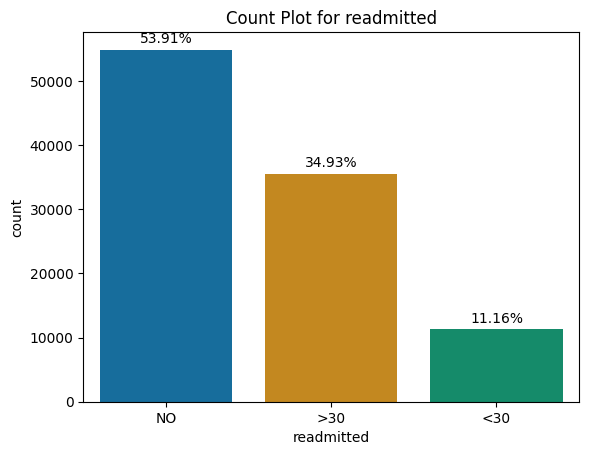

In [11]:
plot_categorical_with_percent(df, column="readmitted", palette="colorblind", hue="readmitted")

Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise,” which covers both readmission after 30 days and no readmission at all.

In [12]:
lookup_lable = {
            'YES': ['<30'],
            'NO': ['>30', 'NO']}
change_label = dt.CategoryReducer('readmitted', lookup_lable)
change_label.prop_setter = prop_setter
change_label = change_label._fit(df)
df = change_label.transform(df)

<Axes: title={'center': 'Count Plot for readmitted'}, xlabel='readmitted', ylabel='count'>

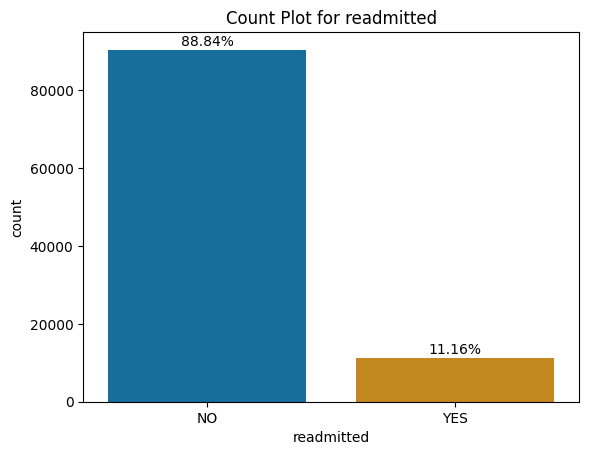

In [13]:
plot_categorical_with_percent(df, column="readmitted", palette="colorblind", hue="readmitted")

## Approximately 11% of the population experiences rehospitalization, indicating an imbalanced classification scenario.

Upon examining the 'IDs_mapping.csv' file provided by UCI, it is evident that IDs 11, 13, 14, 19, 20, and 21 are associated with death or hospice situations. Consequently, it is advisable to exclude these samples from the predictive model, as they do not apply to readmission scenarios.

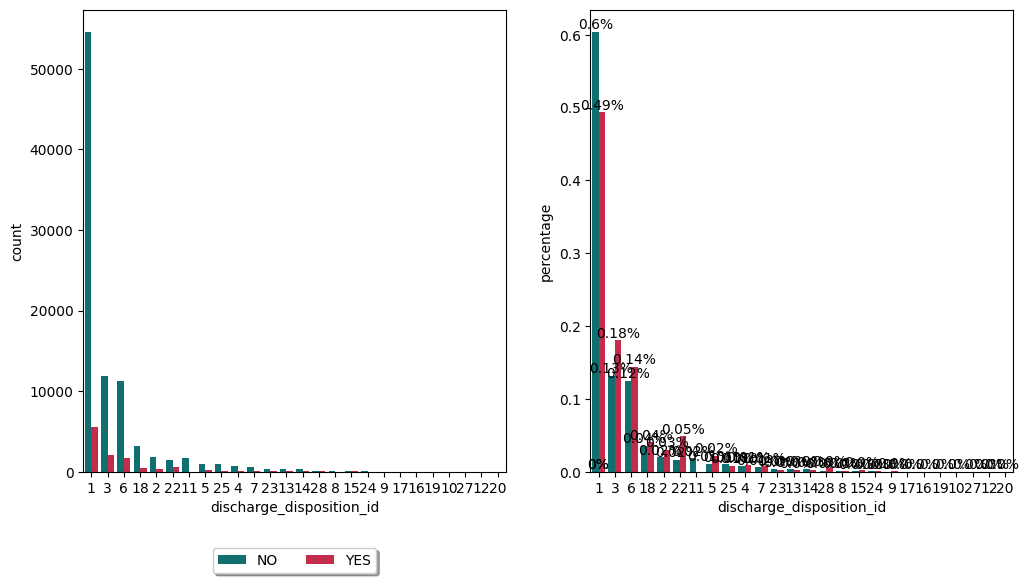

In [128]:
# removing discharge: 11, 13, 14, 19, 20, and 21
style = {'shrink': 0.9, 'hue': 'readmitted', 'discrete': True, 'element': 'bars', 'multiple': 'dodge', 'common_norm': False, 'palette': ["teal", "crimson"], 'stat': 'percent'}

hue = 'readmitted'
data=df
x = 'discharge_disposition_id'
palette = ["teal", "crimson"]

# sns.histplot( x=feature, data=df,  **style).set_title(f'feature: {feature}')
plot_dual_plot(x=x, data=data, hue=hue, palette=palette)

In [129]:
remove_rows = dt.RowRemoverByFeatureValue(feature='discharge_disposition_id', exclude_vals=[11,13,14,19,20,21])
df = remove_rows.fit_transform(df)

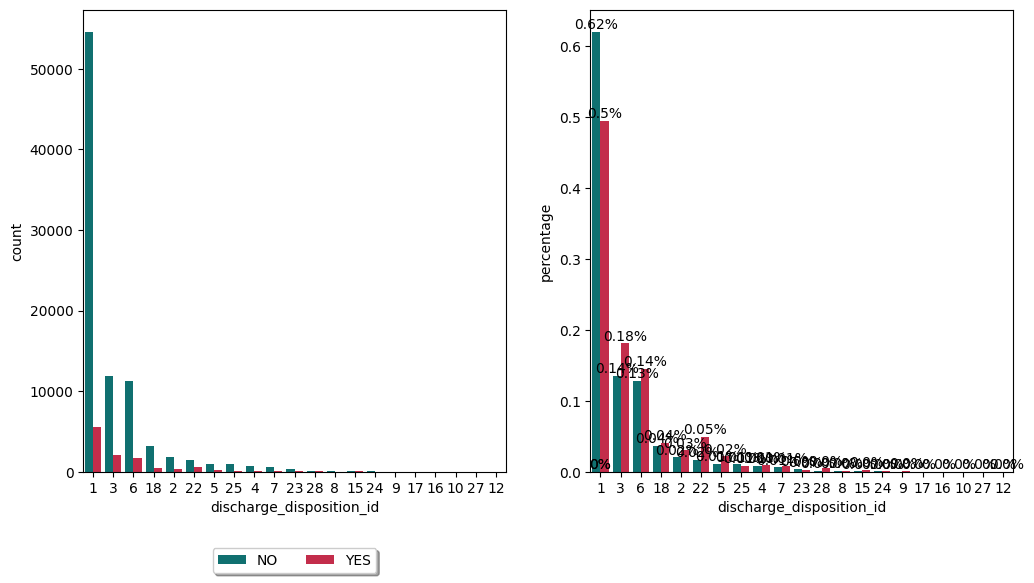

In [130]:
style = {'shrink': 0.9, 'hue': 'readmitted', 'discrete': True, 'element': 'bars', 'multiple': 'dodge', 'common_norm': False, 'palette': ["teal", "crimson"], 'stat': 'percent'}

hue = 'readmitted'
data=df
x = 'discharge_disposition_id'
palette = ["teal", "crimson"]

# sns.histplot( x=feature, data=df,  **style).set_title(f'feature: {feature}')
plot_dual_plot(x=x, data=data, hue=hue, palette=palette)

# 0.3  drop duplicates by patient_nbr:

we remove patients with more than one addmition


In [131]:
# remove_duplicates = dt.RowRemoverByDuplicates(feature='patient_nbr')
# df = remove_duplicates.transform(df)

# 1 deals with missing and bios values
We want to know which columns have missing values:

In [132]:
#  to evaluate how the missing value afect our data we want to see in what column we have 
# missing value and waht is the ratio

def calc_missing_percent(df):
    ''' calculate the number of nan values in coloumns with missing values 
     returns df with missing values info
     '''
    # Extract column-wise missing values
    missing_values = df.isnull().sum()
    # Calculate percentage of missing values for each column
    missing_percentage = missing_values[missing_values>0]/len(df) *100  
    return pd.DataFrame(missing_percentage, columns=['Percent of missing'])

# Print the DataFrame
calc_missing_percent(df)

Percent of missing
race                         2.248774
weight                      96.854333
payer_code                  39.658557
medical_specialty           48.937520
diag_1                       0.020132
diag_2                       0.358354
diag_3                       1.428384
max_glu_serum               94.813928
A1Cresult                   83.054669

The original database contains incomplete, redundant, and noisy information as expected in any real-world data. There were several features that could not be treated directly since they had a high percentage of missing values. These features are weight (97% values missing), payer code (40%), and medical specialty (49%). Weight attribute was considered to be too sparse and it was not included in further analysis. Payer code is removed since it had a high percentage of missing values and it was not considered relevant to the outcome. Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values.
In addition we added value 'missing' in 'race'column.
We will deel with the diag columns later 

In [133]:
df.drop(columns=['weight', 'payer_code'], inplace=True)
calc_missing_percent(df)

Percent of missing
race                         2.248774
medical_specialty           48.937520
diag_1                       0.020132
diag_2                       0.358354
diag_3                       1.428384
max_glu_serum               94.813928
A1Cresult                   83.054669

## 1.1 Remove Features with Low Variance

In some cases, dataframes may contain features biased towards one particular value. To gain a better understanding of our data, we would like to examine the ratio of the most common value for each feature. Therefore, we will plot the ratio of the most common value for all feature."

In [134]:
def unique_values_and_ratio(df):
    unique_counts = df.nunique()  # Number of unique values in each column
    
    most_common_ratios = ((df == df.mode().values).sum()/len(df))*100  # Ratio of most common value
   
    return  pd.DataFrame({"Unique Values": unique_counts, "Most Common Ratio": most_common_ratios})

unique = unique_values_and_ratio(df)
unique['above_95'] = unique['Most Common Ratio']>=95
unique[unique['above_95'] == True]

Unique Values  Most Common Ratio  above_95
repaglinide                           4          98.471961      True
nateglinide                           4          99.306443      True
chlorpropamide                        4          99.914438      True
acetohexamide                         2          99.998993      True
tolbutamide                           2          99.978861      True
acarbose                              4          99.692983      True
miglitol                              4          99.961749      True
troglitazone                          2          99.996980      True
tolazamide                            3          99.960742      True
examide                               1         100.000000      True
citoglipton                           1         100.000000      True
glyburide-metformin                   4          99.297384      True
glipizide-metformin                   2          99.986914      True
glimepiride-pioglitazone              2          99.998993      True
metformin-rosiglitazone               2          99.997987      True
metformin-pioglitazone                2          99.998993      True

In [135]:
unique[unique['Most Common Ratio'] >= 100].index

Index(['examide', 'citoglipton'], dtype='object')

In [136]:
# We remove all features with one unique value, this features are not contribute
df.drop(columns=unique[unique['Unique Values']==1].index.to_list(), inplace=True)
unique.drop(index=unique[unique['Unique Values']==1].index.to_list(), inplace=True)

Text(0.5, 1.0, 'Number of high bias features')

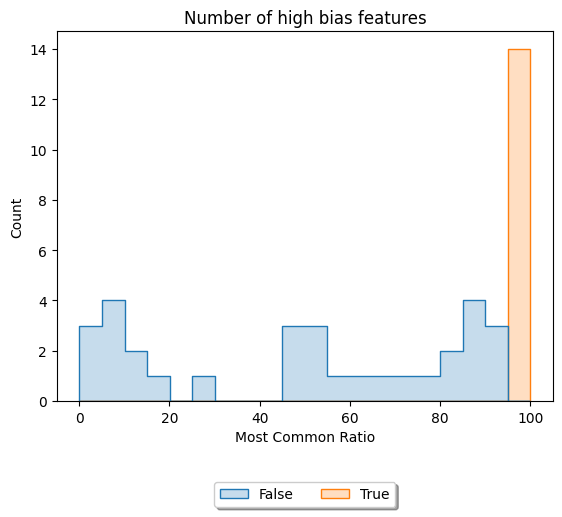

In [137]:
ax =sns.histplot(data=unique, x='Most Common Ratio', element='step',hue='above_95', bins=20)
sns.move_legend(
        ax, "upper center",
        bbox_to_anchor=(0.5, -0.2), ncol=4, title=None, fancybox=True, shadow=True)
ax.set_title(label='Number of high bias features')

14 features have a high bias to one value,
Let's first understand what the feature stands for, and what  the values are:

Text(0.5, 1.0, 'feature: repaglinide')

Text(0.5, 1.0, 'feature: nateglinide')

Text(0.5, 1.0, 'feature: chlorpropamide')

Text(0.5, 1.0, 'feature: acetohexamide')

Text(0.5, 1.0, 'feature: tolbutamide')

Text(0.5, 1.0, 'feature: acarbose')

Text(0.5, 1.0, 'feature: miglitol')

Text(0.5, 1.0, 'feature: troglitazone')

Text(0.5, 1.0, 'feature: tolazamide')

Text(0.5, 1.0, 'feature: glyburide-metformin')

Text(0.5, 1.0, 'feature: glipizide-metformin')

Text(0.5, 1.0, 'feature: glimepiride-pioglitazone')

Text(0.5, 1.0, 'feature: metformin-rosiglitazone')

Text(0.5, 1.0, 'feature: metformin-pioglitazone')

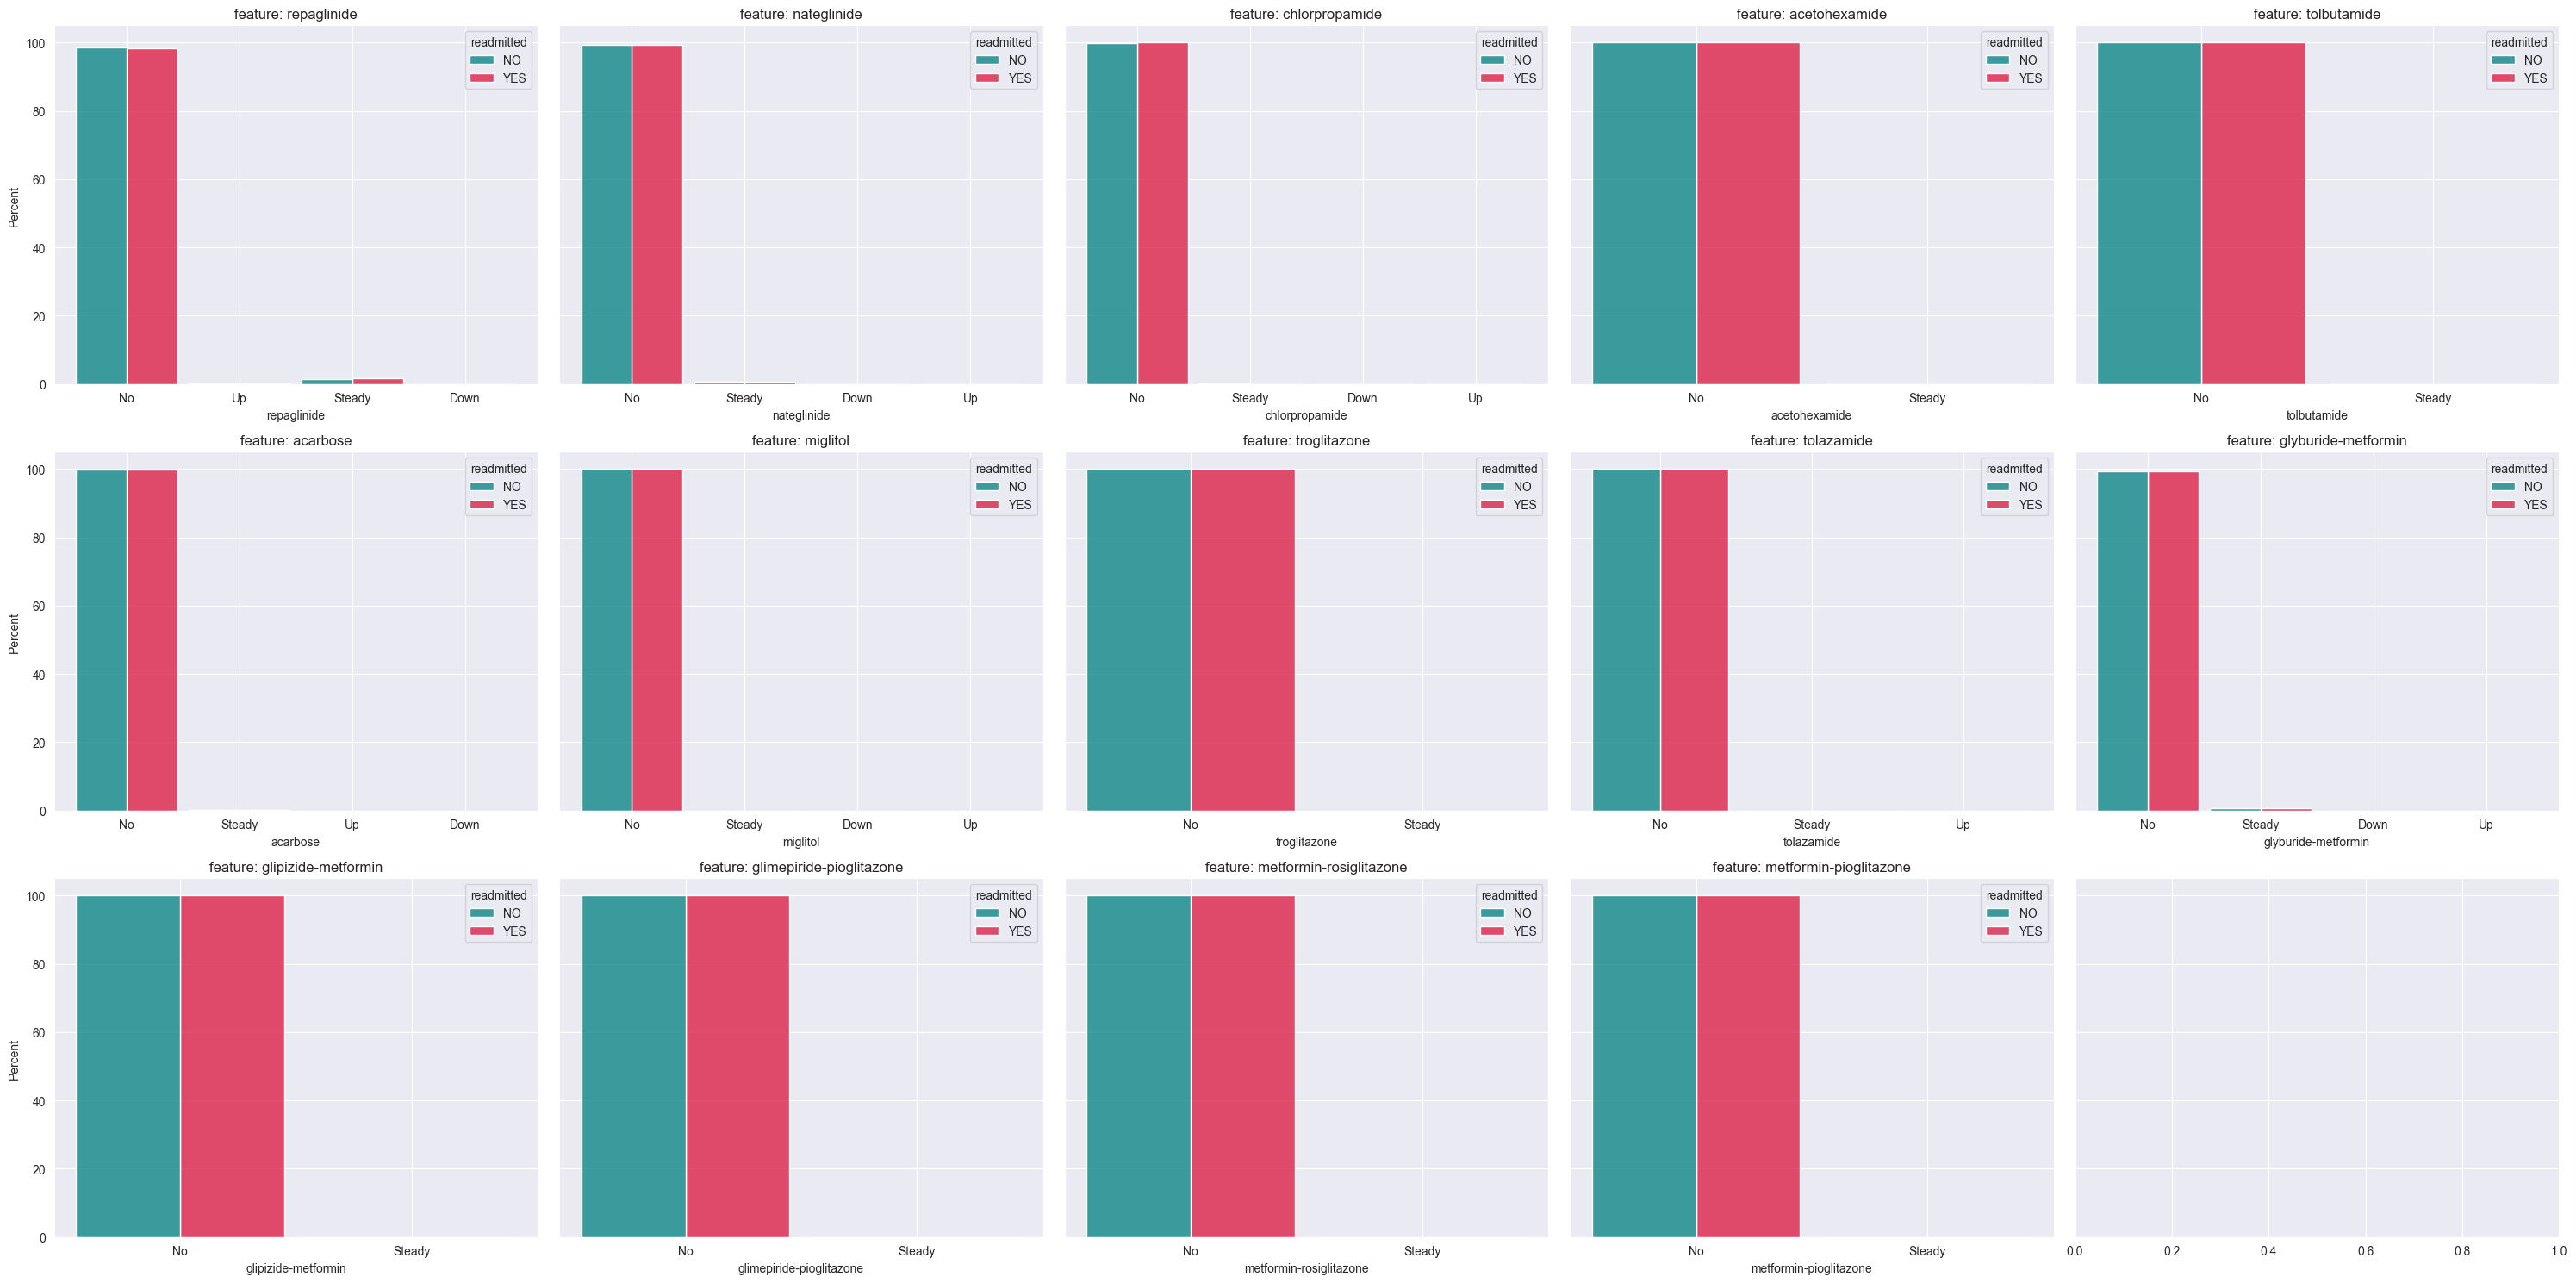

In [138]:
sns.set_style('darkgrid')
style = {'shrink': 0.9, 'hue': 'readmitted', 'discrete': True, 'element': 'bars', 'multiple': 'dodge', 'common_norm': False, 'palette': ["teal", "crimson"], 'stat': 'percent'}

features_with_low_bias = unique[unique['above_95'] == True].index
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15), sharey=True)
axes = axes.flatten()
for i, feature in enumerate(features_with_low_bias):
    sns.histplot( x=feature, data=df, ax=axes[i],  **style).set_title(f'feature: {feature}')

fig.tight_layout()
plt.show()

To understand the health-relevant of these features lets go over them and see if it is important and if there is a way to group them.

1. Repaglinide: A medication used to treat type 2 diabetes by helping the pancreas produce insulin.
2. Nateglinide: r medication for type 2 diabetes,that  stimulaesg insulin release from pancreatic beta cells.
3. Chlorpropamide: An oral antidiabetic drug that stimulates insulin release from pancreatic beta cells.
4. Acetohexamide: A sulfonylurea medication used to manage type 2 diabetes by stimulating insulin secretion.
5. Tolbutamide: A first-generation sulfonylurea drug that increases insulin release from pancreatic beta cells.
6. Acarbose: An alpha-glucosidase inhibitor used to treat type 2 diabetes by slowing carbohydrate digestion.
7. Miglitol: Another alpha-glucosidase inhibitor for type 2 diabetes, reducing postprandial blood glucose le8els.
8. Troglitazone: A former medication for type 2 diabetes, part of the thiazolidinedione class, withdrawn due to safety con9erns.
9. Tolazamide: A sulfonylurea medication that stimulates insulin release, used in managing type 2 di10etes.
10. It is used for the treatment of EDEMA associated with CONGESTIVE HEART FAILURE; CHRONIC RENAL INSUFFICIENCY; and LIVER DISEASES.  c11older.
11. Citoglipton: Not a recognized medication; could be a typo or pla12holder.
12. Glyburide-metformin: A combination medication for type 2 diabetes, containing both glyburide (a sulfonylurea) and 13tformin.
13. Glipizide-metformin: Another combination drug for type 2 diabetes, containing glipizide (a sulfonylurea) and14etformin.
14. Glimepiride-pioglitazone: A combination medication for type 2 diabetes, consisting of glimepiride (a sulfonylurea) and pioglitazone (a thiazol15inedione).
15. Metformin-rosiglitazone: A combination drug for type 2 diabetes, combining metformin (a biguanide) with rosiglitazone (a thiazo16dinedione).
16. Metformin-pioglitazone: A combination medication for type 2 diabetes, including metformin (a biguanide) and pioglitazone (a thiazball are known diabetes 2 drugs
let's look at our data, and see if we can find more diabetes 2 drugs and if we can group them by drug type


In [389]:
# We are using biased data and setting a new threshold of 70
unique['above_70'] = unique['Most Common Ratio']>=70
unique[(unique['above_70'] == True) & (unique['above_95'] != True)].index

Index(['race', 'number_outpatient', 'number_emergency', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'diabetesMed', 'readmitted'],
      dtype='object')

We found more drugs: 'metformin','glimepiride', 'glipizide', 'glyburide', 'pioglitazone','rosiglitazone', 'diabetesMed'

The logical connection among drugs within each group in the drugs_dict dictionary is their pharmacological mechanism or therapeutic class, which determines their primary mode of action and clinical indication in the treatment of diabetes mellitus.r
Here's how the drugs are logically connected within each group:
1. 
Biguanides and Related: This group contains drugs such as metformin, which are commonly used as oral antidiabetic agents. They primarily work by decreasing hepatic glucose production and increasing peripheral insulin sensitivity

2. .
Sulfonylureas and Meglitinides: Drugs in this group, such as glimepiride and glyburide, are insulin secretagogues that stimulate insulin release from pancreatic beta cells. They are commonly used to lower blood glucose levels in patients with type 2 diabete

3. s.
Thiazolidinediones and Miscellaneous: This category includes drugs like pioglitazone and rosiglitazone, which are thiazolidinediones that improve insulin sensitivity in peripheral tissues. Other drugs in this category, such as acarbose and miglitol, work by inhibiting carbohydrate digestion and absorption in the gastrointestinal tr acdrugs_dict = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "glipizide-metformin", "metformin-pioglitazone"]
}






apy ise
  - Examide
  - Cit

We are counting the number of non "No" value in each group and seting a new numerical feature with the number of drugs in that drug grouphat the distribution looks like:

In [390]:
class DataTransformer(BaseEstimator, TransformerMixin):

    def fit(self, *args):
        return self

    @property
    def name(self):
        name = self.__class__.__name__
        for attr in ['feature', 'method']:
            if hasattr(self, attr):
                name += f"[{getattr(self, attr)}]"
        return name

In [391]:
from itertools import chain
class DataTransformer(BaseEstimator, TransformerMixin):

    def fit(self, *args):
        return self

    @property
    def name(self):
        name = self.__class__.__name__
        for attr in ['feature', 'method']:
            if hasattr(self, attr):
                name += f"[{getattr(self, attr)}]"
        return name

class GroupFeatures(DataTransformer):
    ''' using np.sum(eval(f'df[drugs_dict[key]] {sel.operator} self.group_term'), axis=1) to group features'''

    def __init__(self, features: dict, group_term='No', operator = '!='):
        self.features = features
        self.new_features = features.keys()
        self.old_features = list(chain.from_iterable(features.values()))
        self.group_df = pd.DataFrame()
        self.group_term = group_term
        self.operator = operator


    def fit(self, X):
        for key in self.features.keys():
            self.group_df[key] = np.sum(eval(f'X[drugs_dict[key]] {self.operator} self.group_term'), axis=1) 
                
    def transform(self, X):
        X.drop(columns=self.old_features, inplace=True)
        return pd.concat([X,self.group_df], axis=1)


class SumFeatures(DataTransformer):
    ''''''

    def __init__(self, features: list, new_feature_name,  group_term='0', operator = '>'):
        self.features = features
        self.result = None
        self.new_feature_name = new_feature_name
        self.group_term = group_term
        self.operator = operator

    def fit(self, X):
        if ((self.group_term != None) & (self.operator != None)):
             self.result = np.sum(eval(f'X[self.features] {self.operator} {self.group_term}'), axis=1)
        else:    
            self.result = np.sum(X[self.features], axis=1)
                
    def transform(self, X):
        X[self.new_feature_name] = self.result
        return X

In [387]:
# this is moving part, here I create the moudle 
# import section

from sklearn.base import BaseEstimator, TransformerMixin


class ChangeValueToValue(BaseEstimator, TransformerMixin):
    # change value in DataFrame to another value not feature dependent
    def __init__(self, value_from: str | int , value_to: str | int, **kwargs) -> df:
        self.value_from = value_from
        self.value_to = value_to

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = deepcopy(X)
        data[data == self.value_from] = self.value_to
        return data




class CategoryReducer(BaseEstimator, TransformerMixin):
    # reduse all features in the dict based on lookup dict
    def __init__(self, lookup: dict[str: dict[str: list]], **kwargs):
        self.lookup = lookup
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = deepcopy(X)
        for feature, feature_lookup in self.lookup.items():
            for change_to, change_from_list in feature_lookup.items():
                data.loc[data[feature].isin(change_from_list), feature] = change_to

            if not 'other' in feature_lookup.keys():
                result_list = []
                data.loc[~data[feature].isin(feature_lookup.keys()), feature] = 'other'  
        return data


class DropRowsByValue(BaseEstimator, TransformerMixin):
    # drop rows from df based on values in features. this function gets lookup dict and go over all features
    def __init__(self, lookup: dict[str: list], inplace=True, **kwargs):
        self.lookup = lookup
        self.inplace = inplace
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data=deepcopy(X)
        for feature, value_to_drop in self.lookup.items():
            data.drop(index=data[feature].isin(value_to_drop).index, inplace=self.inplace)
        return data


class DropColByValue(BaseEstimator, TransformerMixin):
    # Drop columns from df based on values in features. this function gets lookup list 
    def __init__(self, lookup: list, inplace=True, **kwargs):
        self.lookup = lookup
        self.inplace = inplace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = deepcopy(X)
        data.drop(columns=self.lookup, inplace=self.inplace)
        return data


class DropColWithLowVarious(BaseEstimator, TransformerMixin):
    # Drop columns  based on various this class need to be fitted to the train data 
    def __init__(self, various_threshold: int=100, inplace=True,  **kwargs):
        self.various_threshold = various_threshold
        self.columns_to_drop = []
        self.inplace = inplace
        
    def unique_values_and_ratio(self, X):
        unique_counts = X.nunique()  # Number of unique values in each column
        most_common_ratios = ((X == X.mode().values).sum()/len(X))*100  # Ratio of most common value
        self.common_ratio_df = pd.DataFrame({"Unique Values": unique_counts, "Most Common Ratio": most_common_ratios})

    def fit(self, X, y=None):
        self.unique_values_and_ratio(X)
        self.columns_to_drop = self.common_ratio_df[self.common_ratio_df['Most Common Ratio'] >= self.various_threshold].index
        return self

    def transform(self, X):
        data = deepcopy(X)
        data.drop(columns=self.columns_to_drop, inplace=self.inplace)
        return data



class GroupCategoriesUsinValues(BaseEstimator, TransformerMixin):
    # Group multiple features into one feature based on a lookup dictionary
    def __init__(self, lookup: dict[str, list], mode: str='sum', inplace=True, **kwargs):
        self.lookup = lookup
        self.mode_str = mode
        self.mode = getattr(np, mode, np.sum)  # Dynamically select the mode function from numpy
        self.inplace = inplace
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data= deepcopy(X)
        for new_feature, old_features in self.lookup.items():
            data[new_feature] = self.mode(data[old_features], axis=1)
            data.drop(columns=old_features, inplace=self.inplace)
        return data



In [473]:
df = pd.read_csv(path_to_data + "diabetic_data.csv", index_col=0)

patient_nbr             race  gender      age  \
encounter_id                                                  
2278392           8222157        Caucasian  Female   [0-10)   
149190           55629189        Caucasian  Female  [10-20)   
64410            86047875  AfricanAmerican  Female  [20-30)   
500364           82442376        Caucasian    Male  [30-40)   
16680            42519267        Caucasian    Male  [40-50)   
...                   ...              ...     ...      ...   
443847548       100162476  AfricanAmerican    Male  [70-80)   
443847782        74694222  AfricanAmerican  Female  [80-90)   
443854148        41088789        Caucasian    Male  [70-80)   
443857166        31693671        Caucasian  Female  [80-90)   
443867222       175429310        Caucasian    Male  [70-80)   

              admission_type_id  discharge_disposition_id  \
encounter_id                                                
2278392                       6                        25   
149190                        1                         1   
64410                         1                         1   
500364                        1                         1   
16680                         1                         1   
...                         ...                       ...   
443847548                     1                         3   
443847782                     1                         4   
443854148                     1                         1   
443857166                     2                         3   
443867222                     1                         1   

              admission_source_id  time_in_hospital         medical_specialty  \
encounter_id                                                                    
2278392                         1                 1  Pediatrics-Endocrinology   
149190                          7                 3                   missing   
64410                           7                 2                   missing   
500364                          7                 2                   missing   
16680                           7                 1                   missing   
...                           ...               ...                       ...   
443847548                       7                 3                   missing   
443847782                       5                 5                   missing   
443854148                       7                 1                   missing   
443857166                       7                10           Surgery-General   
443867222                       7                 6                   missing   

              num_lab_procedures  ...  glimepiride-pioglitazone  \
encounter_id                      ...                             
2278392                       41  ...                         0   
149190                        59  ...                         0   
64410                         11  ...                         0   
500364                        44  ...                         0   
16680                         51  ...                         0   
...                          ...  ...                       ...   
443847548                     51  ...                         0   
443847782                     33  ...                         0   
443854148                     53  ...                         0   
443857166                     45  ...                         0   
443867222                     13  ...                         0   

              metformin-rosiglitazone  metformin-pioglitazone  change  \
encounter_id                                                            
2278392                             0                       0      No   
149190                              0                       0      Ch   
64410                               0                       0      No   
500364                              0                       0      Ch   
16680                               

Text(0.5, 1.0, 'feature: biguanides_and_related')

Text(0.5, 1.0, 'feature: sulfonylureas_and_meglitinides')

Text(0.5, 1.0, 'feature: thiazolidinediones_and_miscellaneous')

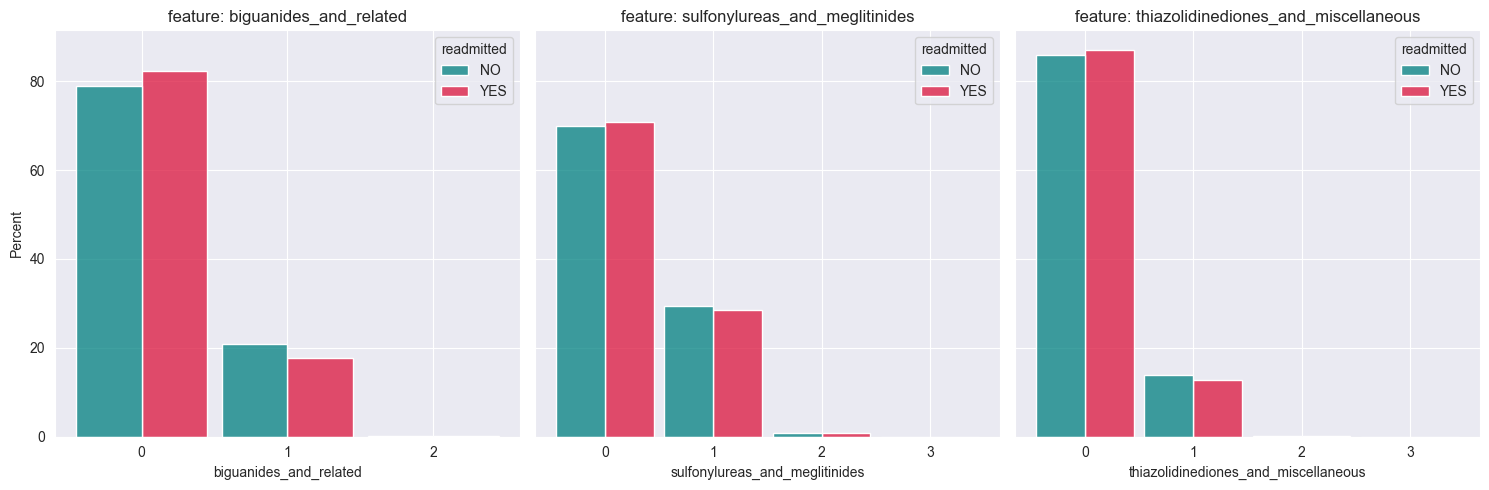

In [392]:
# from matplotlib.ticker import MaxNLocator
drugs_dict = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "glipizide-metformin", "metformin-pioglitazone"]
}
drug_types = ['biguanides_and_related', 'sulfonylureas_and_meglitinides', 'thiazolidinediones_and_miscellaneous']
# creating a new dataframe with the new grouping, adding the number of drug types as well, and the number of combinations between families of drugs
drug_df = pd.DataFrame()
for key in drugs_dict.keys():
    drug_df[key] = np.sum(df[drugs_dict[key]] != 'No', axis=1) 
# drug_df['No'] = np.sum(drug_df, axis=1) 

drug_df['number_diabetic_drugs'] = np.sum(drug_df, axis=1) 
drug_df['number_diabetic_famalies'] = np.sum(drug_df[drug_types]>0, axis=1)
drug_df['readmitted'] = df.readmitted

# 1. let's plot the distributions of the number of drugs from the same family patients get and split it by the readmission label, we would like to see if there is the medication type has a significant affect on the readmission.
# 2. Also we whant to see if a pationt gets a combination of different families of diabetic drugs has an effect on readmission

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
axes = axes.flatten()

for i, key in enumerate(drugs_dict.keys()):
    sns.histplot(data=drug_df.astype('category'), x=key, ax=axes[i], **style).set_title(f'feature: {key}')
    # sns.histplot(data=drug_df[drug_df['readmitted'] != 'readmitted'],element='step', x=key,color='crimson',  ax=axes[i], stat='percent', multiple='dodge').set_title(f'feature: {key}')
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    
fig.tight_layout()



we managed to improve the bias in our data by grouping the 22 categorical features into 3 numerical features of drug families.
instead of deleting the bias features we group them to get more informative information.

let's also see if combining drugs from different families has an afact on readmission

Text(0.5, 1.0, 'feature: number_diabetic_famalies')

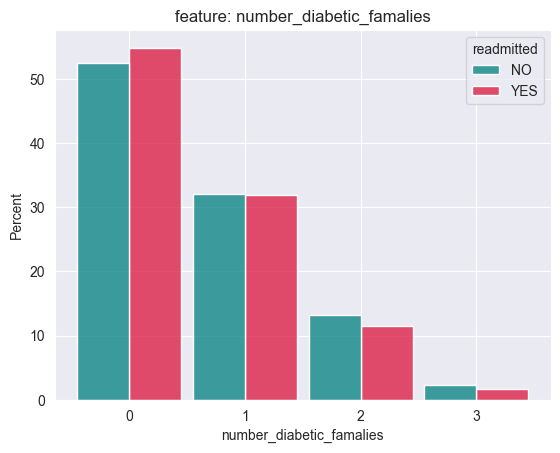

In [393]:
sns.histplot(data=drug_df.astype('category'), x='number_diabetic_famalies', **style).set_title('feature: number_diabetic_famalies')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

from the two plots we see:
from the first plot, we can see that biguanides, sulfonylureas and reduce the number of readmissions.t
from the second plot, it seems that usina g combination of drug families also recuse readmissiopw grouping




We see a anty-correlation between the number of drugs from different families and the readmission rawho patients that got drugs from two families were readmitted less. also we can see that most patiens got up to 3 the drug type:

In [394]:
group_features = GroupFeatures(features=drugs_dict)

In [395]:
group_features.fit(df)
df = group_features.transform(df)


In [396]:
sum_features = SumFeatures(list(group_features.new_features), new_feature_name='number_diabetic_famalies')

In [397]:
sum_features.fit(df)

In [398]:
# we also change our data
df = sum_features.transform(df)
# we have removed features with low data varians and changed it to numerical features with anticorrelation to readmission

In [399]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99343 entries, 0 to 99342
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   patient_nbr                           99343 non-null  int64 
 1   race                                  97109 non-null  object
 2   gender                                99343 non-null  object
 3   age                                   99343 non-null  object
 4   admission_type_id                     99343 non-null  int64 
 5   discharge_disposition_id              99343 non-null  int64 
 6   admission_source_id                   99343 non-null  int64 
 7   time_in_hospital                      99343 non-null  int64 
 8   medical_specialty                     50727 non-null  object
 9   num_lab_procedures                    99343 non-null  int64 
 10  num_procedures                        99343 non-null  int64 
 11  num_medications             

# 3. numeric features
Discover and Visualize the Data to Gain Insights

In [400]:
df.describe()

patient_nbr  admission_type_id  discharge_disposition_id  \
count  9.934300e+04       99343.000000              99343.000000   
mean   5.426117e+07           2.030259                  3.517882   
std    3.873426e+07           1.446373                  5.184359   
min    1.350000e+02           1.000000                  1.000000   
25%    2.338675e+07           1.000000                  1.000000   
50%    4.541774e+07           1.000000                  1.000000   
75%    8.756007e+07           3.000000                  3.000000   
max    1.895026e+08           8.000000                 28.000000   

       admission_source_id  time_in_hospital  num_lab_procedures  \
count         99343.000000      99343.000000        99343.000000   
mean              5.731083          4.379332           42.906929   
std               4.065029          2.968409           19.610032   
min               1.000000          1.000000            1.000000   
25%               1.000000          2.000000           31.000000   
50%               7.000000          4.000000           44.000000   
75%               7.000000          6.000000           57.000000   
max              25.000000         14.000000          132.000000   

       num_procedures  num_medications  number_outpatient  number_emergency  \
count    99343.000000     99343.000000       99343.000000      99343.000000   
mean         1.334236        15.979062           0.369246          0.198444   
std          1.702786         8.094909           1.265142          0.937734   
min          0.000000         1.000000           0.000000          0.000000   
25%          0.000000        10.000000           0.000000          0.000000   
50%          1.000000        15.000000           0.000000          0.000000   
75%          2.000000        20.000000           0.000000          0.000000   
max          6.000000        81.000000          42.000000         76.000000   

       number_inpatient  number_diagnoses  biguanides_and_related  \
count      99343.000000      99343.000000            99343.000000   
mean           0.630935          7.401709                0.206809   
std            1.260428          1.941013                0.406508   
min            0.000000          1.000000                0.000000   
25%            0.000000          6.000000                0.000000   
50%            0.000000          8.000000                0.000000   
75%            1.000000          9.000000                0.000000   
max           21.000000         16.000000                2.000000   

       sulfonylureas_and_meglitinides  thiazolidinediones_and_miscellaneous  \
count                    99343.000000                          99343.000000   
mean                         0.306916                              0.140503   
std                          0.477158                              0.351427   
min                          0.000000                              0.000000   
25%                          0.000000                              0.000000   
50%                          0.000000                              0.000000   
75%                          1.000000                              0.000000   
max                          3.000000                              3.000000   

       number_diabetic_famalies  
count              99343.000000  
mean                   0.644877  
std                    0.786637  
min                    0.000000  
25%                    0.000000  
50%                    0.000000  
75%                    1.000000  
max                    3.000000

admission_type_id, discharge_disposition_id, and admission_source_id are IDs and thus need to be changed to categorical, We will deal with them later patient_nbr is indexed and not taken into account

Looking at the max and min values in the table above, we can see that there are outliers in number_outpatient, number_emergency, and number_inpatient. We will deal with them later.

In [401]:

numerical_columns = ['time_in_hospital',
                   'num_lab_procedures',
                   'num_procedures',
                   'num_medications',
                  'number_outpatient',
                  'number_emergency',
                  'number_inpatient',
                  'number_diagnoses',
                    'biguanides_and_related',
                    'sulfonylureas_and_meglitinides',
                    'thiazolidinediones_and_miscellaneous',
                    'number_diabetic_famalies']

<Axes: xlabel='time_in_hospital', ylabel='Percent'>

Text(0.5, 1.0, 'time_in_hospital')

IndexError: list index out of range

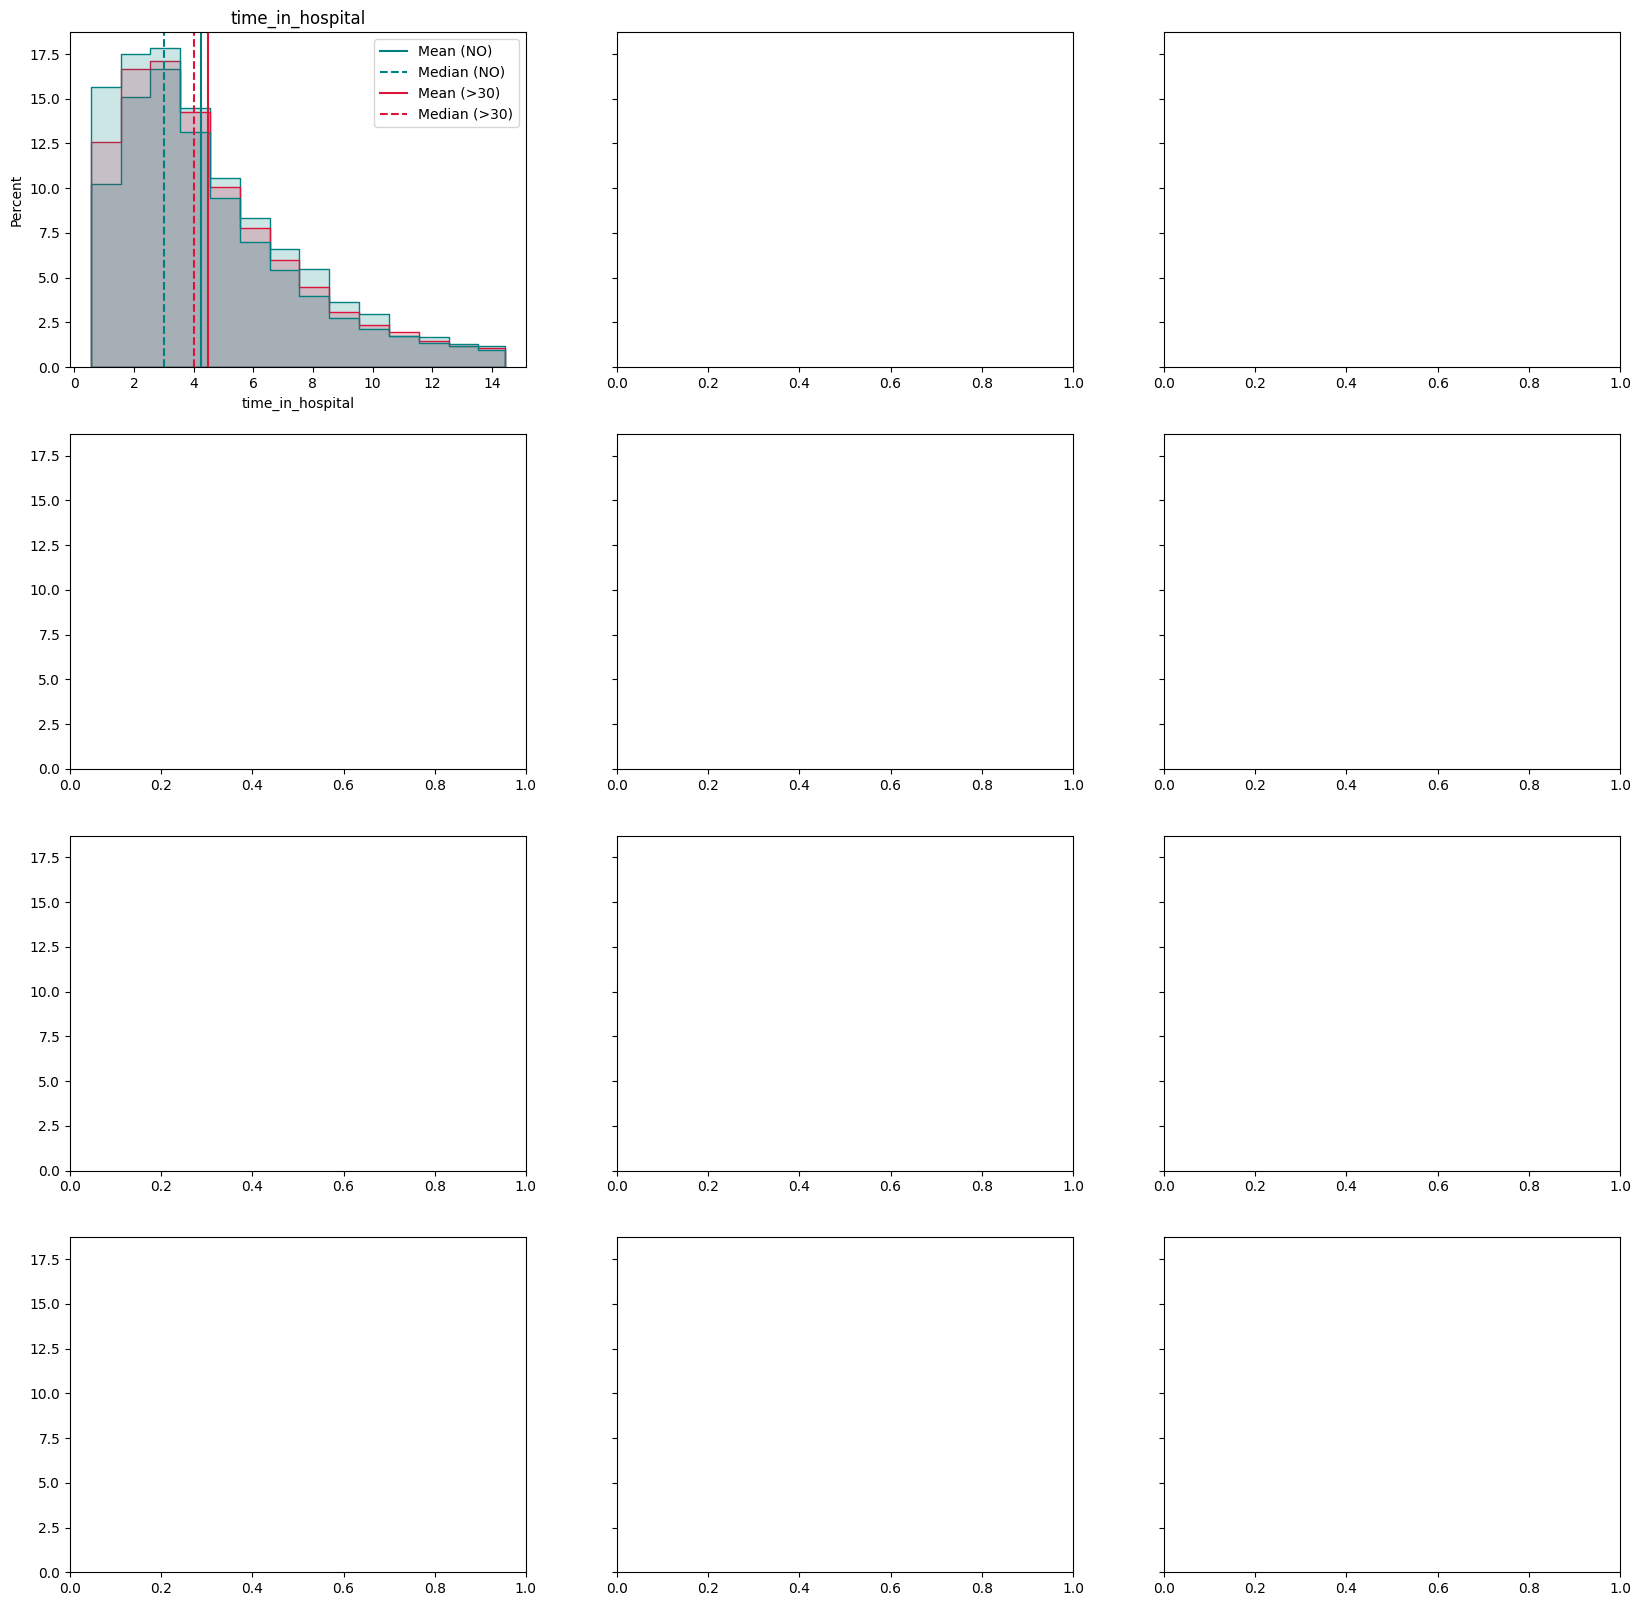

In [35]:
# let's look at the numerical data, we compare readmitted and not readmitted patients. we are looking at the percentages so we can see if the distributions are different.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20), sharey=True)
axes = axes.flatten()
palette=["teal", "crimson"]
for i, column in enumerate(numerical_columns):
    # Create a hist plot for each numerical column with color-coded bars
    sns.histplot( x=column, data=df, ax=axes[i],shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=palette, stat='percent', alpha=0.2)
    axes[i].set_title(column)
    for color_index, category in enumerate(df['readmitted'].unique()):
        mean_value = df[df['readmitted'] == category][column].mean()
        median_value = df[df['readmitted'] == category][column].median()
        axes[i].axvline(x=mean_value, color=palette[color_index], linestyle='-', label=f'Mean ({category})')
        axes[i].axvline(x=median_value, color=palette[color_index], linestyle='--', label=f'Median ({category})')
        axes[i].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## 3.0 handle data skewness
some of our data ooks skew Let's apply data transformation techniques:
1. logarithmic, 
2. square root
3. power transformations.
 and compeare the features, finally we will use the most "normal" lokking transformation:




<Axes: xlabel='time_in_hospital', ylabel='Percent'>

Text(0.5, 1.0, 'Log of time_in_hospital')

<Axes: xlabel='time_in_hospital', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of time_in_hospital')

<Axes: xlabel='time_in_hospital', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of time_in_hospital')

<Axes: xlabel='time_in_hospital', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'Log of num_lab_procedures')

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of num_lab_procedures')

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of num_lab_procedures')

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='num_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'Log of num_procedures')

<Axes: xlabel='num_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of num_procedures')

<Axes: xlabel='num_procedures', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of num_procedures')

<Axes: xlabel='num_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'Log of num_medications')

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of num_medications')

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of num_medications')

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='number_outpatient', ylabel='Percent'>

Text(0.5, 1.0, 'Log of number_outpatient')

<Axes: xlabel='number_outpatient', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of number_outpatient')

<Axes: xlabel='number_outpatient', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of number_outpatient')

<Axes: xlabel='number_outpatient', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='number_emergency', ylabel='Percent'>

Text(0.5, 1.0, 'Log of number_emergency')

<Axes: xlabel='number_emergency', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of number_emergency')

<Axes: xlabel='number_emergency', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of number_emergency')

<Axes: xlabel='number_emergency', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='number_inpatient', ylabel='Percent'>

Text(0.5, 1.0, 'Log of number_inpatient')

<Axes: xlabel='number_inpatient', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of number_inpatient')

<Axes: xlabel='number_inpatient', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of number_inpatient')

<Axes: xlabel='number_inpatient', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='number_diagnoses', ylabel='Percent'>

Text(0.5, 1.0, 'Log of number_diagnoses')

<Axes: xlabel='number_diagnoses', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of number_diagnoses')

<Axes: xlabel='number_diagnoses', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of number_diagnoses')

<Axes: xlabel='number_diagnoses', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='biguanides_and_related', ylabel='Percent'>

Text(0.5, 1.0, 'Log of biguanides_and_related')

<Axes: xlabel='biguanides_and_related', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of biguanides_and_related')

<Axes: xlabel='biguanides_and_related', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of biguanides_and_related')

<Axes: xlabel='biguanides_and_related', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='sulfonylureas_and_meglitinides', ylabel='Percent'>

Text(0.5, 1.0, 'Log of sulfonylureas_and_meglitinides')

<Axes: xlabel='sulfonylureas_and_meglitinides', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of sulfonylureas_and_meglitinides')

<Axes: xlabel='sulfonylureas_and_meglitinides', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of sulfonylureas_and_meglitinides')

<Axes: xlabel='sulfonylureas_and_meglitinides', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='thiazolidinediones_and_miscellaneous', ylabel='Percent'>

Text(0.5, 1.0, 'Log of thiazolidinediones_and_miscellaneous')

<Axes: xlabel='thiazolidinediones_and_miscellaneous', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of thiazolidinediones_and_miscellaneous')

<Axes: xlabel='thiazolidinediones_and_miscellaneous', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of thiazolidinediones_and_miscellaneous')

<Axes: xlabel='thiazolidinediones_and_miscellaneous', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

<Axes: xlabel='number_diabetic_famalies', ylabel='Percent'>

Text(0.5, 1.0, 'Log of number_diabetic_famalies')

<Axes: xlabel='number_diabetic_famalies', ylabel='Percent'>

Text(0.5, 1.0, 'Sqrt of number_diabetic_famalies')

<Axes: xlabel='number_diabetic_famalies', ylabel='Percent'>

Text(0.5, 1.0, '<lambda> of number_diabetic_famalies')

<Axes: xlabel='number_diabetic_famalies', ylabel='Percent'>

Text(0.5, 1.0, 'Original')

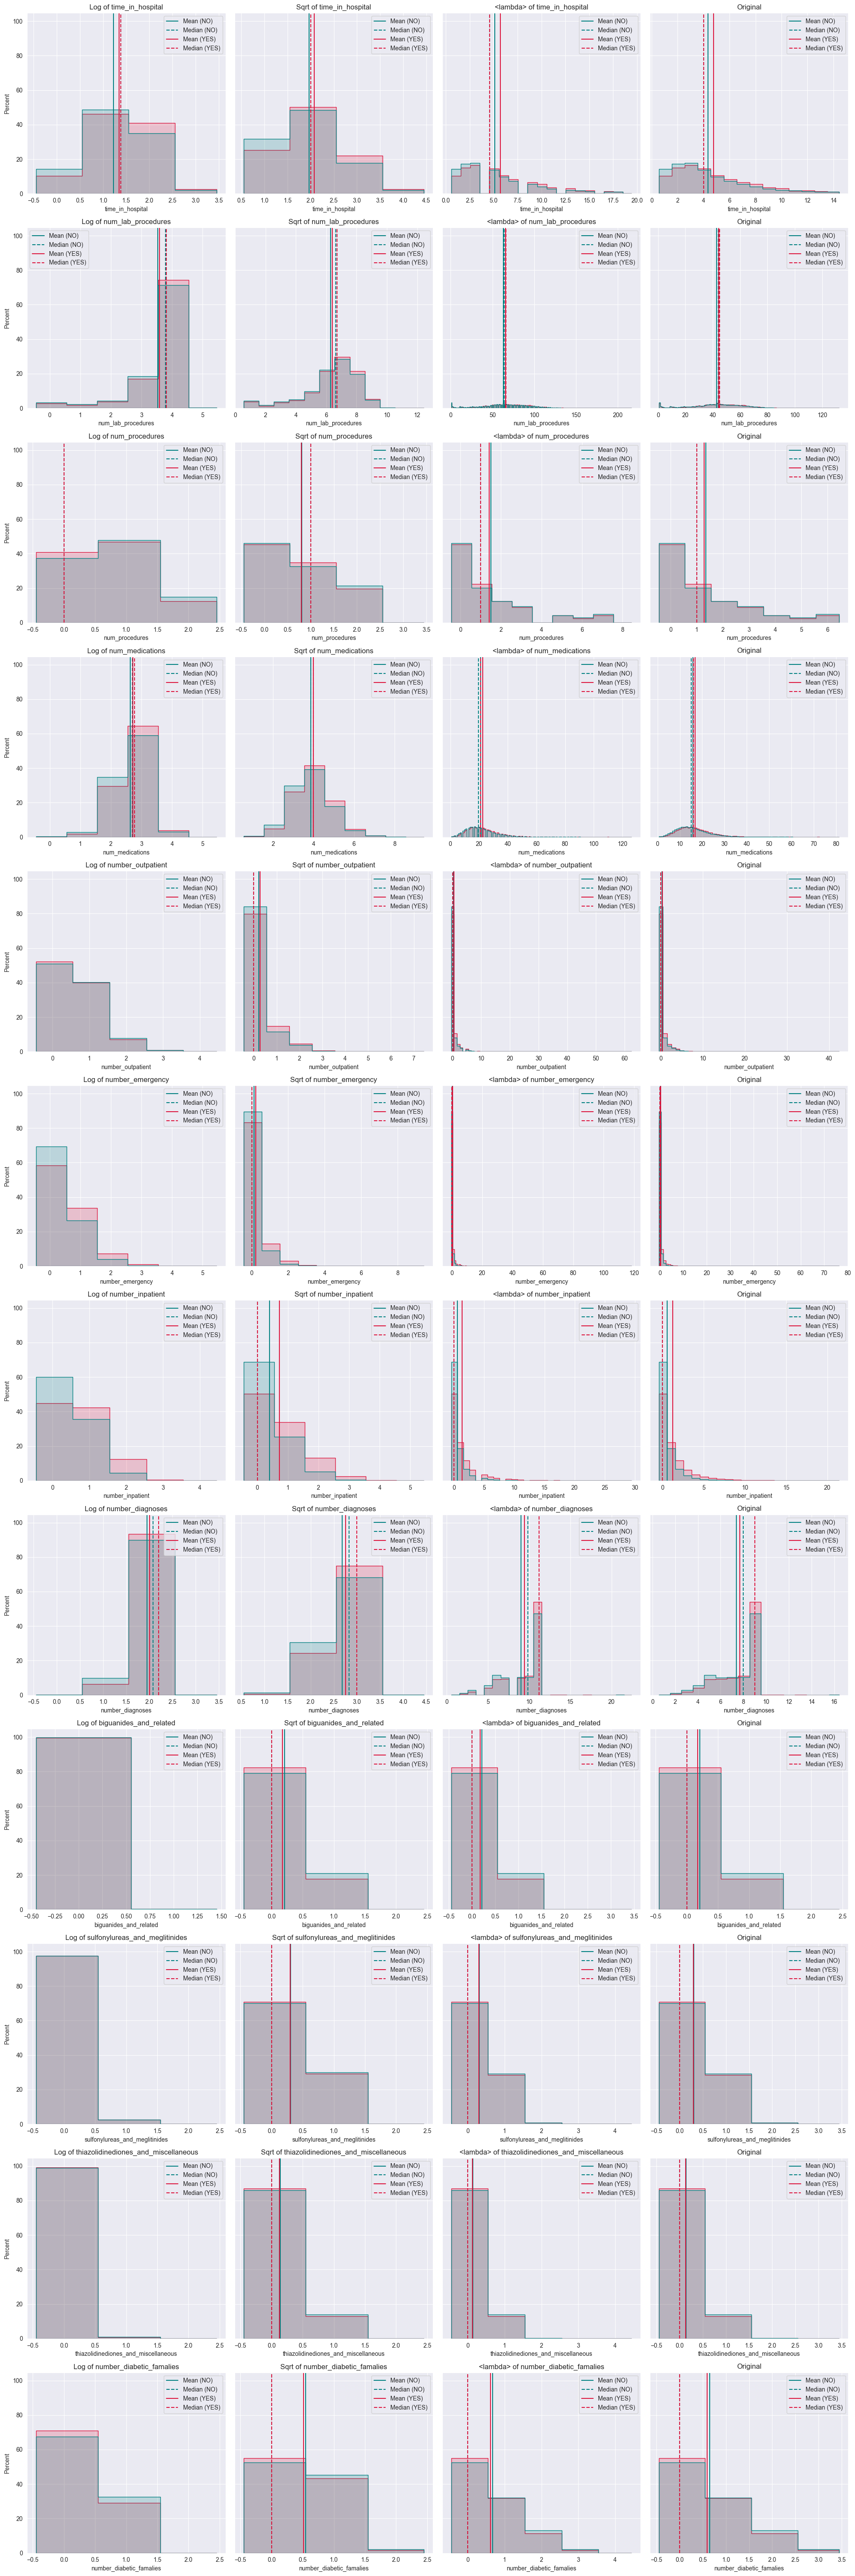

In [403]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'numerical_columns' is a list of numerical column names

# Define the transformations to apply
transformations = [np.log, np.sqrt, lambda x: np.power(x, 1.1), 1]  # Log, sqrt, and power transformations

# Create subplots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=len(transformations), figsize=(20, 5*len(numerical_columns)), sharey=True)

# Flatten axes for easy iteration

palette = ["teal", "crimson"]


for i, column in enumerate(numerical_columns):
    for j, transformation in enumerate(transformations):
        # Apply transformation to the column
        if transformation != 1:
            transformed_data = df[column].apply(transformation)
        else:
            transformed_data = df[column]
        # Create a histogram plot for the transformed data with color-coded bars
        sns.histplot(x=transformed_data, data=df, ax=axes[i, j], shrink=.9, hue='readmitted',
                     discrete=True, element='step', common_norm=False, palette=palette, stat='percent', alpha=0.2)
        
        # Plot vertical lines for mean and median of each readmission status
        
        for color_index, category in enumerate(df['readmitted'].unique()):
            mean_value = transformed_data[df['readmitted'] == category].mean()
            median_value = transformed_data[df['readmitted'] == category].median()
            axes[i, j].axvline(x=mean_value, color=palette[color_index], linestyle='-',
                                                          label=f'Mean ({category})')
            axes[i, j].axvline(x=median_value, color=palette[color_index], linestyle='--',
                                                          label=f'Median ({category})')
            axes[i, j].legend()
        try:
            axes[i, j].set_title(f"{transformation.__name__.capitalize()} of {column}")
        except AttributeError:
             axes[i, j].set_title(f"Original")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [404]:
numerical_columns

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'biguanides_and_related',
 'sulfonylureas_and_meglitinides',
 'thiazolidinediones_and_miscellaneous',
 'number_diabetic_famalies']

from abserving the data the following transformations will happened:
log:['number_outpatient', 'number_emergency']
root:['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_inpatient', 'number_diagnoses']


In [405]:
df[root_features]

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                     1                  41               0                1   
1                     3                  59               0               18   
2                     2                  11               5               13   
3                     2                  44               1               16   
4                     1                  51               0                8   
...                 ...                 ...             ...              ...   
99338                 3                  51               0               16   
99339                 5                  33               3               18   
99340                 1                  53               0                9   
99341                10                  45               2               21   
99342                 6                  13               3                3   

       number_inpatient  number_diagnoses  
0                     0                 1  
1                     0                 9  
2                     1                 6  
3                     0                 7  
4                     0                 5  
...                 ...               ...  
99338                 0                 9  
99339                 1                 9  
99340                 0                13  
99341                 1                 9  
99342                 0                 9  

[99343 rows x 6 columns]

In [406]:


# Features to transform with log
log_features = []
# ['number_outpatient', 'number_emergency']

# Features to transform with square root
root_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                 'num_medications', 'number_inpatient', 'number_diagnoses','number_outpatient', 'number_emergency']

# List of transformations to apply
transformations = [np.log, np.sqrt]

# List of features corresponding to each transformation
t_features = [log_features, root_features]

# Apply transformations
for transformation_index, features in enumerate(t_features):
    # Apply the transformation function to each feature in the current group
        df[features] = transformations[transformation_index](df[features])


<Axes: xlabel='time_in_hospital', ylabel='Percent'>

Text(0.5, 1.0, 'time_in_hospital')

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'num_lab_procedures')

<Axes: xlabel='num_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'num_procedures')

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'num_medications')

<Axes: xlabel='number_outpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_outpatient')

<Axes: xlabel='number_emergency', ylabel='Percent'>

Text(0.5, 1.0, 'number_emergency')

<Axes: xlabel='number_inpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_inpatient')

<Axes: xlabel='number_diagnoses', ylabel='Percent'>

Text(0.5, 1.0, 'number_diagnoses')

<Axes: xlabel='biguanides_and_related', ylabel='Percent'>

Text(0.5, 1.0, 'biguanides_and_related')

<Axes: xlabel='sulfonylureas_and_meglitinides', ylabel='Percent'>

Text(0.5, 1.0, 'sulfonylureas_and_meglitinides')

<Axes: xlabel='thiazolidinediones_and_miscellaneous', ylabel='Percent'>

Text(0.5, 1.0, 'thiazolidinediones_and_miscellaneous')

<Axes: xlabel='number_diabetic_famalies', ylabel='Percent'>

Text(0.5, 1.0, 'number_diabetic_famalies')

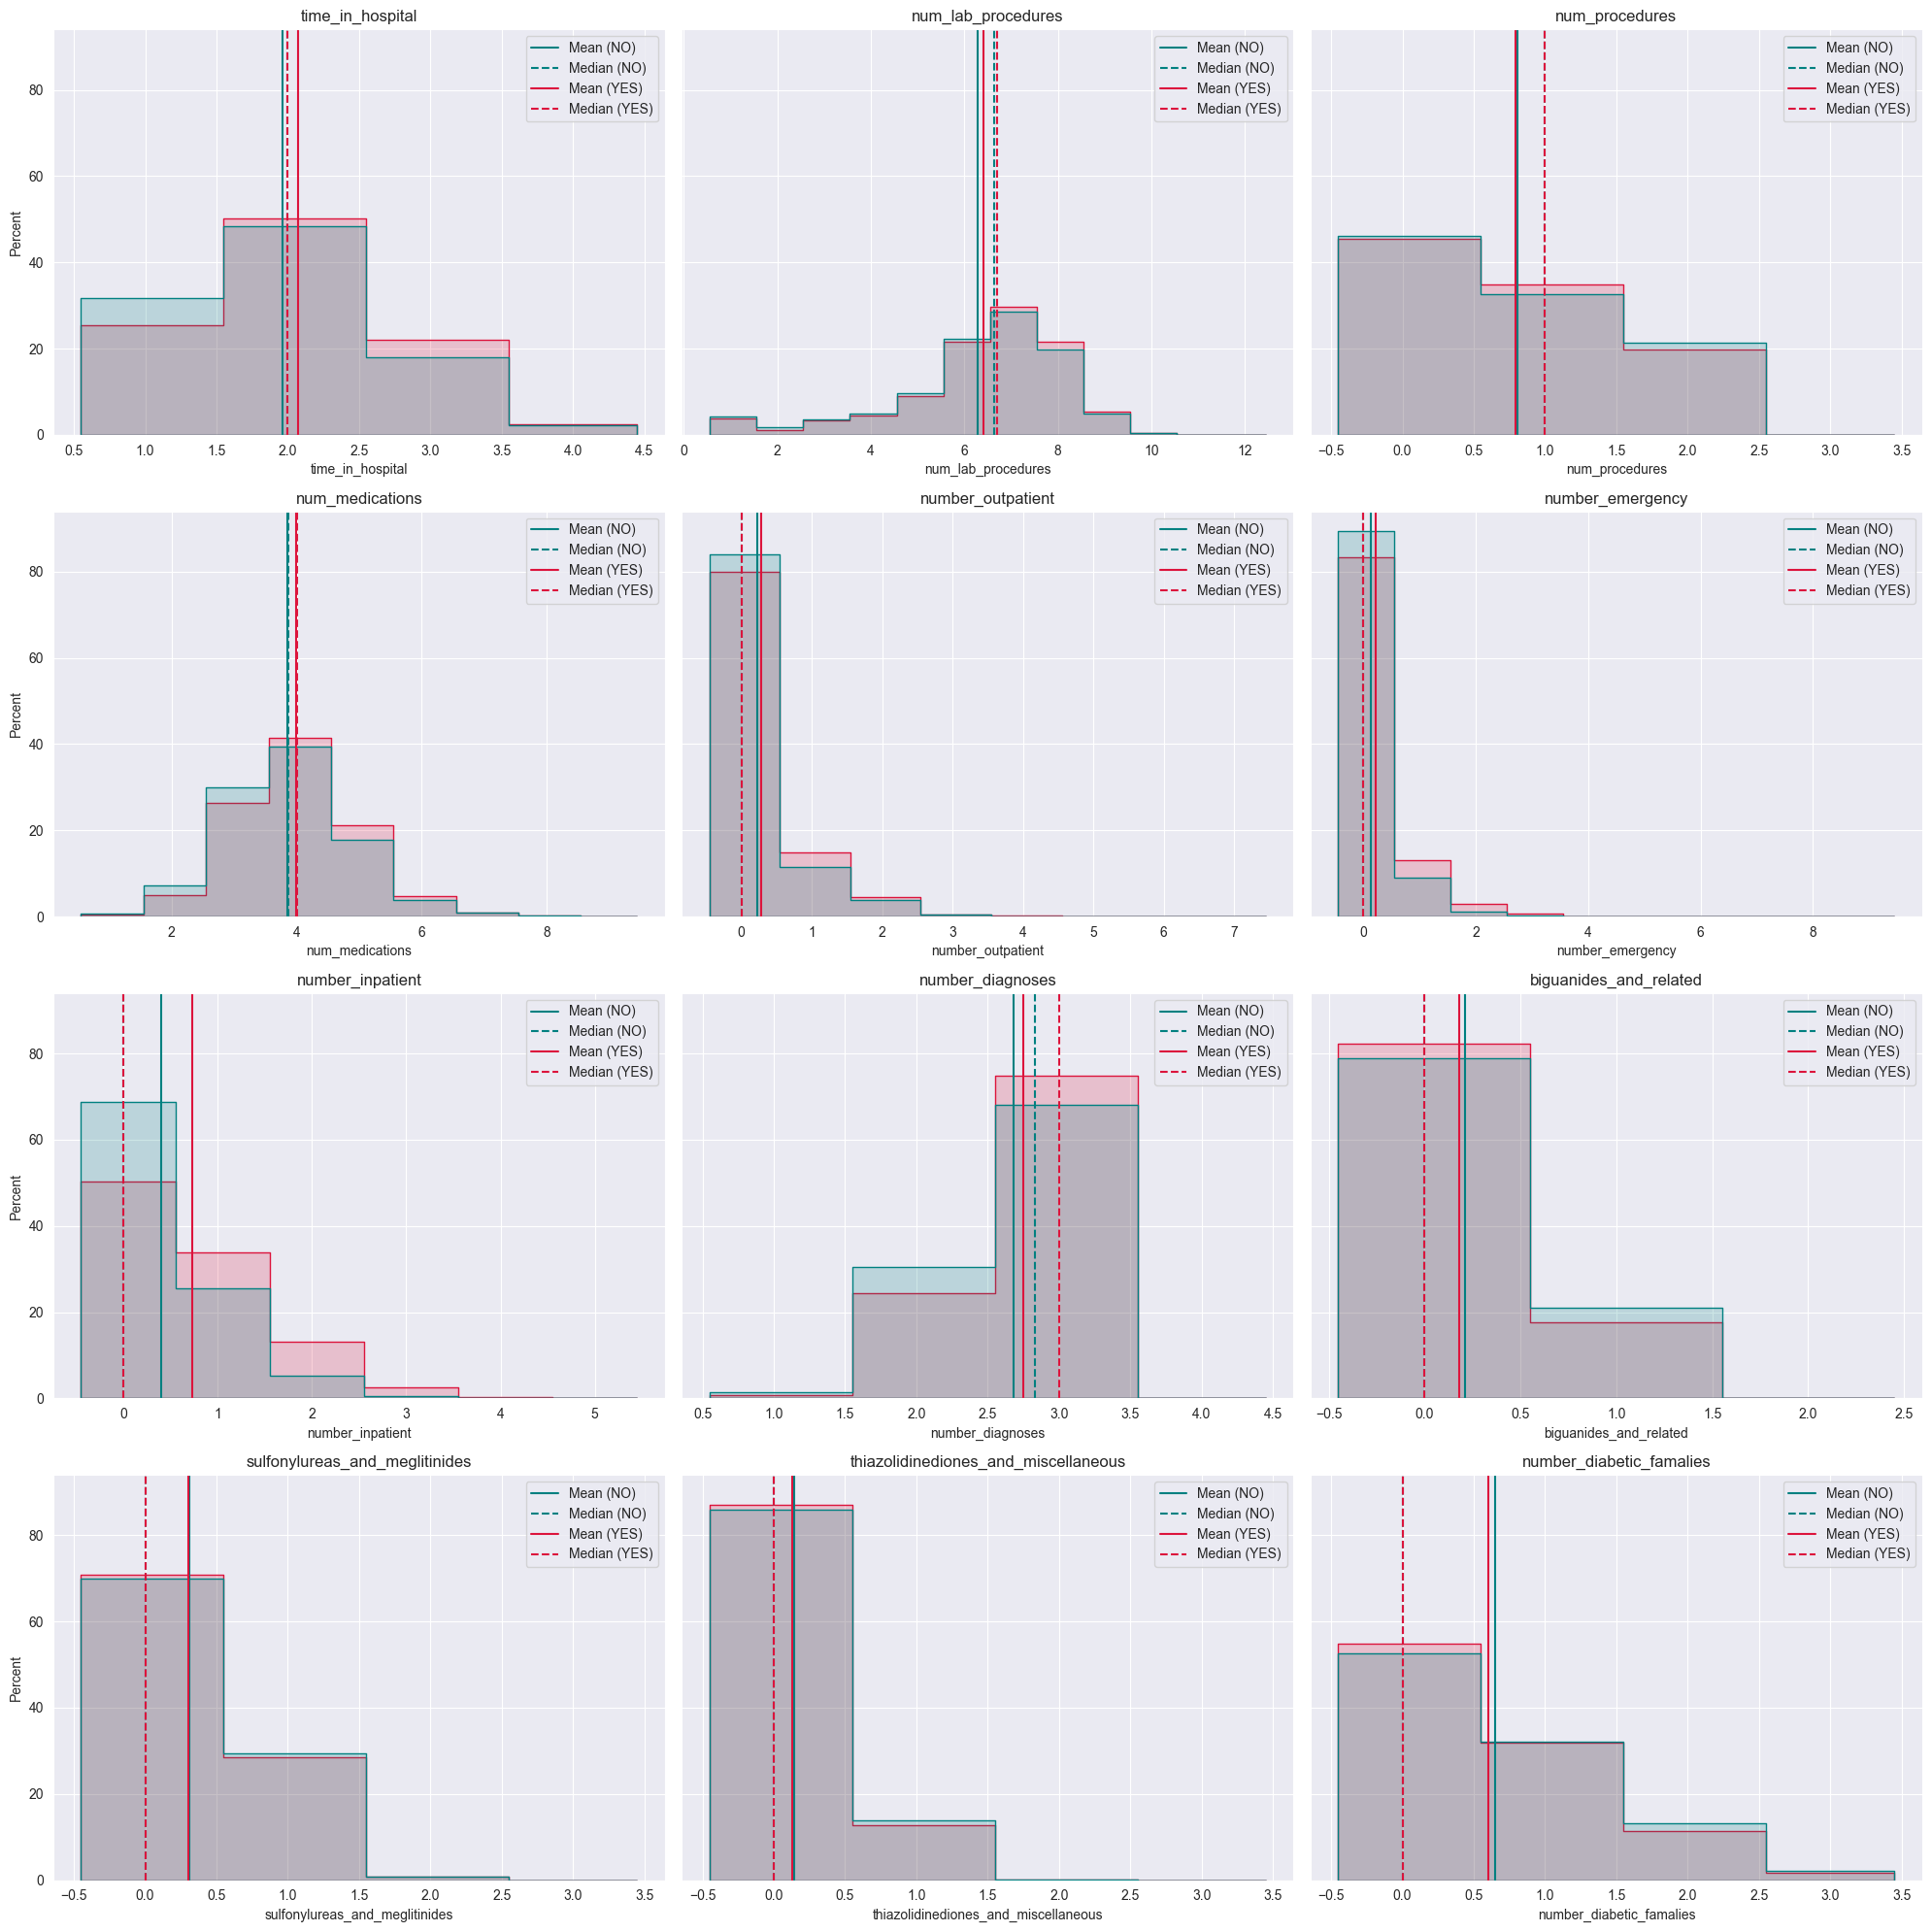

In [407]:
# let's look at the numerical data, we compare readmitted and not readmitted patients. we are looking at the percentages so we can see if the distributions are different.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20), sharey=True)
axes = axes.flatten()
palette=["teal", "crimson"]
for i, column in enumerate(numerical_columns):
    # Create a hist plot for each numerical column with color-coded bars
    sns.histplot( x=column, data=df, ax=axes[i],shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=palette, stat='percent', alpha=0.2)
    axes[i].set_title(column)
    for color_index, category in enumerate(df['readmitted'].unique()):
        mean_value = df[df['readmitted'] == category][column].mean()
        median_value = df[df['readmitted'] == category][column].median()
        axes[i].axvline(x=mean_value, color=palette[color_index], linestyle='-', label=f'Mean ({category})')
        axes[i].axvline(x=median_value, color=palette[color_index], linestyle='--', label=f'Median ({category})')
        axes[i].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## 3.1 outliers

<Axes: xlabel='time_in_hospital'>

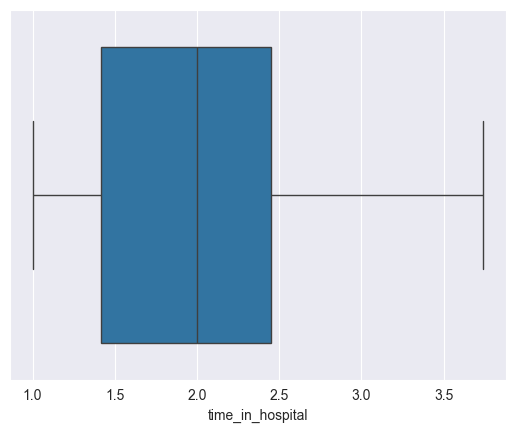

<Axes: xlabel='num_lab_procedures'>

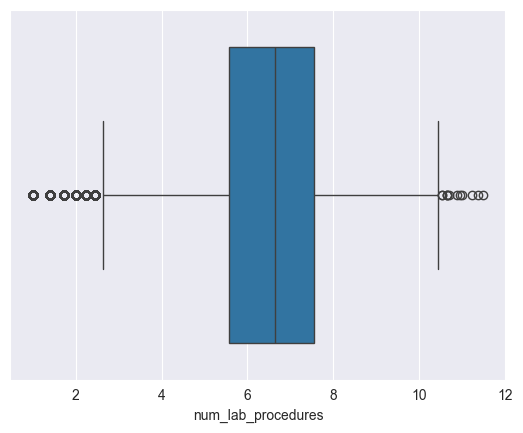

<Axes: xlabel='num_procedures'>

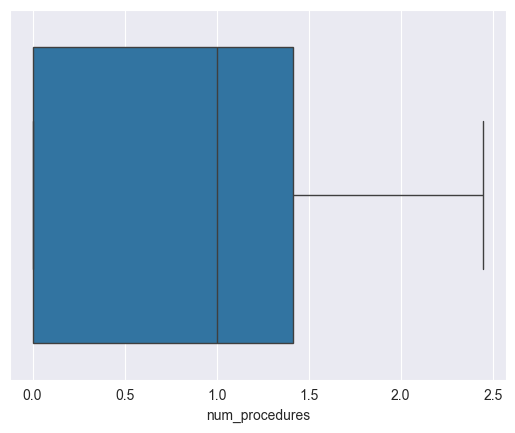

<Axes: xlabel='num_medications'>

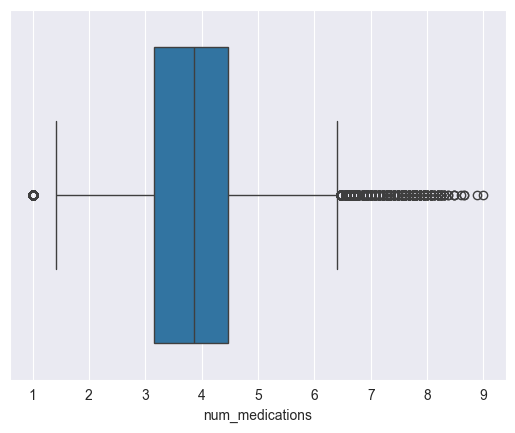

<Axes: xlabel='number_outpatient'>

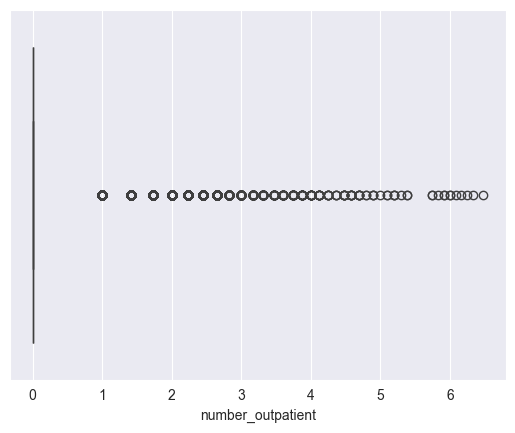

<Axes: xlabel='number_emergency'>

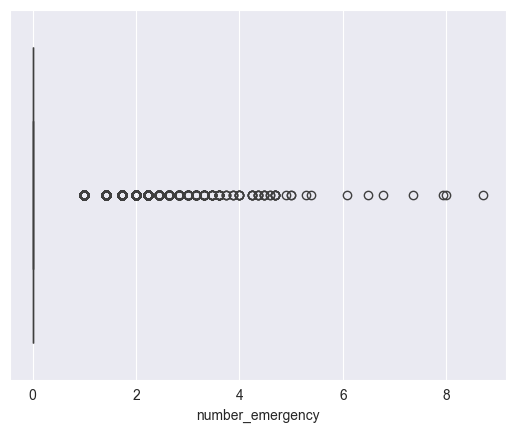

<Axes: xlabel='number_inpatient'>

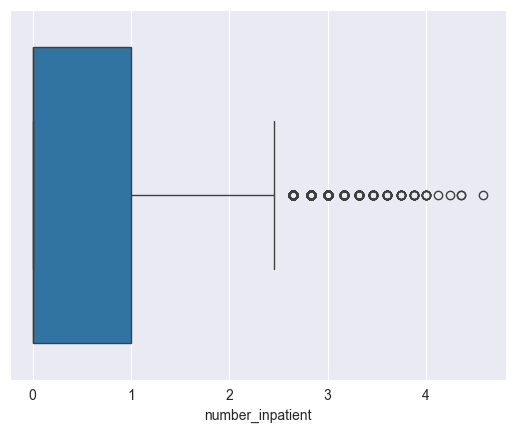

<Axes: xlabel='number_diagnoses'>

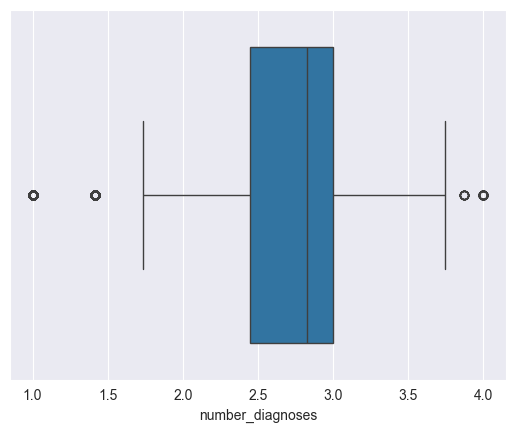

<Axes: xlabel='biguanides_and_related'>

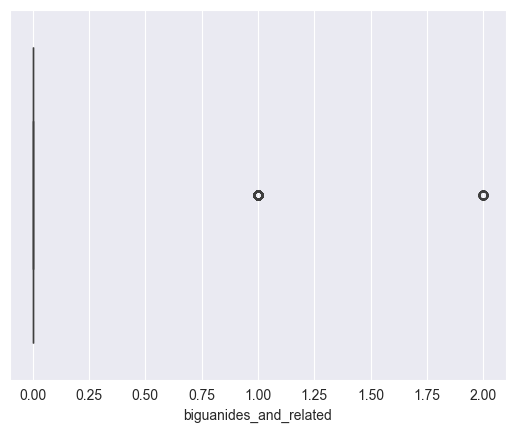

<Axes: xlabel='sulfonylureas_and_meglitinides'>

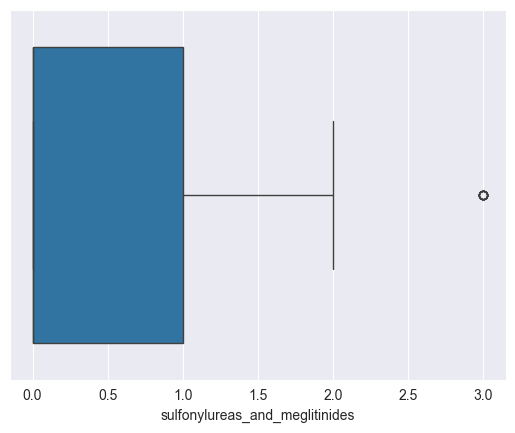

<Axes: xlabel='thiazolidinediones_and_miscellaneous'>

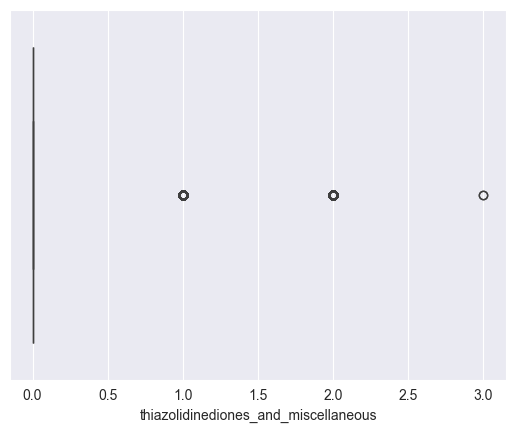

<Axes: xlabel='number_diabetic_famalies'>

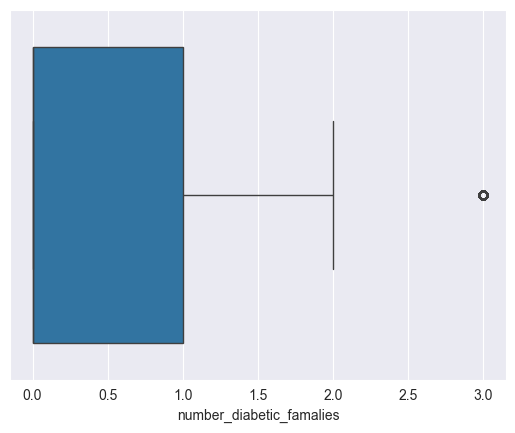

time_in_hospital 0 []
num_lab_procedures 5856 [ 1.          1.41421356  1.73205081  2.          2.23606798  2.44948974
 10.53565375 10.63014581 10.67707825 10.86278049 10.95445115 11.
 11.22497216 11.35781669 11.48912529]
num_procedures 0 []
num_medications 1432 [1.         6.4807407  6.55743852 6.63324958 6.70820393 6.78232998
 6.8556546  6.92820323 7.         7.07106781 7.14142843 7.21110255
 7.28010989 7.34846923 7.41619849 7.48331477 7.54983444 7.61577311
 7.68114575 7.74596669 7.81024968 7.87400787 7.93725393 8.
 8.06225775 8.1240384  8.18535277 8.24621125 8.30662386 8.36660027
 8.48528137 8.60232527 8.66025404 8.88819442 9.        ]
number_outpatient 99343 [0.         1.         1.41421356 1.73205081 2.         2.23606798
 2.44948974 2.64575131 2.82842712 3.         3.16227766 3.31662479
 3.46410162 3.60555128 3.74165739 3.87298335 4.         4.12310563
 4.24264069 4.35889894 4.47213595 4.58257569 4.69041576 4.79583152
 4.89897949 5.         5.09901951 5.19615242 5.29150262 5.385

In [408]:
dict_outliers = {}

def boxplot_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    outliers_bool = (df[col] <= Q1 - 1.5 * IQR) | (df[col] >= Q3 + 1.5 *IQR)
    return df[col][outliers_bool]
col_to_check_for_outliers = numerical_columns

for col in col_to_check_for_outliers:
    dict_outliers.update({col : boxplot_outliers(col)})

# Creating individual plots
for var in col_to_check_for_outliers:
    sns.boxplot(x=var, data=df)
    plt.show()

for key, value in dict_outliers.items() :
    print (key, len(value), np.unique(value))

### we will deal with the outliers in the Cleaning Data section below


we are using cliping to solve the outliers

In [361]:
## 3.2 lets look at the diffrent distrebutions regarding the label

In [362]:
# To see the diffrence between the two groups we ploted both an histogram of the numerical values and the papulation destribution, the distribution allows us to compere the unbalanced data

# out of this plots we see can't see a big difrence in: 'num_lab_procedures', 'num_procedures', 'number_outpatient' and 'number_emergency'.
# and we can see some difrence in: 'time_in_hospital' (higher values in longer time for readmitted), 'num_medications' (more medications for readmitted), 'number_inpatient' (pepole that readmit tend to go more to hospitals)
# and finaly number_diagnose (readmitted pations have more diagnoses)

## 3.3 Looking for Correlations

In [409]:
df[numerical_columns].corr()

time_in_hospital  num_lab_procedures  \
time_in_hospital                              1.000000            0.300466   
num_lab_procedures                            0.300466            1.000000   
num_procedures                                0.194507            0.025588   
num_medications                               0.472467            0.246827   
number_outpatient                            -0.013389           -0.026619   
number_emergency                             -0.005812            0.001257   
number_inpatient                              0.091996            0.045950   
number_diagnoses                              0.232270            0.126138   
biguanides_and_related                       -0.001996           -0.047881   
sulfonylureas_and_meglitinides                0.048855            0.011340   
thiazolidinediones_and_miscellaneous          0.010470           -0.015740   
number_diabetic_famalies                      0.027741           -0.027390   

                                      num_procedures  num_medications  \
time_in_hospital                            0.194507         0.472467   
num_lab_procedures                          0.025588         0.246827   
num_procedures                              1.000000         0.373661   
num_medications                             0.373661         1.000000   
number_outpatient                          -0.025265         0.066264   
number_emergency                           -0.047972         0.032959   
number_inpatient                           -0.065892         0.088375   
number_diagnoses                            0.070912         0.290342   
biguanides_and_related                     -0.037805         0.076920   
sulfonylureas_and_meglitinides              0.006685         0.106924   
thiazolidinediones_and_miscellaneous        0.020942         0.100206   
number_diabetic_famalies                   -0.006363         0.143178   

                                      number_outpatient  number_emergency  \
time_in_hospital                              -0.013389         -0.005812   
num_lab_procedures                            -0.026619          0.001257   
num_procedures                                -0.025265         -0.047972   
num_medications                                0.066264          0.032959   
number_outpatient                              1.000000          0.170422   
number_emergency                               0.170422          1.000000   
number_inpatient                               0.154746          0.269268   
number_diagnoses                               0.110294          0.080454   
biguanides_and_related                        -0.008870         -0.014842   
sulfonylureas_and_meglitinides                -0.003732         -0.023410   
thiazolidinediones_and_miscellaneous           0.015981          0.003123   
number_diabetic_famalies                       0.000224         -0.020632   

                                      number_inpatient  number_diagnoses  \
time_in_hospital                              0.091996          0.232270   
num_lab_procedures                            0.045950          0.126138   
num_procedures                               -0.065892          0.070912   
num_medications                               0.088375          0.290342   
number_outpatient                             0.154746          0.110294   
number_emergency                              0.269268          0.080454   
number_inpatient                              1.000000          0.129205   
number_diagnoses                              0.129205          1.000000   
biguanides_and_related                       -0.074278         -0.063818   
sulfonylureas_and_meglitinides               -0.037443          0.005326   
thiazolidinediones_and_miscellaneous         -0.031373          0.002268   
number_diabetic_famalies                     -0.074408         -0.030383   

                                      biguanides_and_related  \
time_in_hospital  

In [415]:
df[numerical_columns].shape

(99343, 12)

<Axes: >

Text(0.5, 1.0, 'Pearson Correlation Coefficient Heatmap')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, 'time_in_hospital'),
  Text(0, 1.5, 'num_lab_procedures'),
  Text(0, 2.5, 'num_procedures'),
  Text(0, 3.5, 'num_medications'),
  Text(0, 4.5, 'number_outpatient'),
  Text(0, 5.5, 'number_emergency'),
  Text(0, 6.5, 'number_inpatient'),
  Text(0, 7.5, 'number_diagnoses'),
  Text(0, 8.5, 'biguanides_and_related'),
  Text(0, 9.5, 'sulfonylureas_and_meglitinides'),
  Text(0, 10.5, 'thiazolidinediones_and_miscellaneous'),
  Text(0, 11.5, 'number_diabetic_famalies')])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, 'time_in_hospital'),
  Text(1.5, 0, 'num_lab_procedures'),
  Text(2.5, 0, 'num_procedures'),
  Text(3.5, 0, 'num_medications'),
  Text(4.5, 0, 'number_outpatient'),
  Text(5.5, 0, 'number_emergency'),
  Text(6.5, 0, 'number_inpatient'),
  Text(7.5, 0, 'number_diagnoses'),
  Text(8.5, 0, 'biguanides_and_related'),
  Text(9.5, 0, 'sulfonylureas_and_meglitinides'),
  Text(10.5, 0, 'thiazolidinediones_and_miscellaneous'),
  Text(11.5, 0, 'number_diabetic_famalies')])

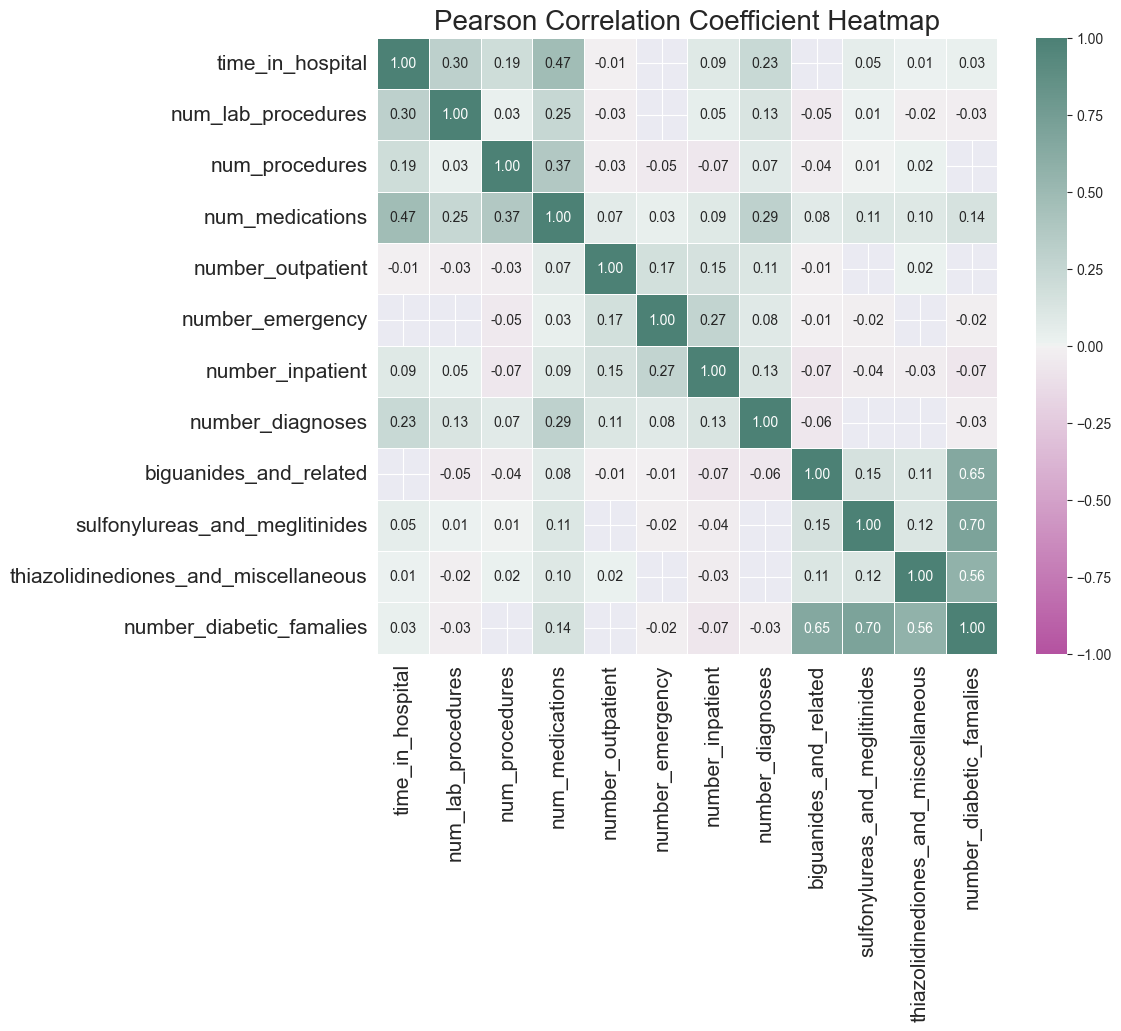

In [419]:
from scipy.stats import pearsonr
def calculate_pearsonr_diagonal_and_below(df):
    num_columns = df.shape[1]
    
    # Initialize matrices to store correlation coefficients and p-values with NaN
    correlation_matrix = np.full((num_columns, num_columns), np.nan)
    p_value_matrix = np.full((num_columns, num_columns), np.nan)

    # Calculate correlation coefficient and p-value for each pair of columns
    for i in range(num_columns):
        x = df.iloc[:, i].values  # Convert to NumPy array for faster calculations
        for j in range(i, num_columns):  # Start from i to only calculate the diagonal and below
            y = df.iloc[:, j].values  # Convert to NumPy array for faster calculations
            
            # Calculate Pearson correlation coefficient and p-value
            correlation, p_value = pearsonr(x, y)
            
            # Store values in matrices
            correlation_matrix[i, j] = correlation
            p_value_matrix[i, j] = p_value

    return correlation_matrix, p_value_matrix

num_columns = df[numerical_columns].shape[1]
correlation_matrix, p_value_matrix = calculate_pearsonr_diagonal_and_below(df[numerical_columns])

corrected_p_values = multipletests(p_value_matrix[np.triu_indices(num_columns)], method='fdr_bh')[1]
p_value_matrix[np.triu_indices(num_columns)] = corrected_p_values
correlation_matrix = np.nansum(np.stack([correlation_matrix,correlation_matrix.T]), axis=0)
p_value_matrix = np.nansum(np.stack([p_value_matrix,p_value_matrix.T]), axis=0)


p_relevant = np.full_like(p_value_matrix, np.nan)
p_relevant[p_value_matrix<=0.05] = 1


cmap = sns.diverging_palette(320, 170, s=60, as_cmap=True)
correlation_df = pd.DataFrame(correlation_matrix * p_relevant , columns=df[numerical_columns].columns, index=df[numerical_columns].columns)
correlation_df[correlation_df>1] =1
# Plotting the heatmap
fig = plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap=cmap, fmt='.2f', linewidths=.5, vmin=-1, vmax=1)
plt.title('Pearson Correlation Coefficient Heatmap', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()
fig.savefig('Pearson_cor_heatmap.pdf')








[Text(0.5, 0, 'thiazolidinediones_and_miscellaneous'),
 Text(1.5, 0, 'biguanides_and_related'),
 Text(2.5, 0, 'sulfonylureas_and_meglitinides'),
 Text(3.5, 0, 'number_diabetic_famalies'),
 Text(4.5, 0, 'number_outpatient'),
 Text(5.5, 0, 'number_emergency'),
 Text(6.5, 0, 'number_inpatient'),
 Text(7.5, 0, 'num_procedures'),
 Text(8.5, 0, 'number_diagnoses'),
 Text(9.5, 0, 'num_lab_procedures'),
 Text(10.5, 0, 'time_in_hospital'),
 Text(11.5, 0, 'num_medications')]

[Text(1, 0.5, 'thiazolidinediones_and_miscellaneous'),
 Text(1, 1.5, 'biguanides_and_related'),
 Text(1, 2.5, 'sulfonylureas_and_meglitinides'),
 Text(1, 3.5, 'number_diabetic_famalies'),
 Text(1, 4.5, 'number_outpatient'),
 Text(1, 5.5, 'number_emergency'),
 Text(1, 6.5, 'number_inpatient'),
 Text(1, 7.5, 'num_procedures'),
 Text(1, 8.5, 'number_diagnoses'),
 Text(1, 9.5, 'num_lab_procedures'),
 Text(1, 10.5, 'time_in_hospital'),
 Text(1, 11.5, 'num_medications')]

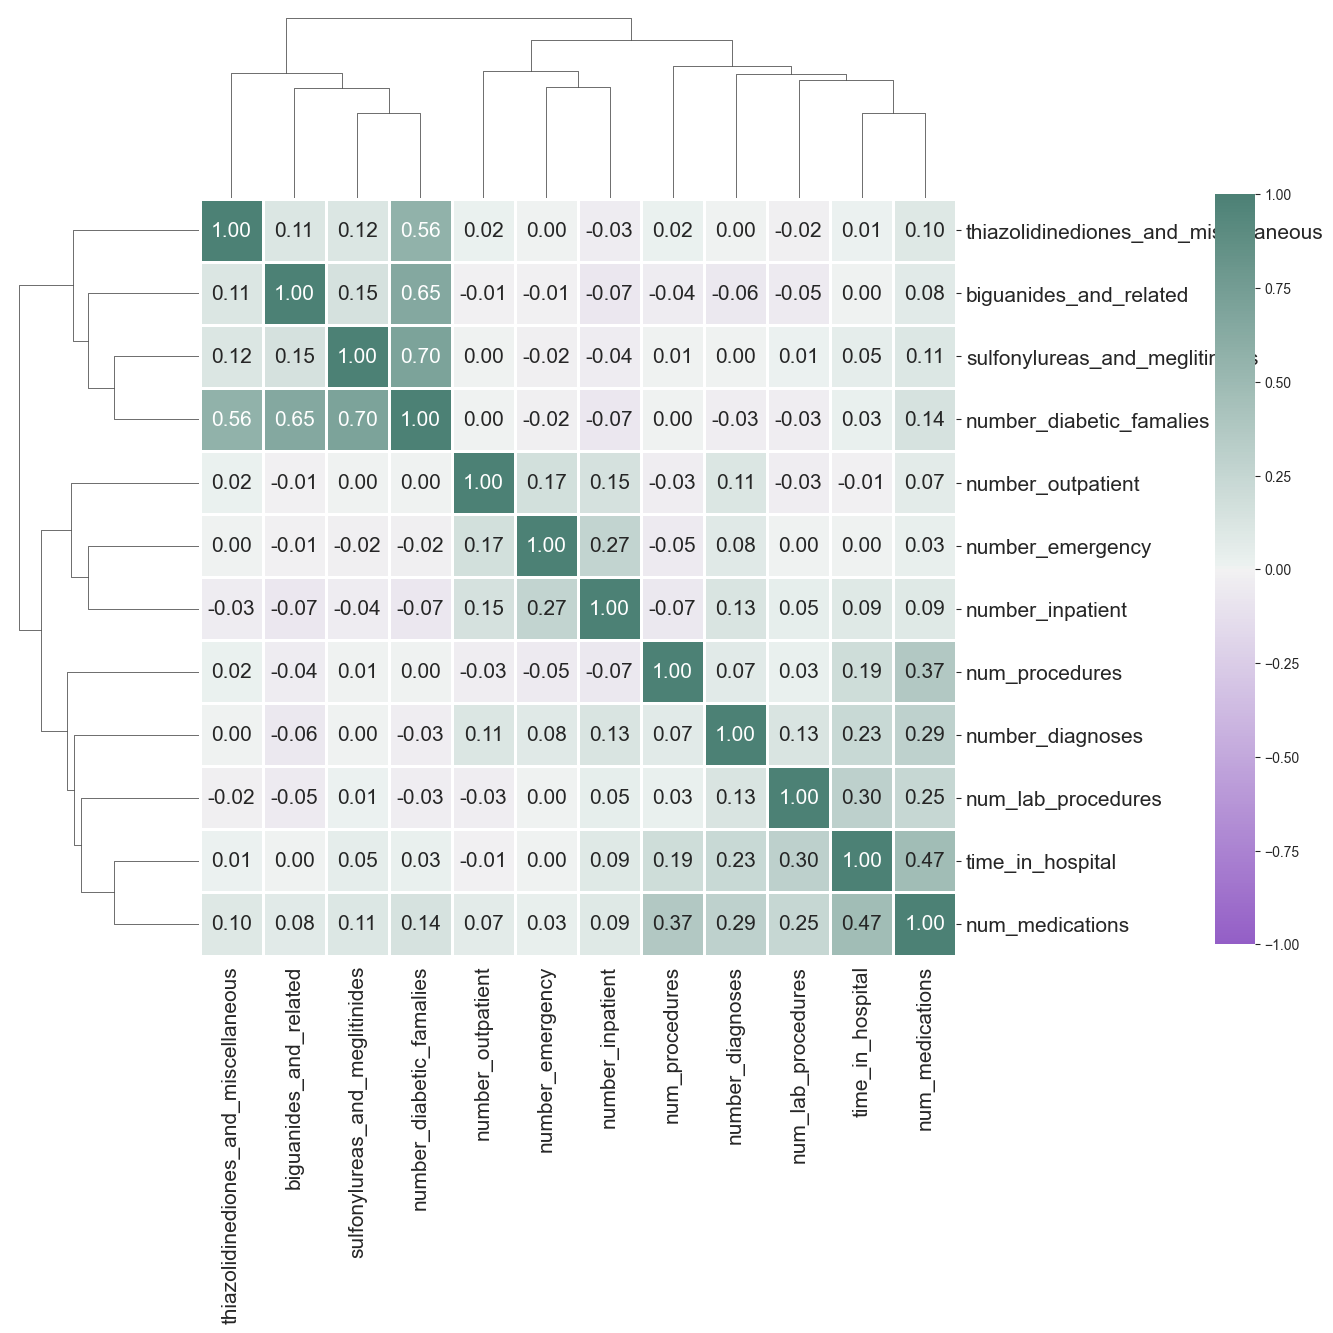

In [420]:

# Assuming you already have your `correlation_df` and `order`

cmap = sns.diverging_palette(283, 170, s=60, as_cmap=True)
g = sns.clustermap(np.nan_to_num(correlation_df), row_cluster=True, cmap=cmap, col_cluster=True, vmin=-1, vmax=1, cbar_pos=(1.22, .05, .04, .75), annot=True, fmt='.2f', annot_kws={'fontsize': 15}, linewidths=1)

# Set x-axis ticks based on column names
ax = g.ax_heatmap
order = [int(label.get_text()) for label in ax.xaxis.get_ticklabels()]
ax.set_xticklabels(correlation_df.columns[order], rotation=90)

# Set font size for both x-axis and y-axis ticks
ax.tick_params(axis='both', labelsize=15)

order = [int(label.get_text()) for label in ax.yaxis.get_ticklabels()]
ax.set_yticklabels(correlation_df.columns[order], rotation=0)        
        
plt.show()
g.savefig('corelation_hirachy.pdf')

In [422]:
numerical_columns

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'biguanides_and_related',
 'sulfonylureas_and_meglitinides',
 'thiazolidinediones_and_miscellaneous',
 'number_diabetic_famalies']

## 
"The hierarchical ordering of the features reveals three groups, each exhibiting a tendency to correlate internally:

1. Drugs: ['biguanides_and_related', 'sulfonylureas_and_meglitinides', 'thiazolidinediones_and_miscellaneous', 'number_diabetic_families']

2. Number of hospital visits: ['number_emergency', 'number_inpatient', 'number_diagnoses']

3. Treatment in hospital: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_dia
noses']"

array([[<Axes: xlabel='biguanides_and_related', ylabel='biguanides_and_related'>,
        <Axes: xlabel='sulfonylureas_and_meglitinides', ylabel='biguanides_and_related'>,
        <Axes: xlabel='thiazolidinediones_and_miscellaneous', ylabel='biguanides_and_related'>,
        <Axes: xlabel='number_diabetic_famalies', ylabel='biguanides_and_related'>],
       [<Axes: xlabel='biguanides_and_related', ylabel='sulfonylureas_and_meglitinides'>,
        <Axes: xlabel='sulfonylureas_and_meglitinides', ylabel='sulfonylureas_and_meglitinides'>,
        <Axes: xlabel='thiazolidinediones_and_miscellaneous', ylabel='sulfonylureas_and_meglitinides'>,
        <Axes: xlabel='number_diabetic_famalies', ylabel='sulfonylureas_and_meglitinides'>],
       [<Axes: xlabel='biguanides_and_related', ylabel='thiazolidinediones_and_miscellaneous'>,
        <Axes: xlabel='sulfonylureas_and_meglitinides', ylabel='thiazolidinediones_and_miscellaneous'>,
        <Axes: xlabel='thiazolidinediones_and_miscellaneous', 

Text(0.5, 0.98, 'Drugs')

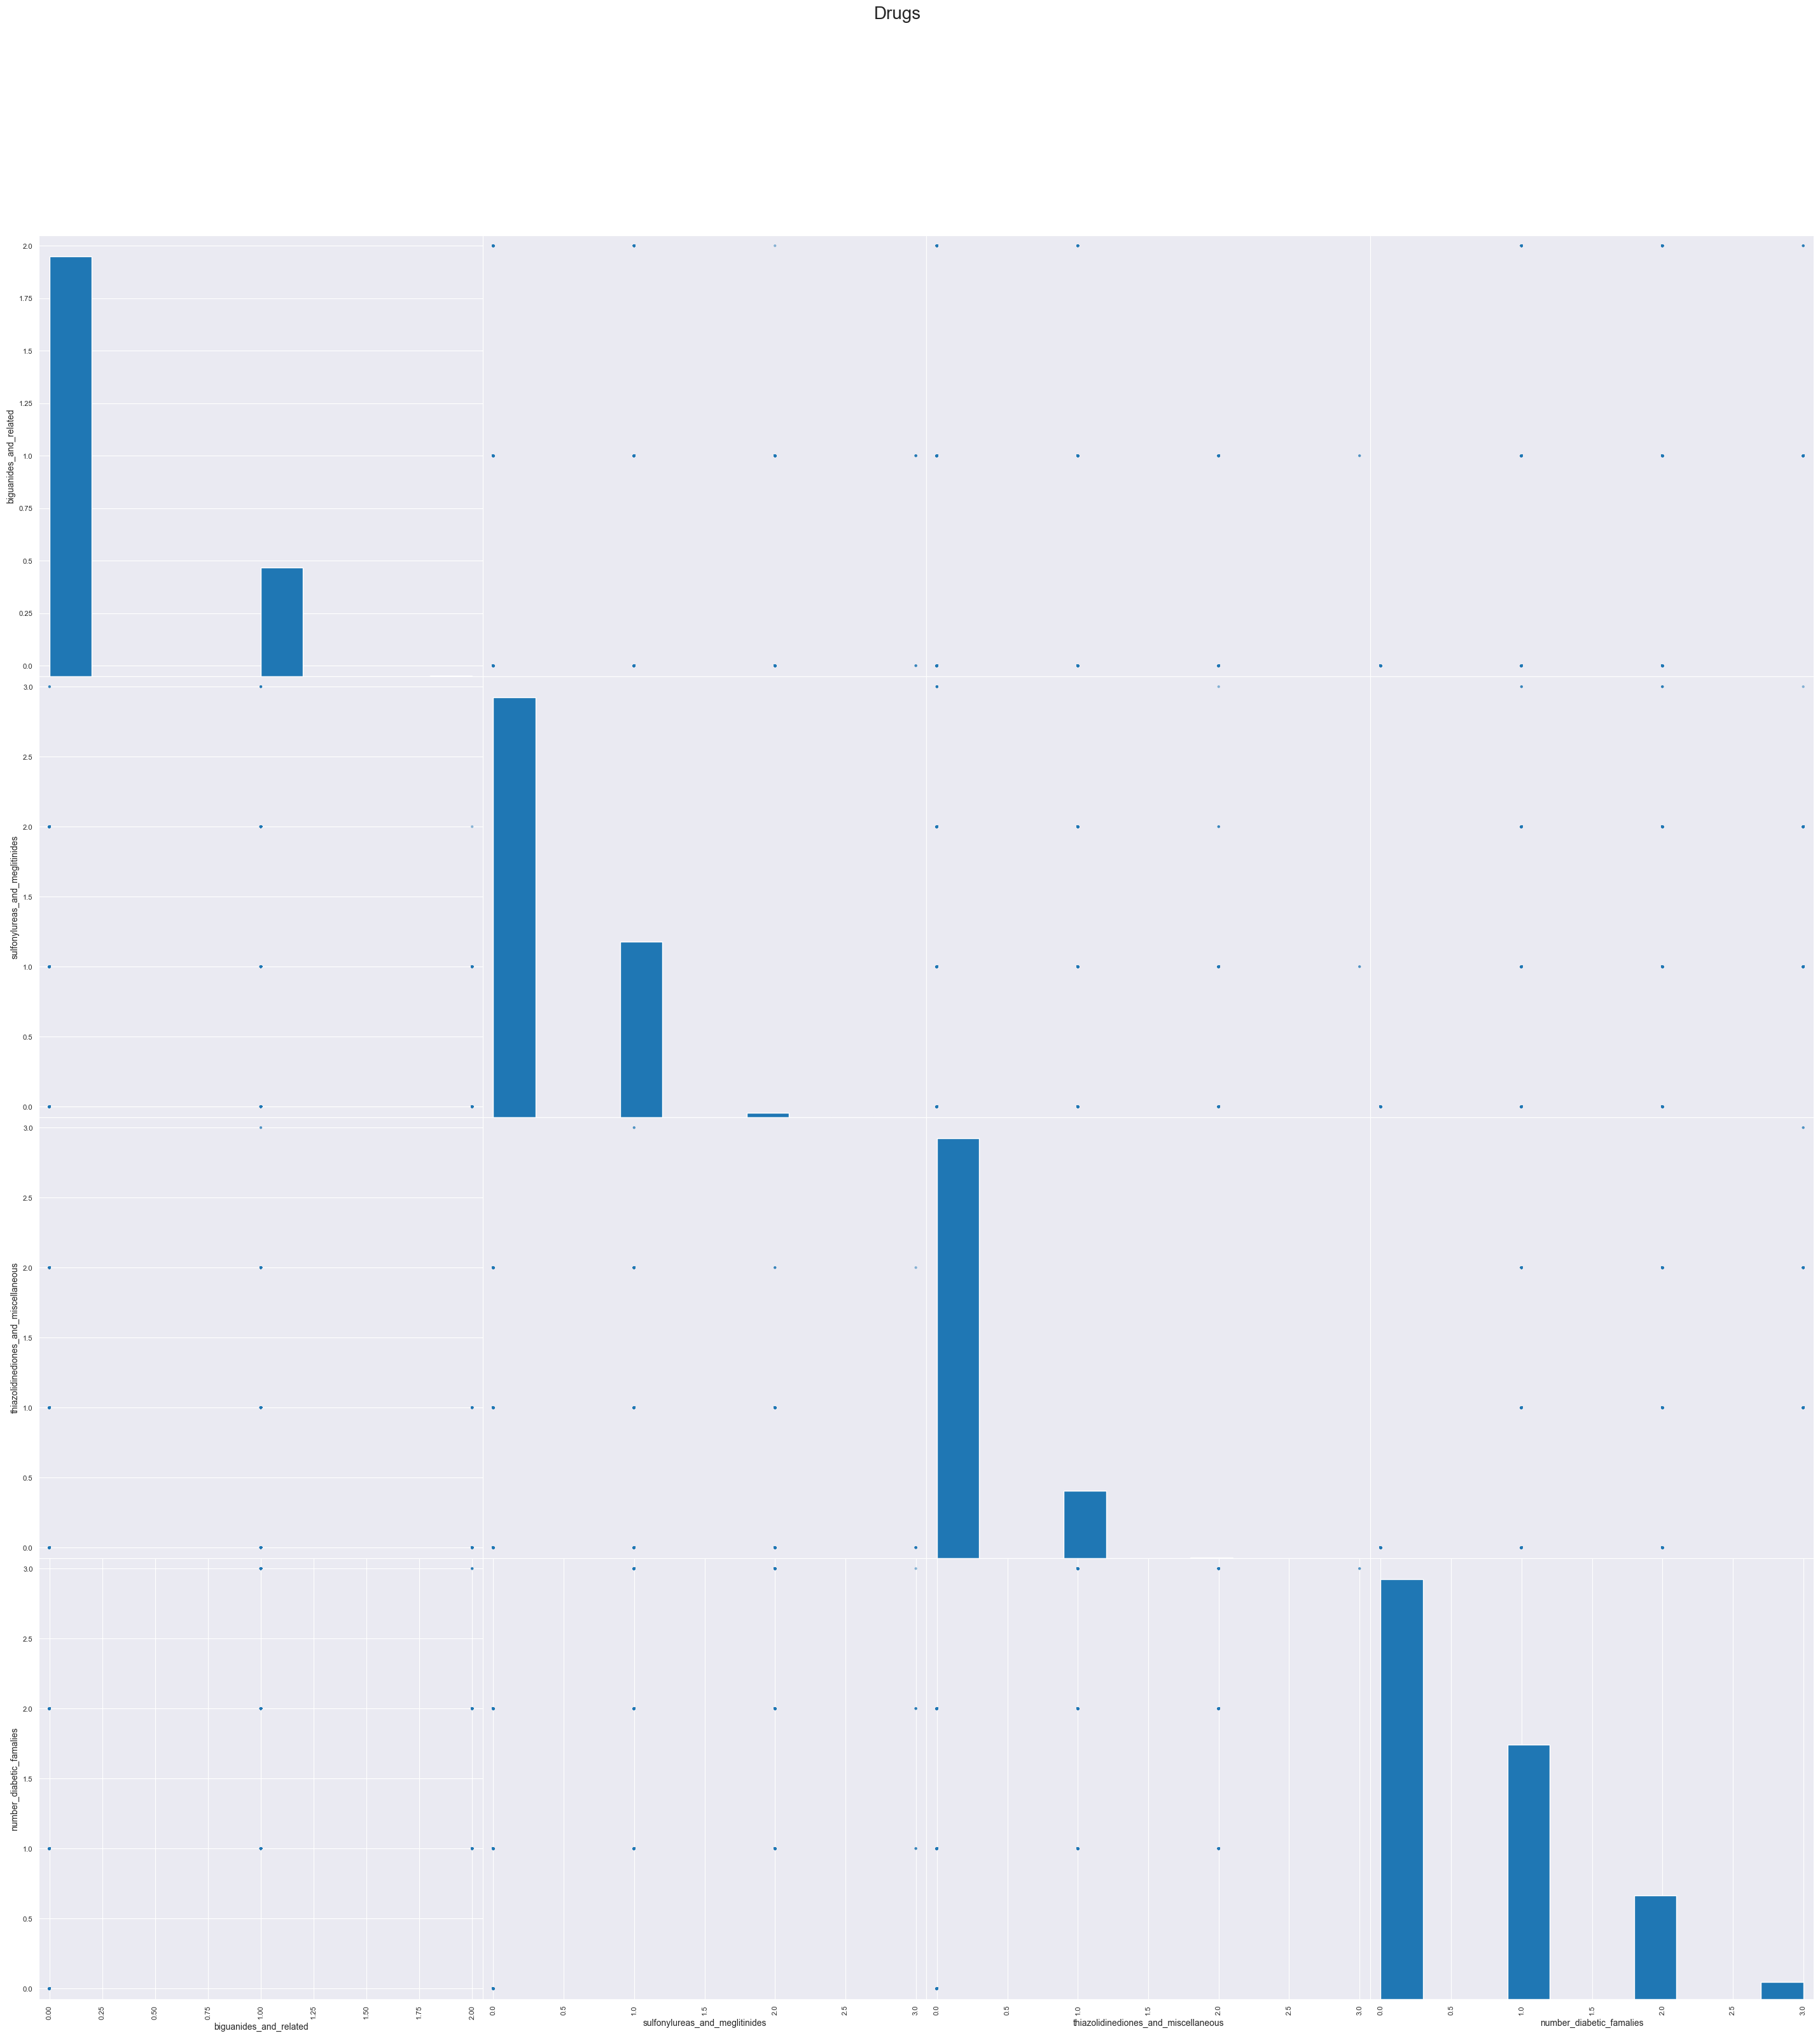

array([[<Axes: xlabel='number_emergency', ylabel='number_emergency'>,
        <Axes: xlabel='number_inpatient', ylabel='number_emergency'>,
        <Axes: xlabel='number_diagnoses', ylabel='number_emergency'>],
       [<Axes: xlabel='number_emergency', ylabel='number_inpatient'>,
        <Axes: xlabel='number_inpatient', ylabel='number_inpatient'>,
        <Axes: xlabel='number_diagnoses', ylabel='number_inpatient'>],
       [<Axes: xlabel='number_emergency', ylabel='number_diagnoses'>,
        <Axes: xlabel='number_inpatient', ylabel='number_diagnoses'>,
        <Axes: xlabel='number_diagnoses', ylabel='number_diagnoses'>]],
      dtype=object)

Text(0.5, 0.98, 'Number_of_hospital_visits')

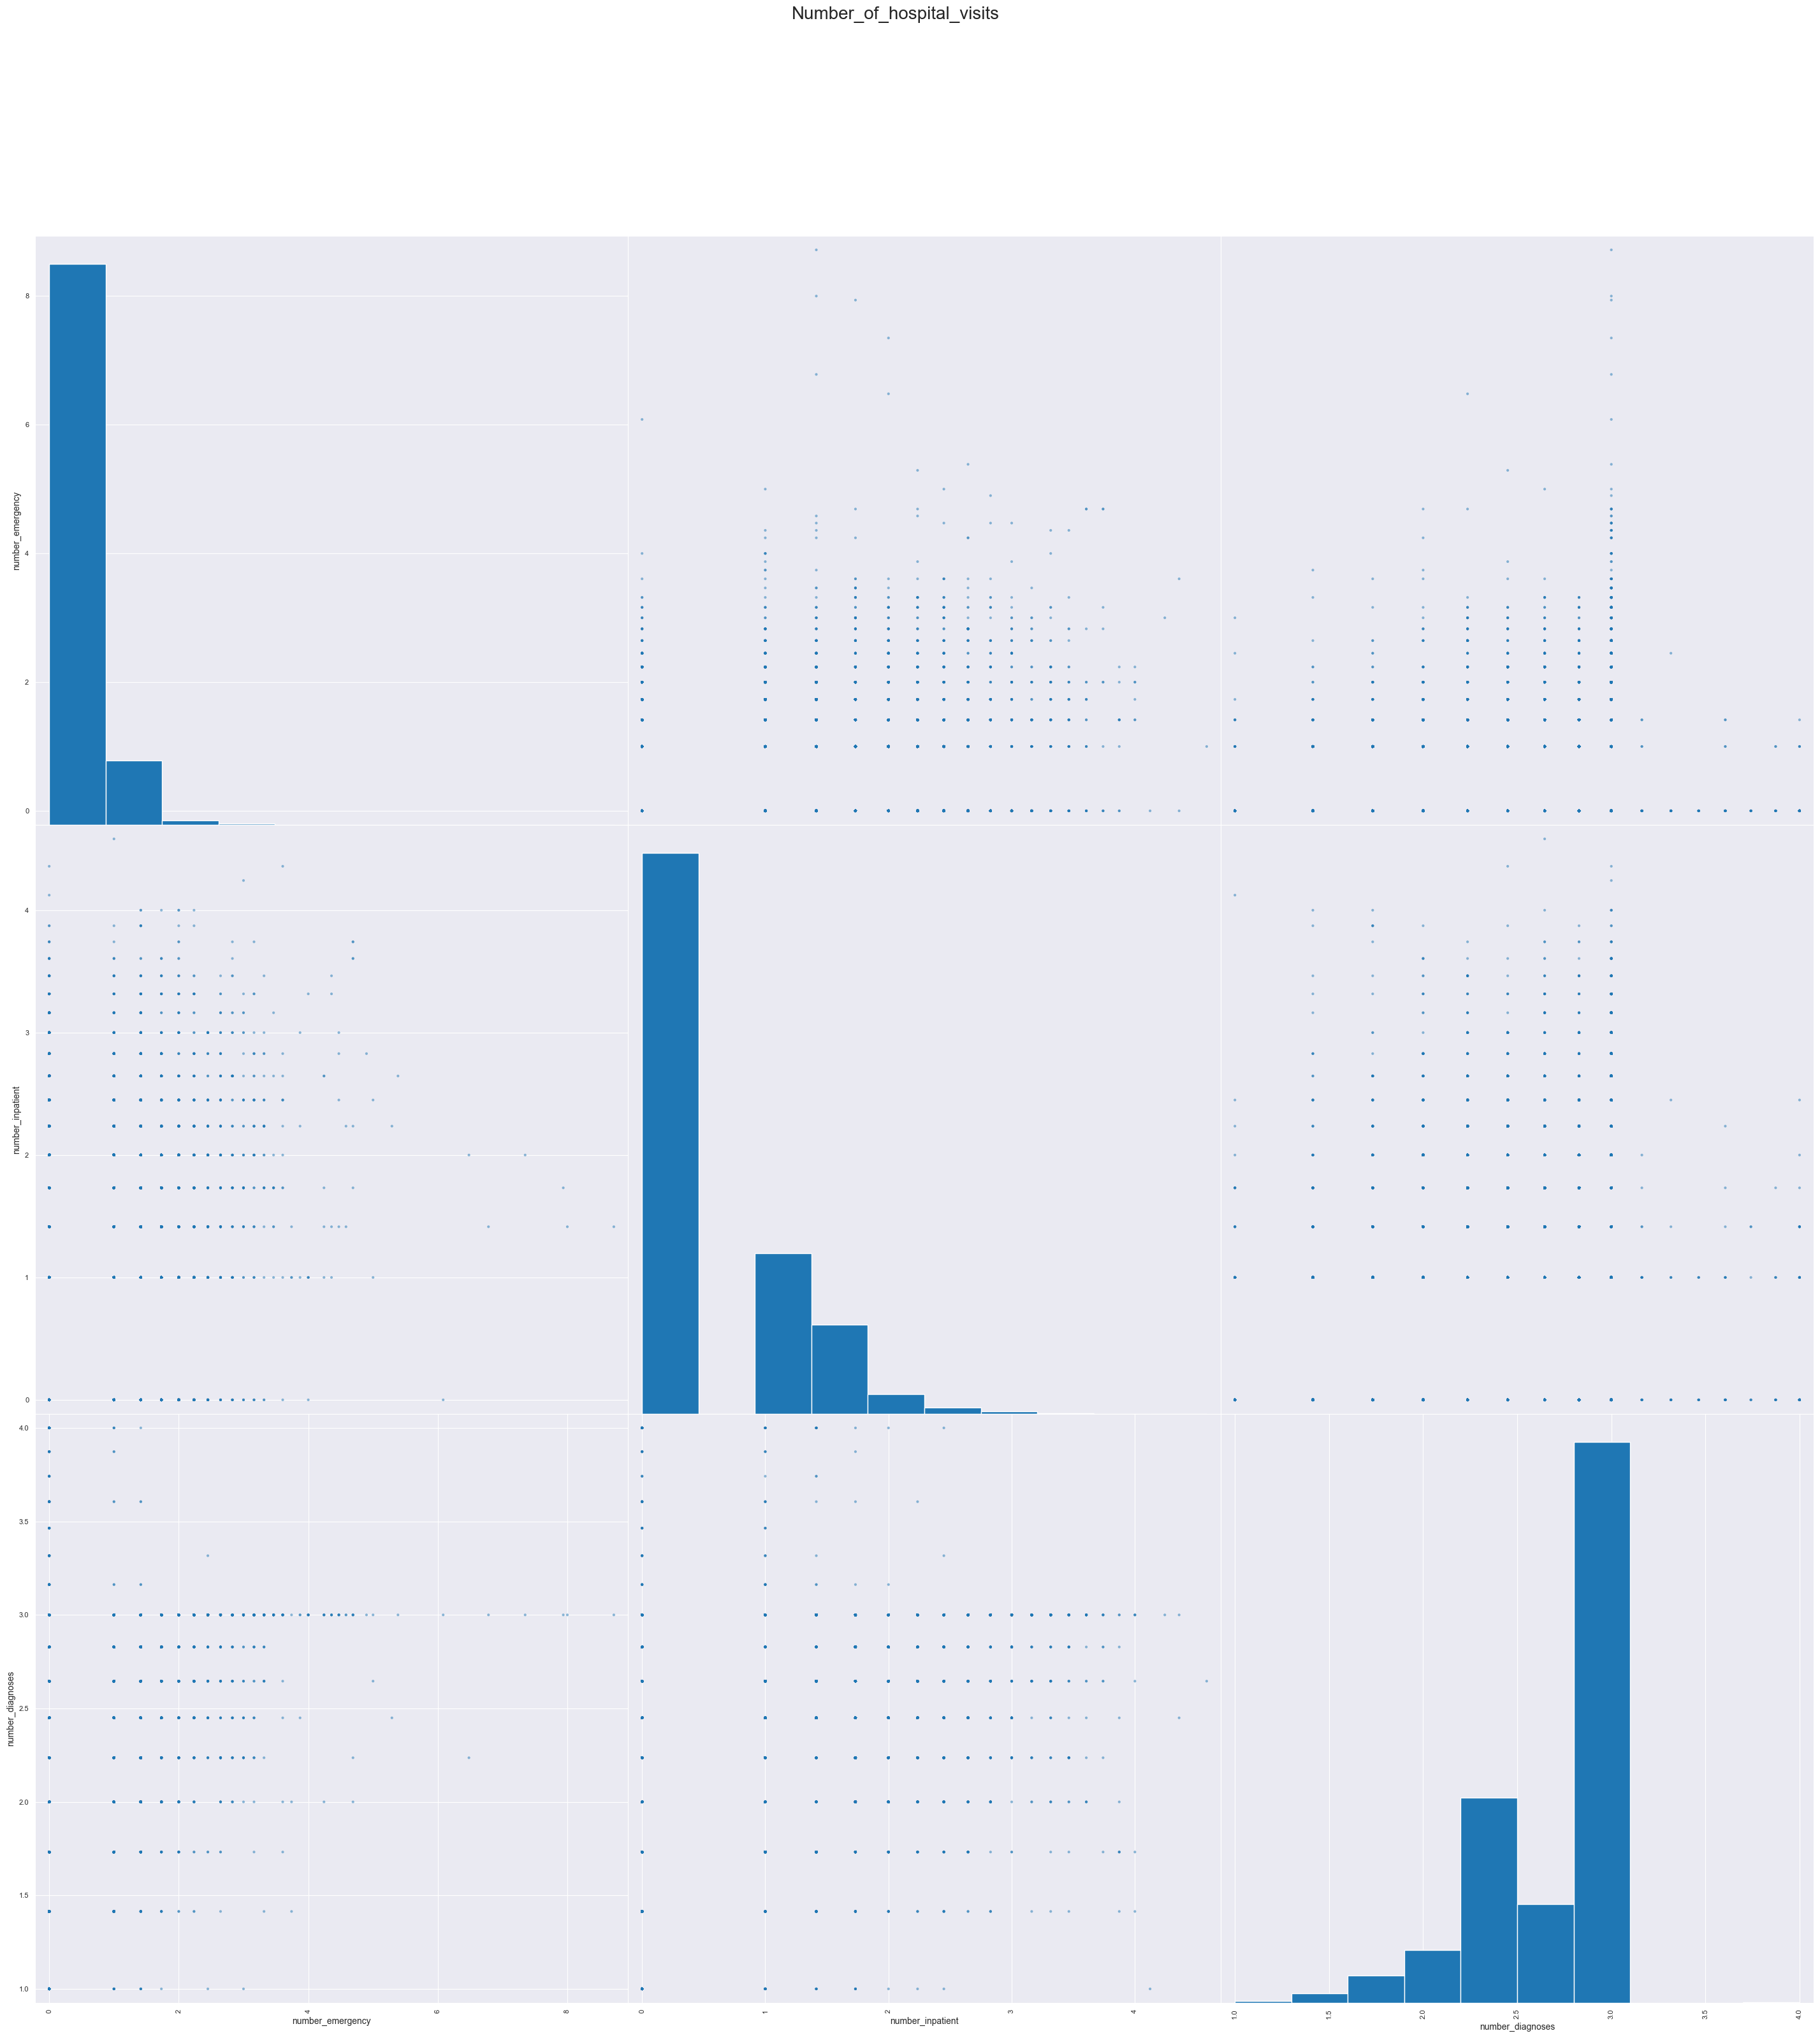

array([[<Axes: xlabel='time_in_hospital', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_lab_procedures', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_procedures', ylabel='time_in_hospital'>,
        <Axes: xlabel='num_medications', ylabel='time_in_hospital'>,
        <Axes: xlabel='number_diagnoses', ylabel='time_in_hospital'>],
       [<Axes: xlabel='time_in_hospital', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_lab_procedures', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_procedures', ylabel='num_lab_procedures'>,
        <Axes: xlabel='num_medications', ylabel='num_lab_procedures'>,
        <Axes: xlabel='number_diagnoses', ylabel='num_lab_procedures'>],
       [<Axes: xlabel='time_in_hospital', ylabel='num_procedures'>,
        <Axes: xlabel='num_lab_procedures', ylabel='num_procedures'>,
        <Axes: xlabel='num_procedures', ylabel='num_procedures'>,
        <Axes: xlabel='num_medications', ylabel='num_procedures'>,
        <Axes: xlab

Text(0.5, 0.98, 'Treatment_in_hospital')

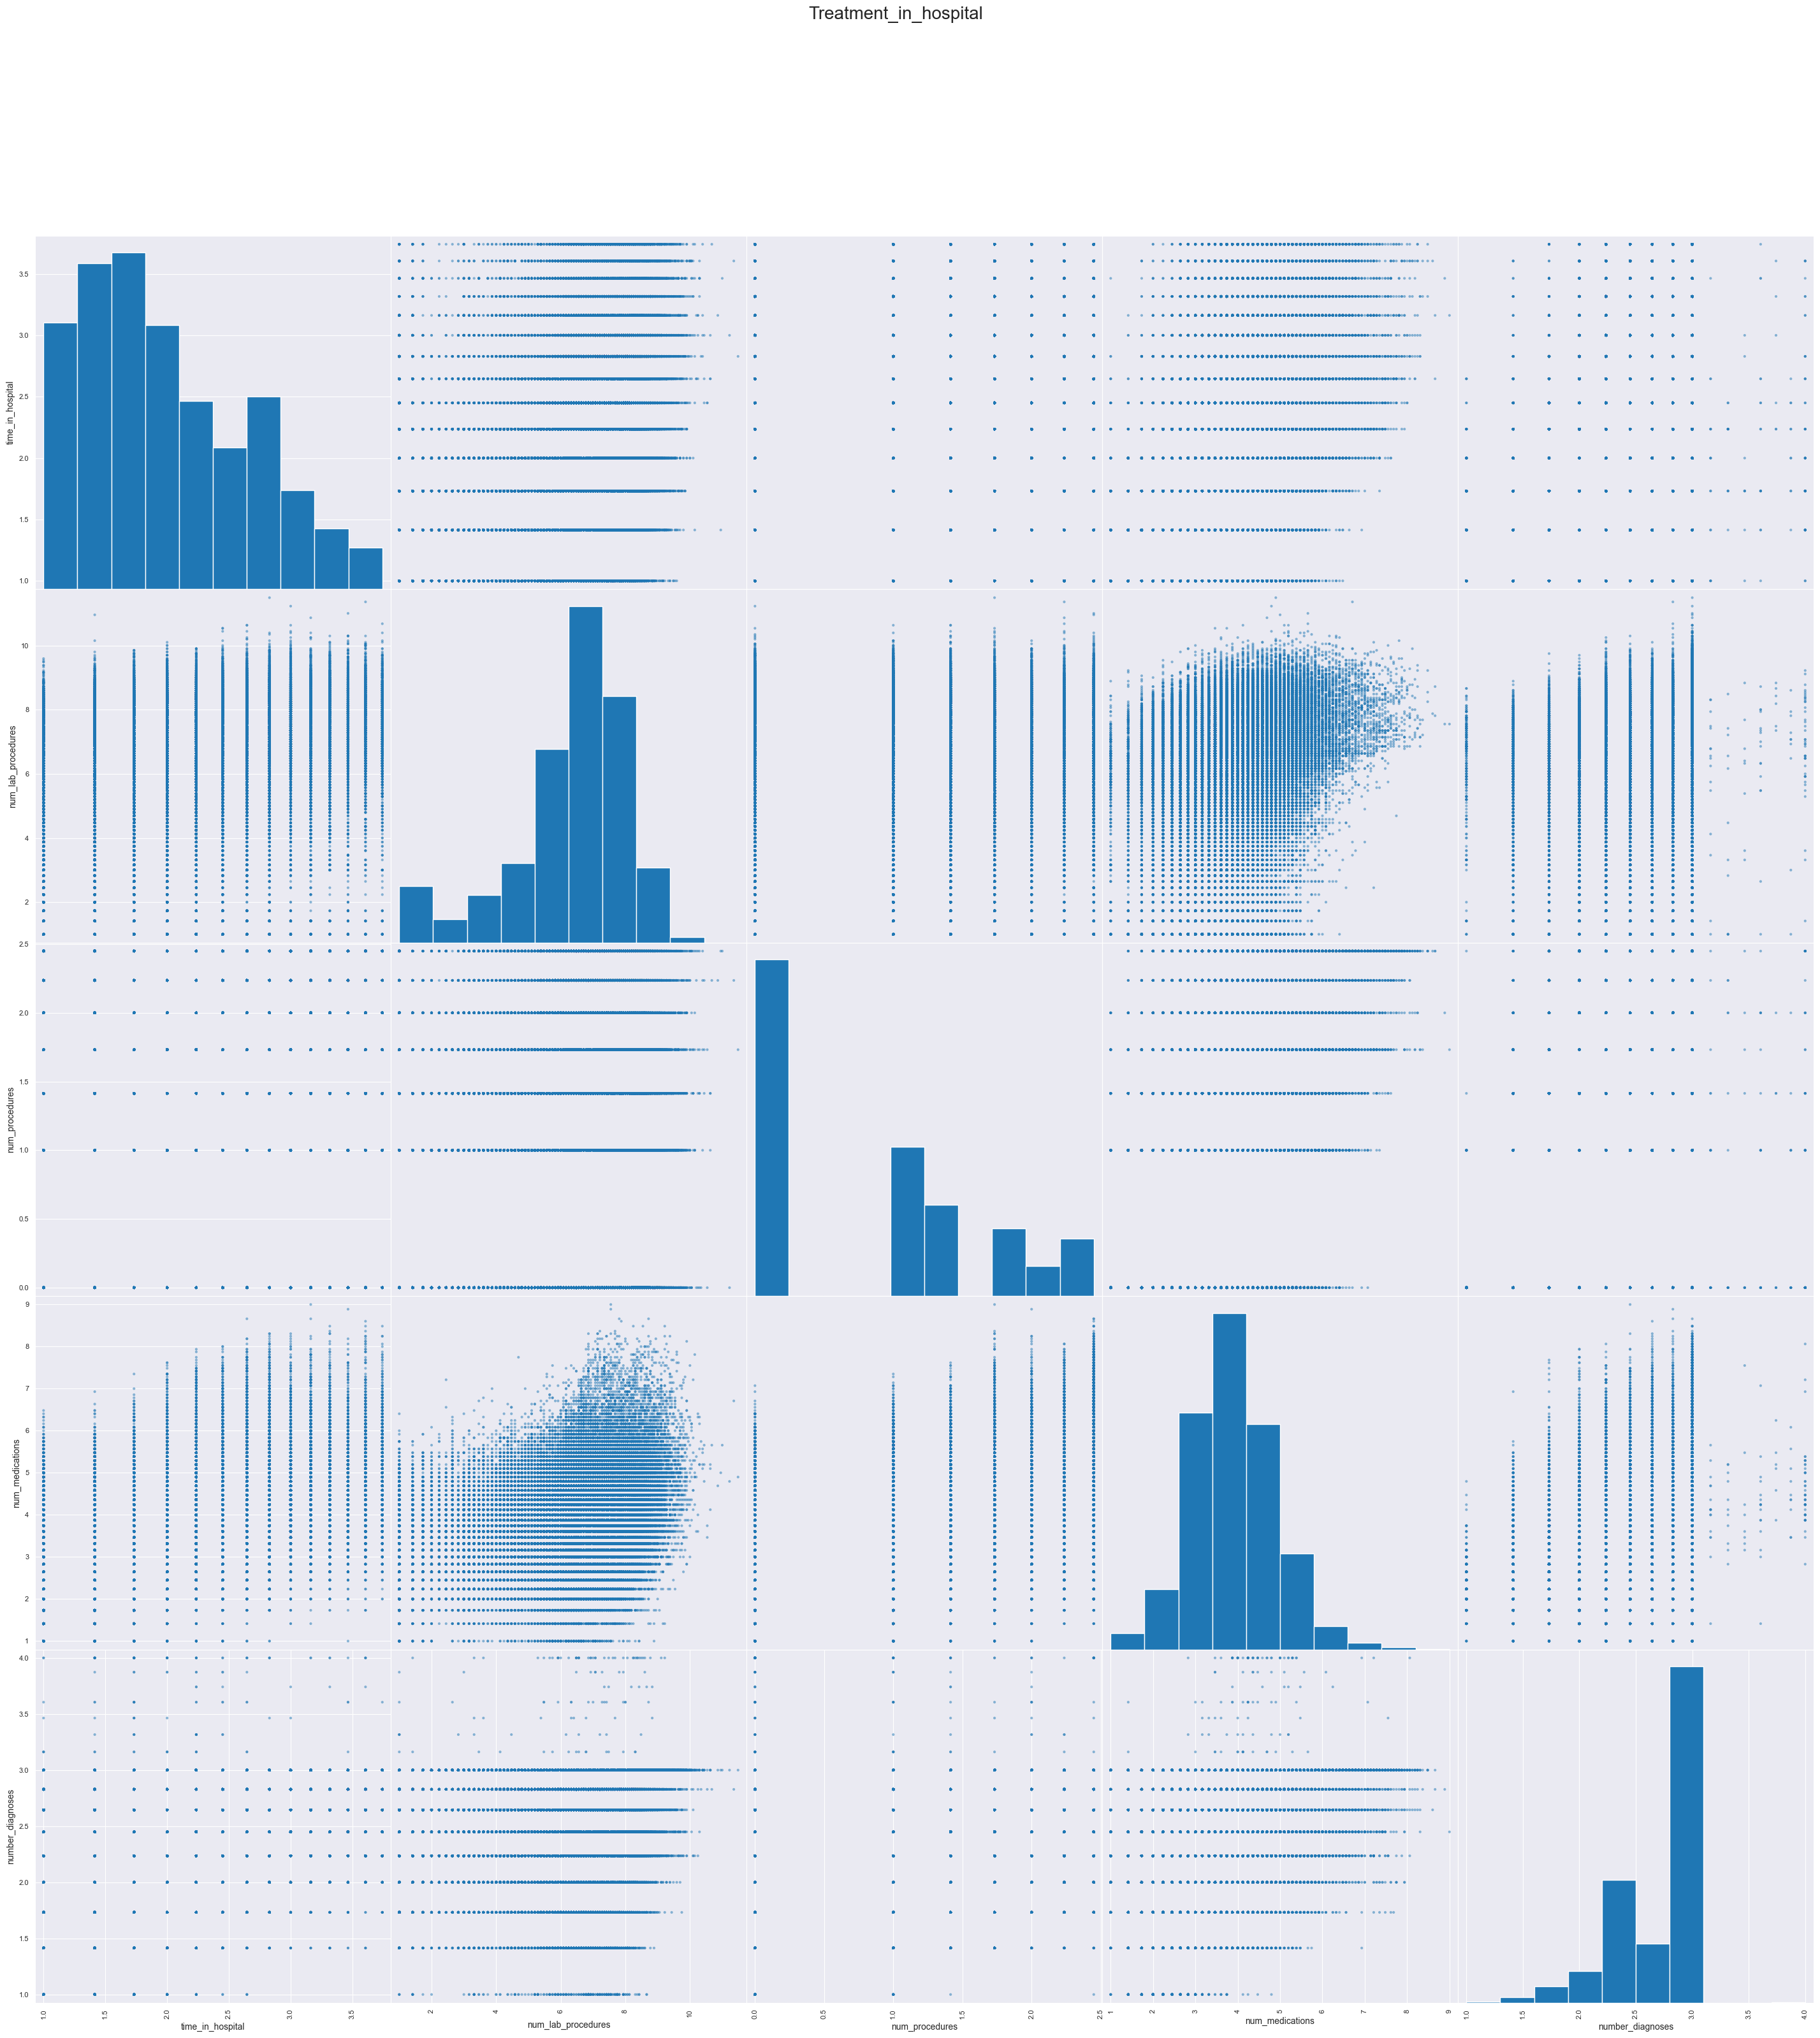

In [424]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Define sub-divisions
subdivisions = {
    'Drugs': ['biguanides_and_related', 'sulfonylureas_and_meglitinides', 'thiazolidinediones_and_miscellaneous', 'number_diabetic_famalies'],
    'Number_of_hospital_visits': ['number_emergency', 'number_inpatient', 'number_diagnoses'],
    'Treatment_in_hospital': ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']
}

# Create scatter matrix plots for each sub-division
for subdivision, columns in subdivisions.items():
    scatter_matrix(df[columns], figsize=(36, 36))
    plt.suptitle(subdivision, fontsize=20)
    plt.show()


In [425]:
# we will use this correlation to reduce the number of features
# 1. summing
# 2. normalize
# need to add

In [7]:
# in this section I am building the pipline
from sklearn.pipeline import Pipeline



lookup_reduse = {
        'readmitted': {
                'YES': ['<30'],
                'NO': ['>30', 'NO']},
        'metformin': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'glyburide-metformin': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'glimepiride-pioglitazone': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'metformin-rosiglitazone': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'repaglinide': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'nateglinide': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'chlorpropamide': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'glimepiride': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'acetohexamide': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'glipizide': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'glyburide': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'tolbutamide': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'pioglitazone': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'rosiglitazone': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'troglitazone': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'acarbose': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'miglitol': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'tolazamide': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'glipizide-metformin': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'metformin-pioglitazone': {
            0: ['No'],
            1: ['Steady', 'Up', 'Down']},
        'discharge_disposition_id':{'home': [1]},
    
        'admission_type_id': {
            'HighPriority': [1, 2],
            'ClinicReferral': [3, 4, 7]},
    
        'race': {'AfricanAmerican':['AfricanAmerican'],
                 'Caucasian':['Caucasian']},
    
        'age': {'<30': ['[0-10)', '[10-20)', '[20-30)'],
               '30<60': ['[30-40)', '[40-50)', '[50-60)'],
               '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']}
    
        'medical_specialty':{"InternalMedicine": ['InternalMedicine'],
                             'Emergency/Trauma': ['Emergency/Trauma'],
                             'Family/GeneralPractice': ['Family/GeneralPractice'],
                             'Cardiology':['Cardiology'],
                              'Surgery-General':[ 'Surgery-General'],
                             'Nephrology':['Nephrology'],
                             'Orthopedics':['Orthopedics']}
                             
                         
                        
        }
    





medical_spec_reduse = dt.CategoryGroupOthers({'medical_specialty': ['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
                              'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics']})

    
        }



lookup_row_drop = {
        'discharge_disposition_id': [11,13,14,19,20,21],
        'gender': ['Unknown/Invalid']
    
}

col_drop = ['weight', 'payer_code']
# dropcolbyvalue = DropColByValue(col_drop)




group_features_lookup  = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "glipizide-metformin", "metformin-pioglitazone"],
    
    "number_diabetic_drugs": [  "biguanides_and_related",  "sulfonylureas_and_meglitinides",  "thiazolidinediones_and_miscellaneous"]
}



numerical_columns = ['time_in_hospital',
                   'num_lab_procedures',
                   'num_procedures',
                   'num_medications',
                  'number_outpatient',
                  'number_emergency',
                  'number_inpatient',
                  'number_diagnoses',
                    'biguanides_and_related',
                    'sulfonylureas_and_meglitinides',
                    'thiazolidinediones_and_miscellaneous',
                     'number_diabetic_drugs'
                    ]





IndentationError: unindent does not match any outer indentation level (<tokenize>, line 134)

In [63]:
pd.unique(df.diag_1)

array(['250.83', '276', '648', '8', '197', '414', '428', '398', '434',
       '250.7', '157', '518', '999', '410', '682', '402', '737', '572',
       'V57', '189', '786', '427', '996', '277', '584', '462', '473',
       '411', '174', '486', '998', '511', '432', '626', '295', '196',
       '250.6', '618', '182', '845', '423', '808', '250.4', '722', '403',
       '250.11', '784', '707', '440', '151', '715', '997', '198', '564',
       '812', '38', '590', '556', '578', '250.32', '433', 'V58', '569',
       '185', '536', '255', '250.13', '599', '558', '574', '491', '560',
       '244', '250.03', '577', '730', '188', '824', '250.8', '332', '562',
       '291', '296', '510', '401', '263', '438', '70', '250.02', '493',
       '642', '625', '571', '738', '593', '250.42', '807', '456', '446',
       '575', '250.41', '820', '515', '780', '250.22', '995', '235',
       '250.82', '721', '787', '162', '724', '282', '514', 'V55', '281',
       '250.33', '530', '466', '435', '250.12', 'V53', '789', '

In [80]:
diag_values = pd.unique(df[['diag_1', 'diag_2', 'diag_3']].melt().value)
diag_values[['E' in value for value in diag_values]]

array(['E909', 'E878', 'E812', 'E932', 'E888', 'E939', 'E937', 'E944',
       'E870', 'E849', 'E950', 'E934', 'E935', 'E915', 'E885', 'E880',
       'E879', 'E890', 'E817', 'E931', 'E924', 'E942', 'E947', 'E930',
       'E858', 'E929', 'E933', 'E900', 'E936', 'E941', 'E884', 'E928',
       'E965', 'E813', 'E814', 'E927', 'E905', 'E917', 'E868', 'E854',
       'E918', 'E850', 'E887', 'E881', 'E829', 'E919', 'E916', 'E819',
       'E826', 'E938', 'E816', 'E906', 'E818', 'E980', 'E853', 'E968',
       'E882', 'E821', 'E945', 'E883', 'E949', 'E920', 'E956', 'E904',
       'E943', 'E861', 'E852', 'E876', 'E855', 'E815', 'E822', 'E894',
       'E828', 'E865', 'E946', 'E966', 'E922', 'E901', 'E892', 'E886',
       'E987', 'E912', 'E955', 'E864', 'E825'], dtype=object)

In [16]:
diag_values

array(['250.83', '276', '648', '8', '197', '414', '428', '398', '434',
       '250.7', '157', '518', '999', '410', '682', '402', '737', '572',
       'V57', '189', '786', '427', '996', '277', '584', '462', '473',
       '411', '174', '486', '998', '511', '432', '626', '295', '196',
       '250.6', '618', '182', '845', '423', '808', '250.4', '722', '403',
       '250.11', '784', '707', '440', '151', '715', '997', '198', '564',
       '812', '38', '590', '556', '578', '250.32', '433', 'V58', '569',
       '185', '536', '255', '250.13', '599', '558', '574', '491', '560',
       '244', '250.03', '577', '730', '188', '824', '250.8', '332', '562',
       '291', '296', '510', '401', '263', '438', '70', '250.02', '493',
       '642', '625', '571', '738', '593', '250.42', '807', '456', '446',
       '575', '250.41', '820', '515', '780', '250.22', '995', '235',
       '250.82', '721', '787', '162', '724', '282', '514', 'V55', '281',
       '250.33', '530', '466', '435', '250.12', 'V53', '789', '

In [22]:
['E' in str(value) for value in diag_values]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [63]:
from sklearn.pipeline import Pipeline

diag_values = pd.unique(df[['diag_1', 'diag_2', 'diag_3']].melt().value)
diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000),
             18: diag_values[['E' in str(value) for value in diag_values]],
             19: diag_values[['V' in str(value) for value in diag_values]]}

# diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

lookup_reduse = {
    'diag_1': diag_dict,
    'diag_2': diag_dict,
    'diag_3': diag_dict,
    
    'readmitted': {
        'YES': ['<30'],
        'NO': ['>30', 'NO']
    },
    'metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glyburide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glimepiride-pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'metformin-rosiglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'repaglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'nateglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'chlorpropamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glimepiride': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acetohexamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glipizide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glyburide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'tolbutamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'rosiglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'troglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acarbose': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'miglitol': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'tolazamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glipizide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'metformin-pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'discharge_disposition_id': {
        'home': [1]
    },
    'admission_type_id': {
        'HighPriority': [1, 2],
        'ClinicReferral': [3, 4, 7]
    },
    'race': {
        'AfricanAmerican': ['AfricanAmerican'],
        'Caucasian': ['Caucasian']
    },
    'age': {
        '<30': ['[0-10)', '[10-20)', '[20-30)'],
        '30<60': ['[30-40)', '[40-50)', '[50-60)'],
        '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']
    },
    'medical_specialty': {
        "InternalMedicine": ['InternalMedicine'],
        'Emergency/Trauma': ['Emergency/Trauma'],
        'Family/GeneralPractice': ['Family/GeneralPractice'],
        'Cardiology': ['Cardiology'],
        'Surgery-General': ['Surgery-General'],
        'Nephrology': ['Nephrology'],
        'Orthopedics': ['Orthopedics']
    }
}

medical_spec_reduse = dt.CategoryGroupOthers({'medical_specialty': ['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
                              'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics']})

lookup_row_drop = {
    'discharge_disposition_id': [11, 13, 14, 19, 20, 21],
    'gender': ['Unknown/Invalid']
}

col_drop = ['weight', 'payer_code']



group_features_lookup = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "glipizide-metformin", "metformin-pioglitazone"],
    "number_diabetic_drugs": ["biguanides_and_related", "sulfonylureas_and_meglitinides", "thiazolidinediones_and_miscellaneous"]
}

numerical_columns = ['time_in_hospital',
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'biguanides_and_related',
                     'sulfonylureas_and_meglitinides',
                     'thiazolidinediones_and_miscellaneous',
                     'number_diabetic_drugs'
                    ]

columns_to_check_duplicates = ['patient_nbr']

In [11]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
# Define your custom transformers here


class ChangeValueToValue(BaseEstimator, TransformerMixin):
    def __init__(self, value_from: str | int , value_to: str | int, **kwargs) -> None:
        self.value_from = value_from
        self.value_to = value_to

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[X_copy == self.value_from] = self.value_to
        return X_copy

class NanToMissing(BaseEstimator, TransformerMixin):
    def __init__(self, missing_value="missing"):
        self.missing_value = missing_value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Replace the imputed value with "MISSING"
        X_copy[X_copy.isnull()] = self.missing_value
        return X_copy


class CategoryReducer(BaseEstimator, TransformerMixin):
    def __init__(self, lookup: dict[str, dict[str, list]], **kwargs):
        self.lookup = lookup

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for feature, feature_lookup in self.lookup.items():
            for change_to, change_from_list in feature_lookup.items():
                X_copy.loc[X_copy[feature].isin(change_from_list), feature] = change_to

            if 'other' not in feature_lookup.keys():
    
                X_copy.loc[~X_copy[feature].isin(feature_lookup.keys()), feature] = 'other'
        return X_copy


class DropRowsByValue(BaseEstimator, TransformerMixin):
    def __init__(self, lookup: dict[str, list], inplace=True, **kwargs):
        self.lookup = lookup
        self.inplace = inplace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for feature, value_to_drop in self.lookup.items():
            X_copy = X_copy[~X_copy[feature].isin(value_to_drop)]
        return X_copy


class DropColByValue(BaseEstimator, TransformerMixin):
    def __init__(self, lookup: list, inplace=True, **kwargs):
        self.lookup = lookup
        self.inplace = inplace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(columns=self.lookup, errors='ignore')
        return X_copy


class DropColWithLowVarious(BaseEstimator, TransformerMixin):
    def __init__(self, various_threshold: int = 100, inplace=True, **kwargs):
        self.various_threshold = various_threshold
        self.inplace = inplace

    def unique_values_and_ratio(self, X):
        unique_counts = X.nunique()
        most_common_ratios = ((X == X.mode().values).sum() / len(X)) * 100
        self.common_ratio_df = pd.DataFrame({"Unique Values": unique_counts, "Most Common Ratio": most_common_ratios})

    def fit(self, X, y=None):
        self.unique_values_and_ratio(X)
        self.columns_to_drop = self.common_ratio_df[self.common_ratio_df['Most Common Ratio'] >= self.various_threshold].index
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(columns=self.columns_to_drop, errors='ignore')
        return X_copy


class GroupCategoriesUsinValues(BaseEstimator, TransformerMixin):
    def __init__(self, lookup: dict[str, list], mode: str = 'sum', inplace=True, **kwargs):
        self.lookup = lookup
        self.mode_str = mode
        self.mode = getattr(np, mode, np.sum)
        self.inplace = inplace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for new_feature, old_features in self.lookup.items():
            try:
                # Try calculating mode for all old_features
                X_copy[new_feature] = self.mode(X_copy[old_features], axis=1).astype(float)
            except KeyError as e:
                # Remove missing keys and recalculate mode
                missing_key = e.args[0]
                print(missing_key)
                old_features = [feature for feature in old_features if feature != missing_key]
                X_copy[new_feature] = self.mode(X_copy[old_features], axis=1).astype(float)
                
            # Drop all old_features (including any removed missing keys) this is on hold for now
            # X_copy = X_copy.drop(columns=old_features, errors='ignore')
        
        return X_copy





class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method='RobustScaler', numerical_columns=None, **kwargs):
        self.method = method
        self.numerical_columns = numerical_columns
        self.kwargs = kwargs
        self.scaler = None

    def fit(self, X, y=None):
        if self.method == 'RobustScaler':
            self.scaler = RobustScaler(**self.kwargs)
        elif self.method == 'StandardScaler':
            self.scaler = StandardScaler(**self.kwargs)
        elif self.method == 'NoTransform':
            self.scaler = NoTransform()
        else:
            raise ValueError("Unsupported method. Choose one of: 'RobustScaler', 'StandardScaler', or 'NoTransform'.")
        
        try:
            self.scaler.fit(X[self.numerical_columns])
        except KeyError as e:
            missing_column = str(e).strip('\'')
            try:
                self.numerical_columns.remove(missing_column)
            except ValueError:
                pass  # Column is already removed
            return self.fit(X)
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numerical_columns] = self.scaler.transform(X_copy[self.numerical_columns])
        return X_copy

class SkewFixTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=0.5, method='PowerTransformer', numerical_columns=None, **kwargs):
        self.skew_threshold = skew_threshold
        self.method = method
        self.numerical_columns = numerical_columns
        self.kwargs = kwargs
        self.skewed_columns = []
        self.transformer = None
        self.box_cox_addition = None

    def fit(self, X, y=None):
        self.skewed_columns = []
        for col in self.numerical_columns:
            col_skew = skew(X[col].dropna())  # Calculate skewness
            if np.abs(col_skew) > self.skew_threshold:
                self.skewed_columns.append(col)
        
        if self.method == 'PowerTransformer':
            self.transformer = PowerTransformer(**self.kwargs)
        elif self.method == 'QuantileTransformer':
            self.transformer = QuantileTransformer(output_distribution='normal', **self.kwargs)
        elif self.method == 'LogTransformer':
            self.transformer = LogTransformer()
        elif self.method == 'BoxCoxTransformer':
            self.box_cox_addition = X[numerical_columns].min()
            self.transformer = PowerTransformer(method='box-cox')
        elif self.method == 'NoTransform':
            self.transformer = NoTransform()
        else:
            raise ValueError("Unsupported method. Choose one of: 'PowerTransformer', 'QuantileTransformer', 'LogTransformer', 'BoxCoxTransformer', or 'NoTransform'.")
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.skewed_columns:
            try:
                X_copy[col] = self.transformer.fit_transform(X_copy[col].values.reshape(-1, 1))
            except ValueError:
                 X_copy[col] = X_copy[col] - self.box_cox_addition[col]
                 X_copy[col] = self.transformer.fit_transform(X_copy[col].values.reshape(-1, 1))
        return X_copy

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log1p(X)

class NoTransform(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X




from scipy.stats import rankdata

class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer='RankGaussTransformer', lower_quantile=0.05, upper_quantile=0.95):
        self.transformer_name = transformer
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.transformer = None

    def fit(self, X, y=None):
        # Get the numerical columns
        self.numerical_columns = X.select_dtypes(include=np.number).columns
        
        if self.transformer_name == 'RankGaussTransformer':
            self.transformer = RankGaussTransformer()
        elif self.transformer_name == 'Winsorizer':
            self.transformer = Winsorizer(lower_quantile=self.lower_quantile, upper_quantile=self.upper_quantile)
        elif self.transformer_name == 'NoTransform':
            self.transformer = NoTransform()
        else:
            raise ValueError("Unsupported transformer. Choose either 'RankGaussTransformer' or 'Winsorizer'.")
        
        # Fit only on numerical columns
        self.transformer.fit(X[self.numerical_columns])
        return self

    def transform(self, X):
        # Transform only the numerical columns
        X_transformed = X.copy()
        X_transformed[self.numerical_columns] = self.transformer.transform(X[self.numerical_columns])
        return X_transformed


class RankGaussTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_rank = np.apply_along_axis(rankdata, 0, X)
        X_rank /= X_rank.max()
        X_rank -= 0.5
        return np.arcsin(X_rank)

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.lower_bound = None
        self.upper_bound = None

    def fit(self, X, y=None):
        self.lower_bound = np.quantile(X, self.lower_quantile, axis=0)
        self.upper_bound = np.quantile(X, self.upper_quantile, axis=0)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for i in range(X_copy.shape[1]):
            X_copy.iloc[:, i] = np.where(X_copy.iloc[:, i] < self.lower_bound[i], self.lower_bound[i], X_copy.iloc[:, i])
            X_copy.iloc[:, i] = np.where(X_copy.iloc[:, i] > self.upper_bound[i], self.upper_bound[i], X_copy.iloc[:, i])
        return X_copy




class ObjectToCategoryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in X_transformed.columns:
            if X_transformed[col].dtype == 'object' or 'ID' in col.upper() or 'DIAG_' in col.upper():
                X_transformed[col] = X_transformed[col].astype('str')
                X_transformed[col] = X_transformed[col].astype('category')
        return X_transformed

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.base import BaseEstimator, TransformerMixin


# ___________________________________________________________________________________________________________________

class DropDuplicatesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_check_duplicates=None, keep='first'):
        self.columns_to_check_duplicates = columns_to_check_duplicates
        self.keep = keep
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns_to_check_duplicates is None:
            return X
        X_transformed = X.copy()
        X_transformed = X_transformed.drop_duplicates(subset=self.columns_to_check_duplicates, keep=self.keep)
        return X_transformed


def instantiate_DropDuplicatesTransformer(trial: optuna.Trial) -> DropDuplicatesTransformer:
    drop_duplicates = trial.suggest_categorical('drop_duplicates', [True, False])
    if drop_duplicates:
        keep = trial.suggest_categorical('keep', ['first', 'last', False])
        columns_to_check_duplicates = ['patient_nbr']
    else:
        keep = 'first'
        columns_to_check_duplicates = None
    return DropDuplicatesTransformer(columns_to_check_duplicates=columns_to_check_duplicates, keep=keep)

# ____________________________________________________________________________________________________________________


class DropRowsByValue(BaseEstimator, TransformerMixin):
    def __init__(self, lookup: dict[str, list], inplace=True, **kwargs):
        self.lookup = lookup
        self.inplace = inplace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for feature, value_to_drop in self.lookup.items():
            X_copy = X_copy[~X_copy[feature].isin(value_to_drop)]
        return X_copy


# ______________________________________________________________________________________________________________________

def instantiate_TransformerLookup(trial: optuna.Trial, lookup, transformer, **kwargs):
# select whether to drop each category specified in the lookup dictionary. 
    # Choose one or more categories to drop from the lookup values
    if type(lookup) == dict:
        categories_to_drop = []
        values_to_drop = []
        for key, values in lookup.items():
            if  trial.suggest_categorical(f'TransformerLookup_{str(transformer)}_{str(key)}', [True, False]):
                categories_to_drop.append(key)
                values_to_drop.append(values)
        new_lookup = {category: values_to_drop[index] for index, category in enumerate(categories_to_drop)}
    
    elif type(lookup) == list:
        new_lookup = []
        for value in lookup:
            if trial.suggest_categorical(f'TransformerLookup_{str(transformer)}_{str(value)}', [True, False]):
                new_lookup.append(value)
    
    # Create the DropRowsByValue transformer instance
    return transformer(lookup=new_lookup, **kwargs)
# _____________________________________________



def instantiate_DropColWithLowVarious(trial: optuna.Trial) -> DropColWithLowVarious:
    various_threshold = trial.suggest_int('various_threshold', 1, 100)
    return DropColWithLowVarious(various_threshold=various_threshold)

def instantiate_GroupCategoriesUsinValues(trial: optuna.Trial, lookup) -> GroupCategoriesUsinValues:
    # Define your group features lookup here or pass it as an argument
    mode = trial.suggest_categorical('mode', ['sum', 'mean', 'median'])  # Choose mode
    return GroupCategoriesUsinValues(lookup=group_features_lookup, mode=mode)

def instantiate_SkewFixTransformer(trial: optuna.Trial, numerical_columns=numerical_columns) -> SkewFixTransformer:
    new_lookup = []
    for value in numerical_columns:
        if trial.suggest_categorical(f'skefix_{str(value)}', [True, False]):
            new_lookup.append(value)

    skew_threshold = trial.suggest_float('skew_threshold', -3.0, 3.0)
    method_type = trial.suggest_categorical('method', ['PowerTransformer', 'QuantileTransformer', 'LogTransformer', 'BoxCoxTransformer', 'NoTransform'])
    return SkewFixTransformer(skew_threshold=skew_threshold, method=method_type, numerical_columns=new_lookup)

def instantiate_ScalerTransformer(trial: optuna.Trial, numerical_columns=numerical_columns) -> ScalerTransformer:
    new_lookup = []
    for value in numerical_columns:
        if trial.suggest_categorical(f'ScalerTransforme_{str(value)}', [True, False]):
            new_lookup.append(value)

    method_choices = ['RobustScaler', 'StandardScaler', 'NoTransform']
    method_type = trial.suggest_categorical('method_type', method_choices)
        
    return ScalerTransformer(method=method_type, numerical_columns=new_lookup)

def instantiate_OutlierTransformer(trial: optuna.Trial) -> OutlierTransformer:
    transformer = trial.suggest_categorical('transformer', ['RankGaussTransformer', 'Winsorizer', 'NoTransform'])
    lower_quantile = trial.suggest_float('lower_quantile', 0, 0.5)
    upper_quantile = trial.suggest_float('upper_quantile', 0.5, 1)
    return OutlierTransformer(transformer=transformer, lower_quantile=lower_quantile, upper_quantile=upper_quantile)





def instantiate_data(trial: Trial, lookup_row_drop: dict[str, list] = lookup_row_drop, lookup_reduse=lookup_reduse, col_drop=col_drop, group_features_lookup=group_features_lookup, numerical_columns=numerical_columns) -> Pipeline:
    pipeline = Pipeline([
        ('?_to_missing', ChangeValueToValue('?', 'missing')),
        ('nan_to_missing', NanToMissing()),
        ('drop_duplications', instantiate_DropDuplicatesTransformer(trial)),
        ('droprowbyvalues', instantiate_TransformerLookup(trial, lookup=lookup_row_drop, transformer=DropRowsByValue)),
        ('categoryreducer', instantiate_TransformerLookup(trial, lookup=lookup_reduse, transformer=CategoryReducer)),
        ('dropcolbyvalue', instantiate_TransformerLookup(trial, lookup=col_drop, transformer=DropColByValue)),
        ('drop_low_various', instantiate_DropColWithLowVarious(trial)),
        ('group_features_lookup', instantiate_GroupCategoriesUsinValues(trial, lookup=group_features_lookup)),
        ('skew_fix', instantiate_SkewFixTransformer(trial, numerical_columns=numerical_columns)),
        ('scaler', instantiate_ScalerTransformer(trial, numerical_columns=numerical_columns)),
        ('outlier_transformer', instantiate_OutlierTransformer(trial)),
        ('object_to_catagory', ObjectToCategoryTransformer()),   
    ])
    return pipeline




# Define your pipeline
pipeline = Pipeline([
    ('?_to_missing', ChangeValueToValue('?', 'missing')),
    ('nan_to_missing', NanToMissing()),
    ('dropduplications', DropDuplicatesTransformer(columns_to_check_duplicates=columns_to_check_duplicates, keep='first')),
    ('droprowbyvalues', DropRowsByValue(lookup=lookup_row_drop)),
    ('categoryreducer', CategoryReducer(lookup=lookup_reduse)),
    ('dropcolbyvalue', DropColByValue(lookup=col_drop)),
    ('drop_high_various', DropColWithLowVarious(various_threshold=100)),
    ('group_features_lookup', GroupCategoriesUsinValues(lookup=group_features_lookup, mode='sum')),
    ('skew_fix', SkewFixTransformer(skew_threshold=0.5, method='PowerTransformer', numerical_columns=numerical_columns)),
    ('scaler', ScalerTransformer(method='RobustScaler', numerical_columns=numerical_columns)),
    ('outlier_transformer', OutlierTransformer(transformer='Winsorizer', lower_quantile=0.05, upper_quantile=0.95)),
    ('object_to_catagory', ObjectToCategoryTransformer()),
    
])

# Fit and transform your DataFrame
transformed_df = pipeline.fit_transform(df)
transformed_df


NameError: name 'optuna' is not defined

In [496]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69970 entries, 2278392 to 443867222
Data columns (total 51 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   patient_nbr                           69970 non-null  float64 
 1   race                                  69970 non-null  category
 2   gender                                69970 non-null  category
 3   age                                   69970 non-null  category
 4   admission_type_id                     69970 non-null  category
 5   discharge_disposition_id              69970 non-null  category
 6   admission_source_id                   69970 non-null  category
 7   time_in_hospital                      69970 non-null  float64 
 8   medical_specialty                     69970 non-null  category
 9   num_lab_procedures                    69970 non-null  float64 
 10  num_procedures                        69970 non-null  float64 
 1

In [509]:
def instantiate_catboost_classifier(trial: optuna.Trial, X, verbose=False) -> CatBoostClassifier:
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 100.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.0, 100.0),
        'iterations': trial.suggest_int('iterations', 100, 1000),   
    }
    params[ 'early_stopping_rounds'] = trial.suggest_int('early_stopping_rounds', 0, params['iterations'])
    
    cat_indices = X.select_dtypes(include=['category', 'object']).columns.tolist()
    return CatBoostClassifier(cat_features=cat_indices,  verbose=verbose, **params)




def instantiate_model(trial : Trial, X_train,) -> Pipeline:
  
    preprocessor = instantiate_data(trial)

    X_train = preprocessor.fit(X_train)
    
    catboost_m = instantiate_catboost_classifier(trial, verbose=True, X=X_train)

  
    model = Pipeline([
    # ('preprocessor', preprocessor),
    ('catboost', catboost_m)
    ])
    
    return model


from typing import Optional
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, make_scorer
from pandas import DataFrame, Series
import numpy as np

def objective(trial : Trial, X : DataFrame, y : np.ndarray | Series, random_state : int=42) -> float:
 
  
  model = instantiate_model(trial, X)
  
  kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
  roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
  scores = cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=kf)
  
  return np.min([np.mean(scores), np.median([scores])])

In [510]:

X = transformed_df.drop(columns=['readmitted'])
y = transformed_df['readmitted']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from optuna import create_study

study = create_study(study_name='optimization', direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=2, show_progress_bar=True)

[I 2024-05-13 09:58:20,982] A new study created in memory with name: optimization


  0%|          | 0/2 [00:00<?, ?it/s]

[W 2024-05-13 09:58:21,146] Trial 0 failed with parameters: {'drop_duplicates': False, "TransformerLookup_<class '__main__.DropRowsByValue'>_discharge_disposition_id": False, "TransformerLookup_<class '__main__.DropRowsByValue'>_gender": False, "TransformerLookup_<class '__main__.CategoryReducer'>_diag_1": True, "TransformerLookup_<class '__main__.CategoryReducer'>_diag_2": False, "TransformerLookup_<class '__main__.CategoryReducer'>_diag_3": False, "TransformerLookup_<class '__main__.CategoryReducer'>_readmitted": True, "TransformerLookup_<class '__main__.CategoryReducer'>_metformin": True, "TransformerLookup_<class '__main__.CategoryReducer'>_glyburide-metformin": False, "TransformerLookup_<class '__main__.CategoryReducer'>_glimepiride-pioglitazone": False, "TransformerLookup_<class '__main__.CategoryReducer'>_metformin-rosiglitazone": False, "TransformerLookup_<class '__main__.CategoryReducer'>_repaglinide": True, "TransformerLookup_<class '__main__.CategoryReducer'>_nateglinide": F

TypeError: Cannot setitem on a Categorical with a new category (1), set the categories first

In [118]:
cat_indices = X.select_dtypes(include=['category']).columns.tolist()

cat_model = CatBoostClassifier(cat_features=cat_indices)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
scores = cross_val_score(cat_model, X, y, scoring=roc_auc_scorer, cv=kf)

Learning rate set to 0.057455
0:	learn: 0.6390261	total: 149ms	remaining: 2m 28s
1:	learn: 0.5932678	total: 293ms	remaining: 2m 26s
2:	learn: 0.5532469	total: 389ms	remaining: 2m 9s
3:	learn: 0.5192898	total: 502ms	remaining: 2m 4s
4:	learn: 0.4898137	total: 637ms	remaining: 2m 6s
5:	learn: 0.4647103	total: 808ms	remaining: 2m 13s
6:	learn: 0.4426331	total: 1.07s	remaining: 2m 31s
7:	learn: 0.4236965	total: 1.2s	remaining: 2m 28s
8:	learn: 0.4074050	total: 1.32s	remaining: 2m 25s
9:	learn: 0.3932770	total: 1.46s	remaining: 2m 24s
10:	learn: 0.3811188	total: 1.61s	remaining: 2m 24s
11:	learn: 0.3701323	total: 1.74s	remaining: 2m 22s
12:	learn: 0.3610782	total: 1.9s	remaining: 2m 24s
13:	learn: 0.3532573	total: 1.93s	remaining: 2m 16s
14:	learn: 0.3457256	total: 2.07s	remaining: 2m 16s
15:	learn: 0.3392444	total: 2.46s	remaining: 2m 31s
16:	learn: 0.3337382	total: 2.66s	remaining: 2m 33s
17:	learn: 0.3292817	total: 2.73s	remaining: 2m 28s
18:	learn: 0.3250440	total: 2.91s	remaining: 2m 3

In [109]:
scores

array([0.62996243, 0.62859646, 0.62967031, 0.64106968, 0.64262418])

In [95]:

X = transformed_df.drop(columns=['readmitted'])
y = transformed_df['readmitted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from optuna import create_study

study = create_study(study_name='optimization', direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

[I 2024-05-12 14:53:13,991] A new study created in memory with name: optimization
[W 2024-05-12 14:53:14,231] Trial 0 failed with parameters: {'learning_rate': 0.023755776956365188, 'depth': 9} because of the following error: ValueError('\nAll the 5 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n5 fits failed with the following error:\nTraceback (most recent call last):\n  File "C:\\Users\\dekel\\anaconda3\\envs\\mlc2024\\lib\\site-packages\\sklearn\\model_selection\\_validation.py", line 890, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  File "C:\\Users\\dekel\\AppData\\Roaming\\Python\\Python310\\site-packages\\catboost\\core.py", line 5220, in fit\n    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 2385, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 2265, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 1503, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 848, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 1433, in _init
    cat_features = _get_features_indices(cat_features, feature_names)
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 316, in _get_features_indices
    raise CatBoostError("feature names should be a sequence, but got " + repr(features))
_catboost.CatBoostError: feature names should be a sequence, but got                          race  gender    age admission_type_id  \
encounter_id                                                     
2278392             Caucasian  Female    <30             other   
149190              Caucasian  Female    <30      HighPriority   
64410         AfricanAmerican  Female    <30      HighPriority   
500364              Caucasian    Male  30<60      HighPriority   
16680               Caucasian    Male  30<60      HighPriority   
...                       ...     ...    ...               ...   
443842016           Caucasian  Female    >60      HighPriority   
443842022               other  Female  30<60      HighPriority   
443842070               other  Female    >60      HighPriority   
443842340           Caucasian  Female    >60      HighPriority   
443867222           Caucasian    Male    >60      HighPriority   

             discharge_disposition_id admission_source_id medical_specialty  \
encounter_id                                                                  
2278392                         other                   1             other   
149190                           home                   7             other   
64410                            home                   7             other   
500364                           home                   7             other   
16680                            home                   7             other   
...                               ...                 ...               ...   
443842016                        home                   7             other   
443842022                        home                   7             other   
443842070                        home                   7             other   
443842340                        home                   7             other   
443867222                        home                   7             other   

             diag_1 diag_2 diag_3  ... glipizide-metformin  \
encounter_id                       ...                       
2278392       other  other  other  ...                   0   
149190        other  other  other  ...                   0   
64410         other  other     19  ...                   0   
500364        other  other  other  ...                   0   
16680         other  other  other  ...                   0   
...             ...    ...    ...  ...                 ...   
443842016     other  other  other  ...                   0   
443842022     other  other  other  ...                   0   
443842070     other  other  other  ...                   0   
443842340     other  other  other  ...                   0   
443867222     other  other  other  ...                   0   

             glimepiride-pioglitazone metformin-rosiglitazone  \
encounter_id                                                    
2278392                             0                       0   
149190                              0                       0   
64410                               0                       0   
500364                              0                       0   
16680                               0                       0   
...                               ...                     ...   
443842016                           0                       0   
443842022                           0                       0   
443842070                           0                       0   
443842340                           0                       0   
443867222                           0                       0   

             metformin-pioglitazone change diabetesMed readmitted  \
encounter_id                                                        
2278392                           0     No          No         NO   
149190                            0     Ch         Yes         NO   
64410                             0     No         Yes         NO   
500364                            0     Ch         Yes         NO   
16680                             0     Ch         Yes         NO   
...                             ...    ...         ...        ...   
443842016                         0     Ch         Yes         NO   
443842022                         0     Ch         Yes         NO   
443842070                         0     No         Yes         NO   
443842340                         0     Ch         Yes         NO   
443867222                         0     No          No         NO   

             biguanides_and_related sulfonylureas_and_meglitinides  \
encounter_id                                                         
2278392                         0.0                            0.0   
149190                          0.0                            0.0   
64410                           0.0                            1.0   
500364                          0.0                            0.0   
16680                           0.0                            1.0   
...                             ...                            ...   
443842016                       0.0                            1.0   
443842022                       0.0                            1.0   
443842070                       0.0                            0.0   
443842340                       0.0                            0.0   
443867222                       0.0                            0.0   

             thiazolidinediones_and_miscellaneous  
encounter_id                                       
2278392                                       0.0  
149190                                        0.0  
64410                                         0.0  
500364                                        0.0  
16680                                         0.0  
...                                           ...  
443842016                                     0.0  
443842022                                     0.0  
443842070                                     0.0  
443842340                                     0.0  
443867222                                     0.0  

[69970 rows x 41 columns]


In [83]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 2278392 to 443867222
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  

In [70]:
import optuna
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

def objective(trial):
    # Define the hyperparameters to be optimized
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        # Add other hyperparameters as needed
    }
    
    # Initialize CatBoost classifier with the suggested hyperparameters
    catboost_model = CatBoostClassifier(**params)
    
    # Perform cross-validation with the current hyperparameters
    # Using 5-fold cross-validation here, you can adjust as needed
    cv_scores = cross_val_score(catboost_model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
    
    # Return the average accuracy across all folds as the objective value
    return cv_scores.mean()

def optimize_with_preprocessing(X_train, y_train, pipeline=instantiate_data(trial)):
    # Fit preprocessing pipeline on the training data
    X_train_preprocessed = pipeline.fit_transform(X_train)
    
    # Define the Optuna study
    study = optuna.create_study(direction='maximize')
    
    # Optimize the objective function using Optuna
    study.optimize(objective, n_trials=100)
    
    # Get the best hyperparameters found by Optuna
    best_params = study.best_params
    
    # Initialize CatBoost classifier with the best hyperparameters
    best_catboost_model = CatBoostClassifier(**best_params)
    
    # Fit the best model on the full preprocessed training data
    best_catboost_model.fit(X_train_preprocessed, y_train)
    
    return best_catboost_model, best_params



from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Example usage:
best_model, best_params = optimize_with_preprocessing(X_train, y_train, pipeline)


NameError: name 'trial' is not defined

In [76]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Define the objective function
def objective(trial):
    # Set up the transformers and pipeline
    pipeline = instantiate_data(trial=trial)

    # Fit and transform the data
    transformed_data = pipeline.fit_transform(df)
    
    # Define the CatBoost model
    catboost_model = CatBoostClassifier(
        iterations=trial.suggest_int('iterations', 100, 1000),
        learning_rate=trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        depth=trial.suggest_int('depth', 3, 10),
        verbose=False
    )
    
    # Evaluate the model using cross-validation
    scores = cross_val_score(catboost_model, transformed_data, target, cv=5, scoring='roc_auc')
    
    # Return the mean ROC AUC score
    return scores.mean()

# Define the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Access the best parameters
best_params = study.best_params

# Train the final model using the best parameters
pipeline.set_params(**best_params)
final_transformed_data = pipeline.fit_transform(df)
final_model = CatBoostClassifier(**best_params, verbose=False)
final_model.fit(final_transformed_data, target)

# Evaluate the final model
final_scores = cross_val_score(final_model, final_transformed_data, target, cv=5, scoring='roc_auc')
final_mean_score = final_scores.mean()

print("Final ROC AUC score:", final_mean_score)
print("Best parameters:", best_params)


[I 2024-05-12 14:17:37,437] A new study created in memory with name: no-name-fadbae19-4e6b-47c3-8d77-a6cdd12913b3
[W 2024-05-12 14:17:37,444] Trial 0 failed with parameters: {'drop_duplicates': True, 'keep': 'first'} because of the following error: NameError("name 'trail' is not defined").
Traceback (most recent call last):
  File "C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\dekel\AppData\Local\Temp\ipykernel_18472\2526175132.py", line 9, in objective
    pipeline = instantiate_data(trial=trial)
  File "C:\Users\dekel\AppData\Local\Temp\ipykernel_18472\3117935445.py", line 426, in instantiate_data
    ('droprowbyvalues', instantiate_TransformerLookup(trail, lookup=lookup_row_drop, transforme=DropRowsByValue)),
NameError: name 'trail' is not defined. Did you mean: 'trial'?
[W 2024-05-12 14:17:37,450] Trial 0 failed with value None.


NameError: name 'trail' is not defined

In [61]:
lookup_row_drop = {
    'discharge_disposition_id': [11, 13, 14, 19, 20, 21],
    'gender': ['Unknown/Invalid']}
[True, False]
categories_to_drop = []
values_to_drop = []
for key, values in lookup_row_drop.items():
    if True:
        categories_to_drop.append(key)
        values_to_drop.append(values)
new_dict = {category: values_to_drop[index] for index, category in enumerate(categories_to_drop)}

[True, False]

In [62]:
new_dict

{'discharge_disposition_id': [11, 13, 14, 19, 20, 21],
 'gender': ['Unknown/Invalid']}

In [56]:
{categories_to_drop, values_to_drop}

TypeError: unhashable type: 'list'

In [54]:
categories_to_drop

[11, 13, 14, 19, 20, 21, 'Unknown/Invalid']

In [52]:
lookup_row_drop[categories_to_drop]

TypeError: unhashable type: 'list'

In [ ]:
Trial.suggest_categorical()

In [42]:
from optuna import Trial
def instantiate_drop_duplicates_transformer(trial: optuna.Trial) -> DropDuplicatesTransformer:
    drop_duplicates = trial.suggest_categorical(name='drop_duplicates', choices=[True, False])
    keep = trial.suggest_categorical(name='keep', choices=['first', 'last']) if drop_duplicates else 'first'
    return DropDuplicatesTransformer(columns_to_check_duplicates=['patient_nbr'] if drop_duplicates else None, keep=keep)


drop = instantiate_drop_duplicates_transformer(Trial)

TypeError: Trial.suggest_categorical() missing 1 required positional argument: 'self'

In [43]:
from optuna import Trial, create_study

# Define your instantiation function
def instantiate_drop_duplicates_transformer(trial: Trial) -> DropDuplicatesTransformer:
    drop_duplicates = trial.suggest_categorical(name='drop_duplicates', choices=[True, False])
    keep = trial.suggest_categorical(name='keep', choices=['first', 'last']) if drop_duplicates else 'first'
    return DropDuplicatesTransformer(columns_to_check_duplicates=['patient_nbr'] if drop_duplicates else None, keep=keep)

# Create a study
study = create_study(direction='maximize')

# Optimize the study
study.optimize(objective_function, n_trials=100)

# During optimization, you can get trials and pass them to your instantiation function
for trial in study.trials:
    drop = instantiate_drop_duplicates_transformer(trial)


[I 2024-05-12 11:44:23,661] A new study created in memory with name: no-name-5c99c6c9-0437-4853-b19c-969635d72cdd


NameError: name 'objective_function' is not defined

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

def instantiate_extra_trees(trial : Trial) -> ExtraTreesClassifier:
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
    'max_depth': trial.suggest_int('max_depth', 1, 20),
    'max_features': trial.suggest_float('max_features', 0, 1),
    'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    'n_jobs': -1,
    'random_state': 42
  }
  return ExtraTreesClassifier(**params)

In [29]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from optuna import Trial, create_study

# Define your custom transformers here

# Define your pipeline
pipeline = Pipeline([
    ('?_to_missing', ChangeValueToValue('?', 'missing')),
    ('nan_to_missing', NanToMissing()),
    ('dropduplications', DropDuplicatesTransformer(columns_to_check_duplicates=columns_to_check_duplicates, keep='first')),
    ('droprowbyvalues', DropRowsByValue(lookup=lookup_row_drop)),
    ('categoryreducer', CategoryReducer(lookup=lookup_reduse)),
    ('dropcolbyvalue', DropColByValue(lookup=col_drop)),
    ('drop_high_various', DropColWithLowVarious(various_threshold=100)),
    ('group_features_lookup', GroupCategoriesUsinValues(lookup=group_features_lookup, mode='sum')),
    ('skew_fix', SkewFixTransformer(skew_threshold=0.5, method='PowerTransformer', numerical_columns=numerical_columns)),
    ('scaler', ScalerTransformer(method='RobustScaler', numerical_columns=numerical_columns)),
    ('outlier_transformer', OutlierTransformer(transformer='Winsorizer', lower_quantile=0.05, upper_quantile=0.95)),
    ('object_to_catagory', ObjectToCategoryTransformer())
])

# Fit and transform your DataFrame
transformed_df = pipeline.fit_transform(df)

# Define the objective function for Optuna optimization

def objective(trial):
    # Define hyperparameters to optimize
    catboost_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': False
    }
    
    # Create CatBoostClassifier with hyperparameters
    model = CatBoostClassifier(**catboost_params)
    
    # Perform cross-validation
    scores = cross_val_score(model, transformed_df, transformed_df['readmitted'], cv=5, scoring='roc_auc')
    
    # Calculate mean AUC
    auc = np.mean(scores)
    
    return auc

# Perform hyperparameter optimization with Optuna
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Create CatBoostClassifier with best hyperparameters
best_model = CatBoostClassifier(**best_params)

# Fit the best model on the entire dataset
best_model.fit(transformed_df, target_variable)

# Now you have a trained CatBoostClassifier with the best hyperparameters



[I 2024-05-12 11:08:58,150] A new study created in memory with name: no-name-7b2f48c2-5693-4b64-8712-0da0c9fbf736
[W 2024-05-12 11:08:58,370] Trial 0 failed with parameters: {'learning_rate': 0.023688639503640783, 'depth': 10, 'l2_leaf_reg': 2.9106359131330697} because of the following error: ValueError('\nAll the 5 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n5 fits failed with the following error:\nTraceback (most recent call last):\n  File "C:\\Users\\dekel\\anaconda3\\envs\\mlc2024\\lib\\site-packages\\sklearn\\model_selection\\_validation.py", line 890, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  File "C:\\Users\\dekel\\AppData\\Roaming\\Python\\Python310\\site-packages\\catboost\\core.py", line 5220, in fit\n    self._fit(X, y, cat_features

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 2385, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 2265, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 1503, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 848, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "C:\Users\dekel\AppData\Roaming\Python\Python310\site-packages\catboost\core.py", line 1481, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 4159, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4209, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4025, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2919, in _catboost._set_features_order_data_pd_data_frame
_catboost.CatBoostError: features data: pandas.DataFrame column 'race' has dtype 'category' but is not in  cat_features list


In [25]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69970 entries, 2278392 to 443867222
Data columns (total 51 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   patient_nbr                           69970 non-null  float64 
 1   race                                  69970 non-null  category
 2   gender                                69970 non-null  category
 3   age                                   69970 non-null  category
 4   admission_type_id                     69970 non-null  category
 5   discharge_disposition_id              69970 non-null  category
 6   admission_source_id                   69970 non-null  category
 7   time_in_hospital                      69970 non-null  float64 
 8   medical_specialty                     69970 non-null  category
 9   num_lab_procedures                    69970 non-null  float64 
 10  num_procedures                        69970 non-null  float64 
 1

In [86]:
transformed_df.discharge_disposition_id.unique()

array(['other', 'home'], dtype=object)

<Axes: xlabel='time_in_hospital', ylabel='Percent'>

Text(0.5, 1.0, 'time_in_hospital')

<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'num_lab_procedures')

<Axes: xlabel='num_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'num_procedures')

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'num_medications')

<Axes: xlabel='number_outpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_outpatient')

<Axes: xlabel='number_emergency', ylabel='Percent'>

Text(0.5, 1.0, 'number_emergency')

<Axes: xlabel='number_inpatient', ylabel='Percent'>

Text(0.5, 1.0, 'number_inpatient')

<Axes: xlabel='number_diagnoses', ylabel='Percent'>

Text(0.5, 1.0, 'number_diagnoses')

<Axes: xlabel='biguanides_and_related', ylabel='Percent'>

Text(0.5, 1.0, 'biguanides_and_related')

<Axes: xlabel='sulfonylureas_and_meglitinides', ylabel='Percent'>

Text(0.5, 1.0, 'sulfonylureas_and_meglitinides')

<Axes: xlabel='thiazolidinediones_and_miscellaneous', ylabel='Percent'>

Text(0.5, 1.0, 'thiazolidinediones_and_miscellaneous')

<Axes: xlabel='number_diabetic_drugs', ylabel='Percent'>

Text(0.5, 1.0, 'number_diabetic_drugs')

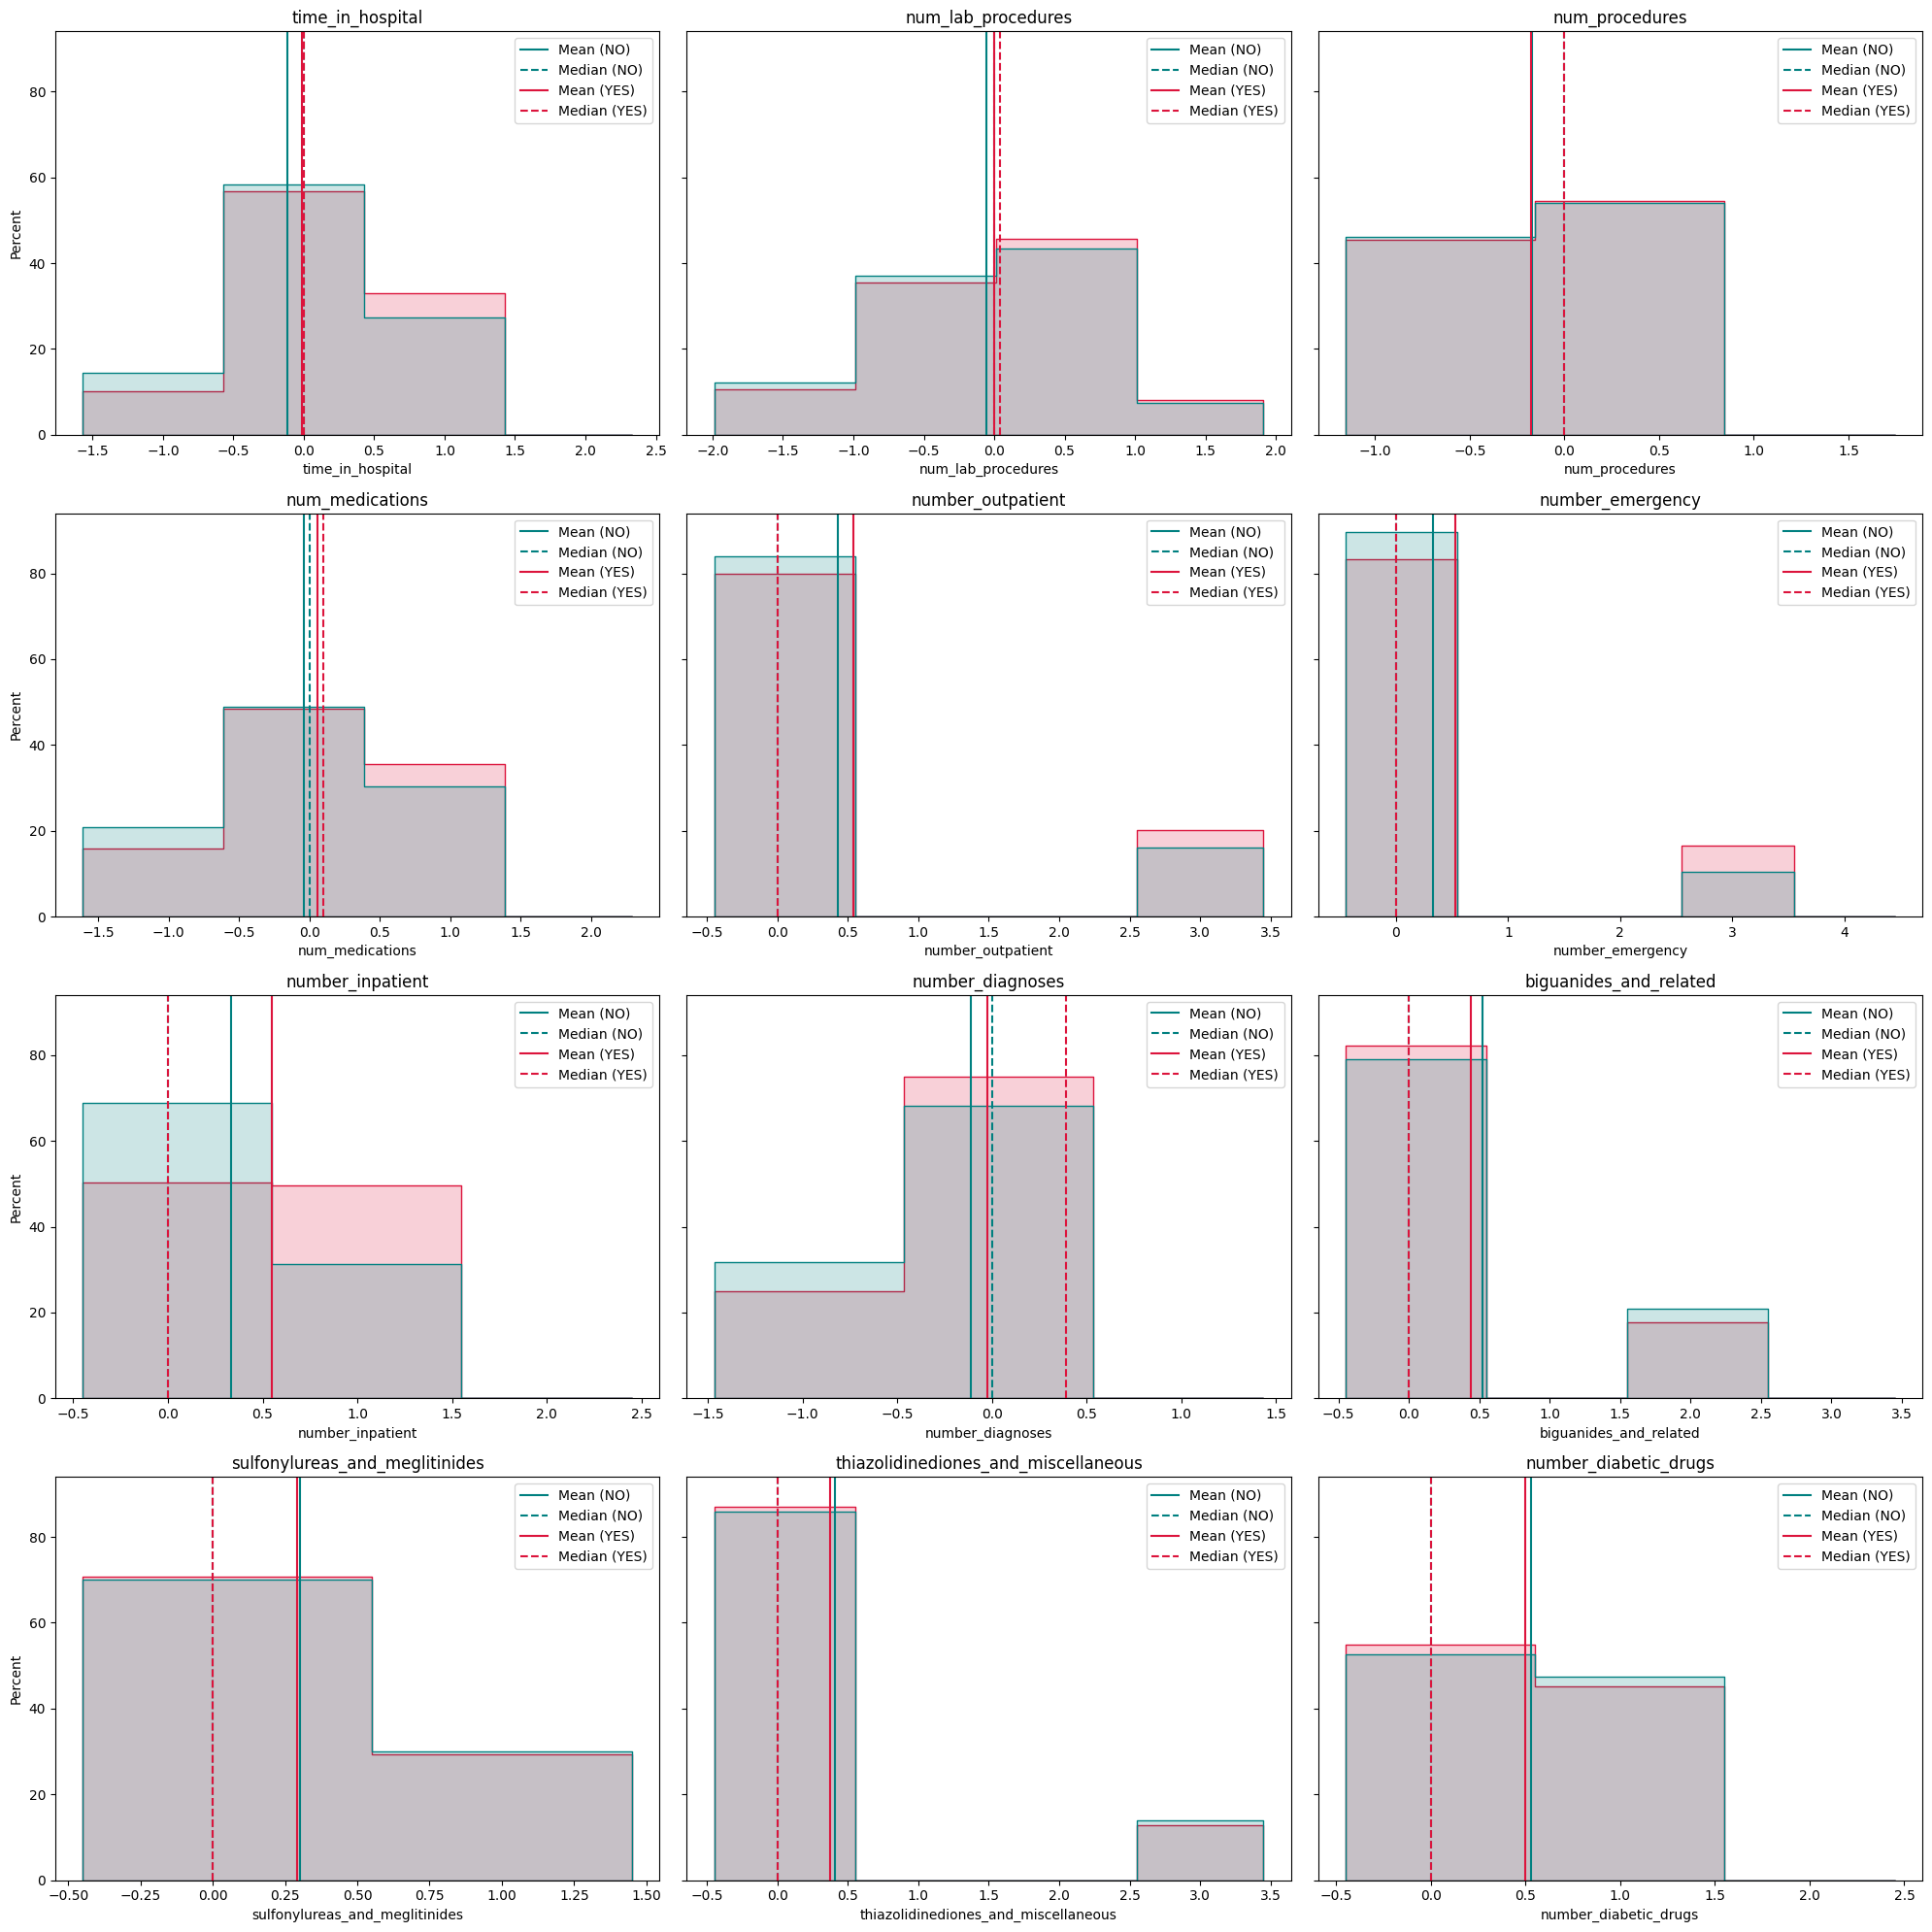

In [40]:
# let's look at the numerical data, we compare readmitted and not readmitted patients. we are looking at the percentages so we can see if the distributions are different.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20), sharey=True)
axes = axes.flatten()
palette=["teal", "crimson"]
for i, column in enumerate(numerical_columns):
    # Create a hist plot for each numerical column with color-coded bars
    sns.histplot( x=column, data=transformed_df, ax=axes[i],shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=palette, stat='percent', alpha=0.2)
    axes[i].set_title(column)
    for color_index, category in enumerate(transformed_df['readmitted'].unique()):
        mean_value = transformed_df[transformed_df['readmitted'] == category][column].mean()
        median_value = transformed_df[transformed_df['readmitted'] == category][column].median()
        axes[i].axvline(x=mean_value, color=palette[color_index], linestyle='-', label=f'Mean ({category})')
        axes[i].axvline(x=median_value, color=palette[color_index], linestyle='--', label=f'Median ({category})')
        axes[i].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# 4 Categorical columns
lets look on the categorical columns in our data
1. we want to look on the namber of catagories there are in each category
2. we want to remove categories with a single value or a value that is higher then 95 percent of the data
3. we want to reduse the dimentionalty of the categories

In [431]:
# lets look on all the categirical coloumns and see how many unique values they have and what is the percent
df_categorical = df.drop(columns=numerical_columns)
df_categorical.drop(columns=['patient_nbr'], inplace=True)


In [432]:
df_categorical

race  gender      age  admission_type_id  \
0            Caucasian  Female   [0-10)                  6   
1            Caucasian  Female  [10-20)                  1   
2      AfricanAmerican  Female  [20-30)                  1   
3            Caucasian    Male  [30-40)                  1   
4            Caucasian    Male  [40-50)                  1   
...                ...     ...      ...                ...   
99338  AfricanAmerican    Male  [70-80)                  1   
99339  AfricanAmerican  Female  [80-90)                  1   
99340        Caucasian    Male  [70-80)                  1   
99341        Caucasian  Female  [80-90)                  2   
99342        Caucasian    Male  [70-80)                  1   

       discharge_disposition_id  admission_source_id  \
0                            25                    1   
1                             1                    7   
2                             1                    7   
3                             1                    7   
4                             1                    7   
...                         ...                  ...   
99338                         3                    7   
99339                         4                    5   
99340                         1                    7   
99341                         3                    7   
99342                         1                    7   

              medical_specialty  diag_1  diag_2 diag_3 max_glu_serum  \
0      Pediatrics-Endocrinology  250.83     NaN    NaN           NaN   
1                           NaN     276  250.01    255           NaN   
2                           NaN     648     250    V27           NaN   
3                           NaN       8  250.43    403           NaN   
4                           NaN     197     157    250           NaN   
...                         ...     ...     ...    ...           ...   
99338                       NaN  250.13     291    458           NaN   
99339                       NaN     560     276    787           NaN   
99340                       NaN      38     590    296           NaN   
99341           Surgery-General     996     285    998           NaN   
99342                       NaN     530     530    787           NaN   

      A1Cresult insulin change diabetesMed readmitted  
0           NaN      No     No          No         NO  
1           NaN      Up     Ch         Yes         NO  
2           NaN      No     No         Yes         NO  
3           NaN      Up     Ch         Yes         NO  
4           NaN  Steady     Ch         Yes         NO  
...         ...     ...    ...         ...        ...  
99338        >8    Down     Ch         Yes         NO  
99339       NaN  Steady     No         Yes         NO  
99340       NaN    Down     Ch         Yes         NO  
99341       NaN      Up     Ch         Yes         NO  
99342       NaN      No     No          No         NO  

[99343 rows x 16 columns]

In [48]:
categorical_columns = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

## 4.2 veiw featurs uniqe value
we are doimg this to fimd places where we could reduse dimentionalty

<Figure size 800x4000 with 0 Axes>

0it [00:00, ?it/s]

<Axes: >

1it [00:00,  3.21it/s]

<Axes: >

2it [00:00,  3.35it/s]

<Axes: >

3it [00:00,  3.18it/s]

<Axes: >

4it [00:01,  3.23it/s]

<Axes: >

5it [00:01,  2.91it/s]

<Axes: >

6it [00:01,  2.93it/s]

<Axes: >

7it [00:02,  2.26it/s]

<Axes: >

8it [00:07,  1.94s/it]

<Axes: >

9it [00:15,  3.87s/it]

<Axes: >

10it [00:22,  4.59s/it]

<Axes: >

11it [00:22,  3.23s/it]

<Axes: >

12it [00:22,  2.29s/it]

<Axes: >

13it [00:22,  1.66s/it]

<Axes: >

14it [00:22,  1.21s/it]

<Axes: >

15it [00:22,  1.53s/it]


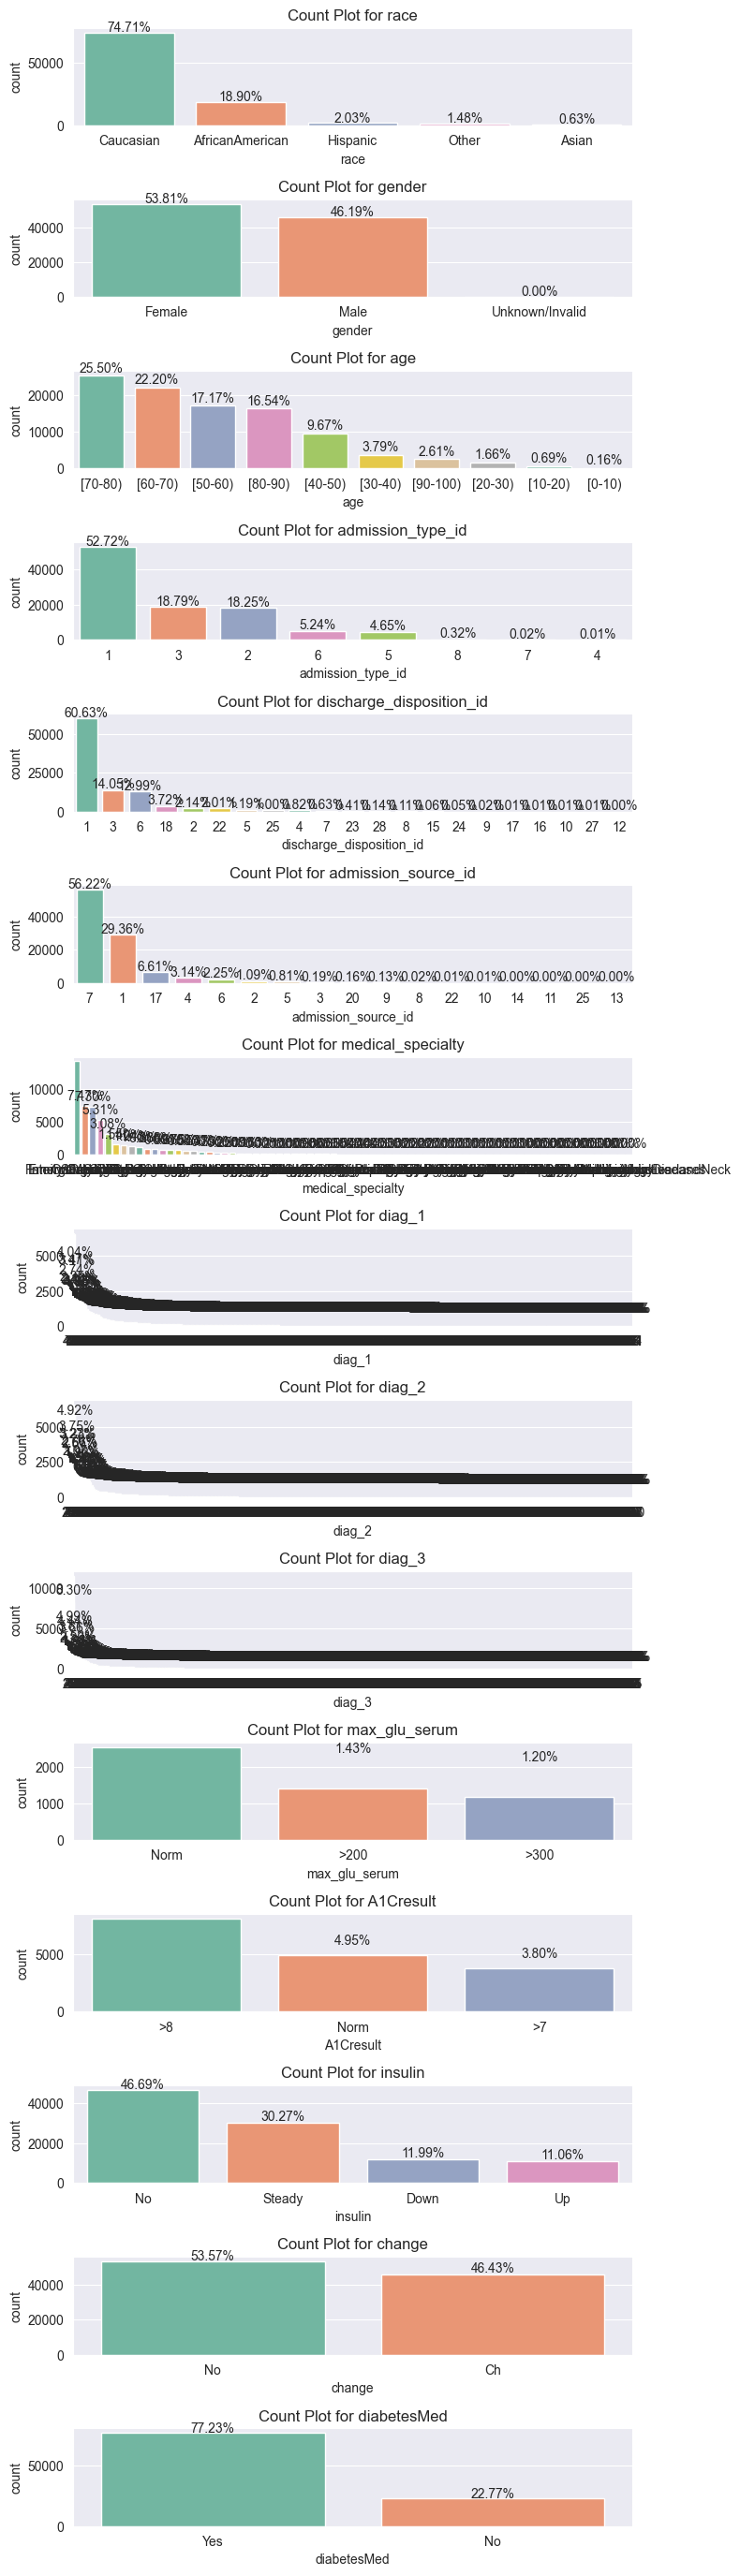

In [429]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# We would like to see how many categories we have and what the distribution is. We will modify the different categories to reduce dimensionality where possible
plt.figure(figsize=(8, 40))  
# Create a subplot with 22 rows and 1 column
plt.subplots_adjust(hspace=0.5)  
# Loop through each column and create count plots
for i, column in tqdm(enumerate(df_categorical.columns, 1)):  # Start counting from 1 for subplot index
    plt.subplot(22, 1, i)
    ax = plot_categorical_with_percent(df_categorical, column, palette="Set2")

# Adjust layout
plt.tight_layout()
plt.show()


## 4.3 inspect gender

<Axes: xlabel='gender', ylabel='Percent'>

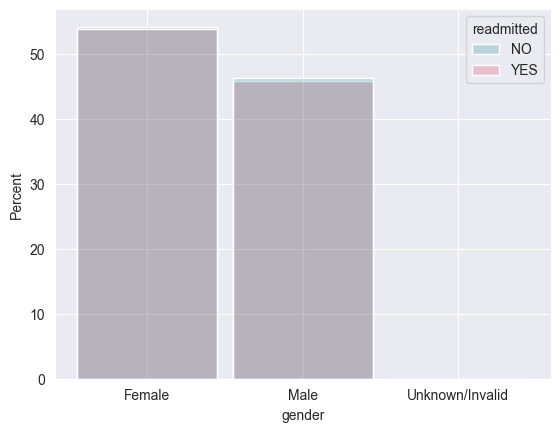

In [433]:
# lets look at gender dest:
# plot_categorical_with_percent(df_categorical, )
x='gender'
desired_order = df_categorical[x].value_counts().index.tolist()  # Get the desired order of bars
# Sort the DataFrame based on the desired order
data = df_categorical[df_categorical[x].isin(desired_order)]
sns.histplot(x=x, data=data ,shrink=.9, hue='readmitted', discrete=True, element='bars', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

In [434]:
# we will remove rwos with inknown gender
gender_remover = dt.RowRemoverByFeatureValue('gender', exclude_vals=['Unknown/Invalid'])
df = gender_remover.fit_transform(df)



<Axes: xlabel='gender', ylabel='Percent'>

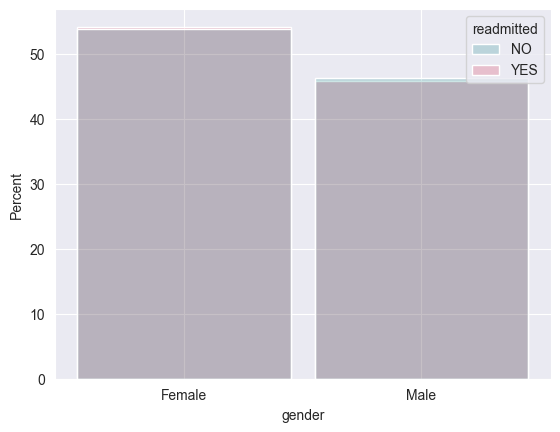

In [435]:
sns.histplot( x='gender', data=df,shrink=.9, hue='readmitted', discrete=True, element='bars', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

## 4.4 inspect discharge_disposition

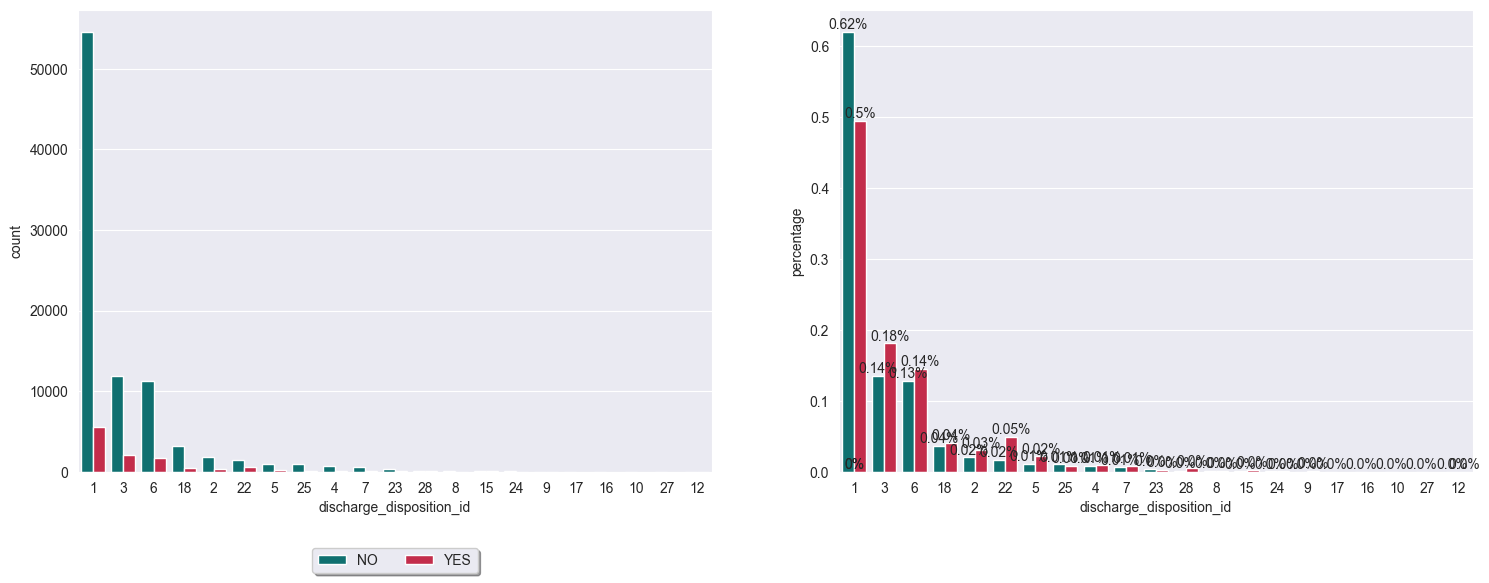

In [436]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_dual_plot(x, data, hue, palette,  figsize=(12, 6)):
    # Calculate the order of bars by counts
    order = data[x].value_counts().index

    # Create subplots
    f, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot countplot on the first subplot
    sns.countplot(x=x, data=data, hue=hue, order=order, palette=palette, ax=axes[0])

    # Plot percentplot on the second subplot
    prop_df = (data[x]
               .groupby(data[hue])
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())

    g = sns.barplot(x=x, y='percentage', hue=hue, data=prop_df, ax=axes[1], palette=palette, order=order)

    # Place legend beneath both plots
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=len(pd.unique(data[x])))
    axes[1].get_legend().remove()  # Remove legend from the second plot

    # Add percentage labels to the bars in the countplot
    for p in g.patches:
        txt = str(np.round(p.get_height(), decimals=2)) + '%'
        txt_x = p.get_x() + p.get_width() / 2
        txt_y = p.get_height()
        g.annotate(txt, (txt_x, txt_y), ha='center', va='bottom')

    # Show the plots
    plt.show()


x = 'discharge_disposition_id'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(18, 6))


In [437]:
change_duscharde_to_home_or_not = dt.CategoryReducer(feature='discharge_disposition_id', lookup={'home': [1]})
change_duscharde_to_home_or_not.prop_setter = prop_setter
change_duscharde_to_home_or_not._fit(df)
df = change_duscharde_to_home_or_not.transform(df)

CategoryReducer(feature='discharge_disposition_id', lookup={'home': [1]})

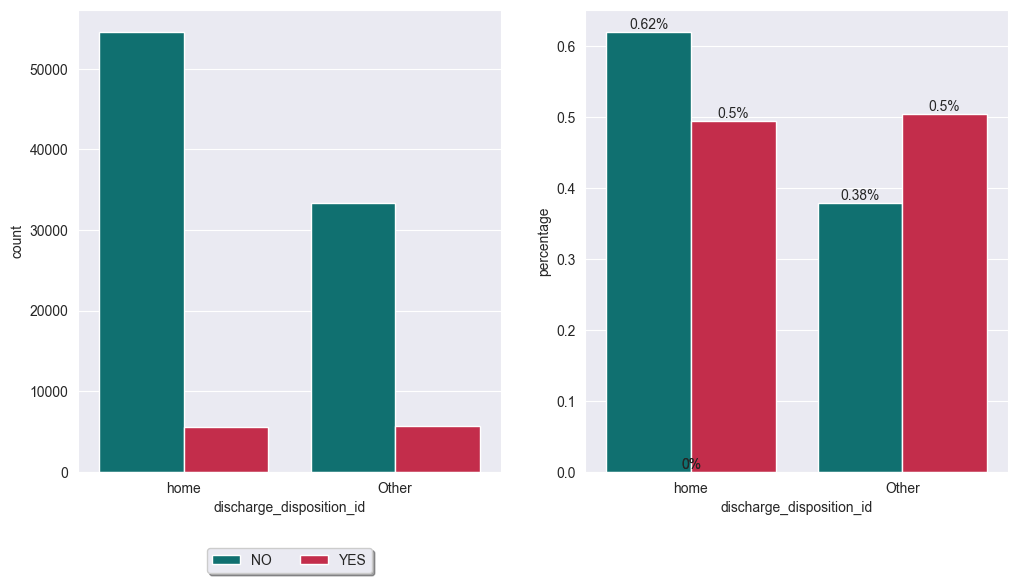

In [438]:
x = 'discharge_disposition_id'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 4.5 inspect admission_type_id
change the admission to categorical, reduce to other, high_prayority, clinic_referral
admission_type_id	description
1	Emergency
2	Urgent
3	Elective
4	Newborn
5	Not Available
6	NULL
7	Trauma Center
8	Not Mapped
we are grouping togeter: 8,6,5 toggeter as 'other', 1,2 as high_prayority and else as clinic referral




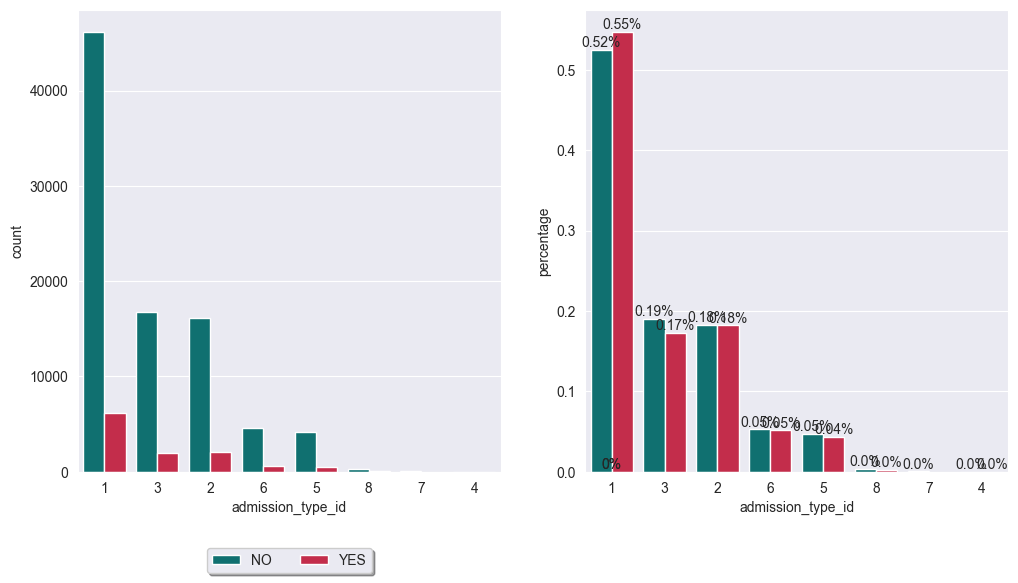

In [439]:
x = 'admission_type_id'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

In [440]:
admission_reduse = dt.CategoryReducer(feature='admission_type_id', lookup={'HighPriority': [1, 2], 'ClinicReferral': [3, 4, 7]})
admission_reduse.prop_setter = prop_setter
admission_reduse._fit(df)
df = admission_reduse.transform(df)



CategoryReducer(feature='admission_type_id',
                lookup={'ClinicReferral': [3, 4, 7], 'HighPriority': [1, 2]})

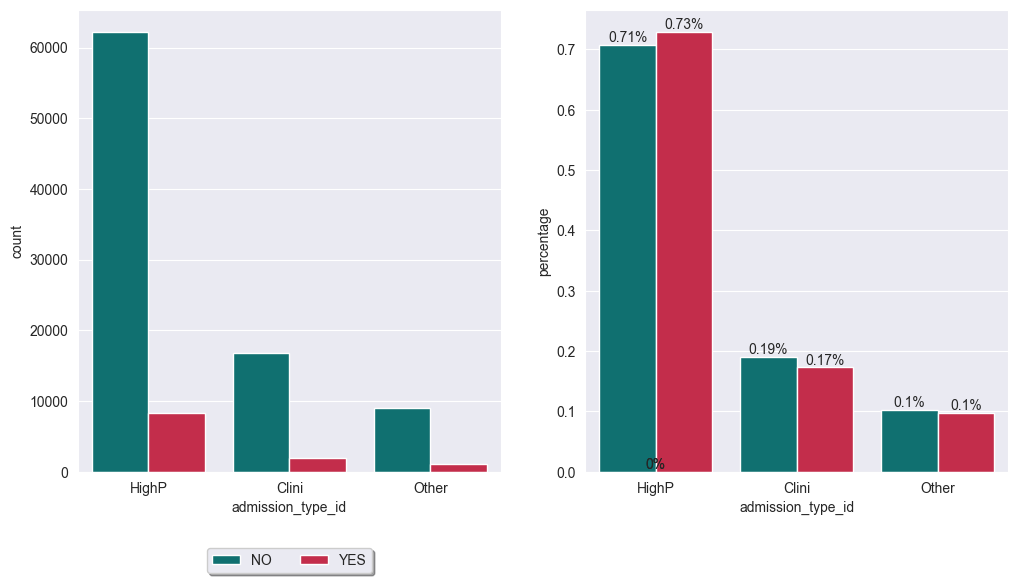

In [441]:
x = 'admission_type_id'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 4.6 inspect race
We see that caucasian and African American are ~92 % of the data so we will unite oTHER, ASIAN AND HISPANIC to reduce dimentionalty


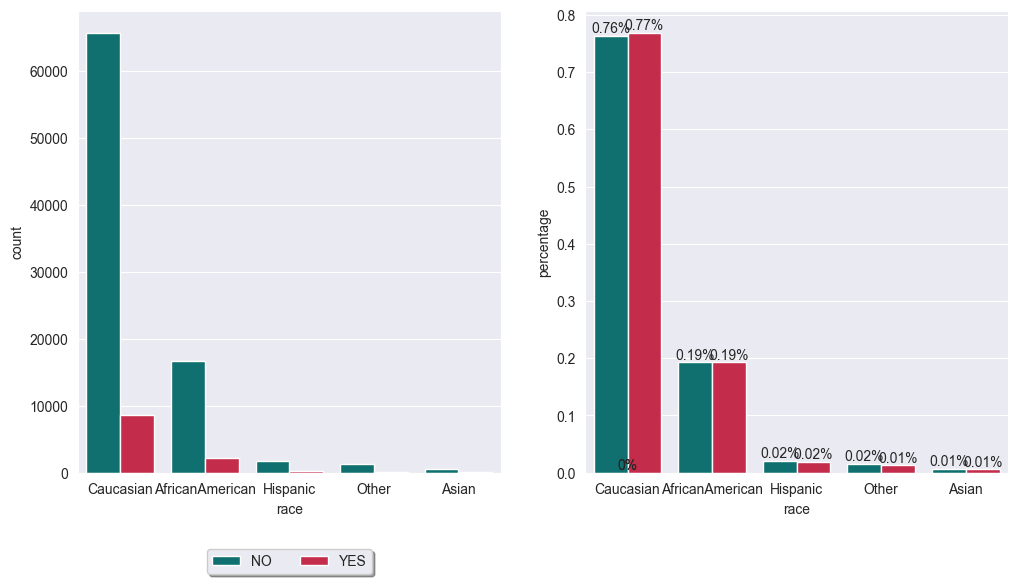

In [442]:
x = 'race'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

In [443]:
race_reduse = dt.CategoryGroupOthers({'race': ['AfricanAmerican', 'Caucasian']})
race_reduse.prop_setter = prop_setter
df = race_reduse.transform(df)

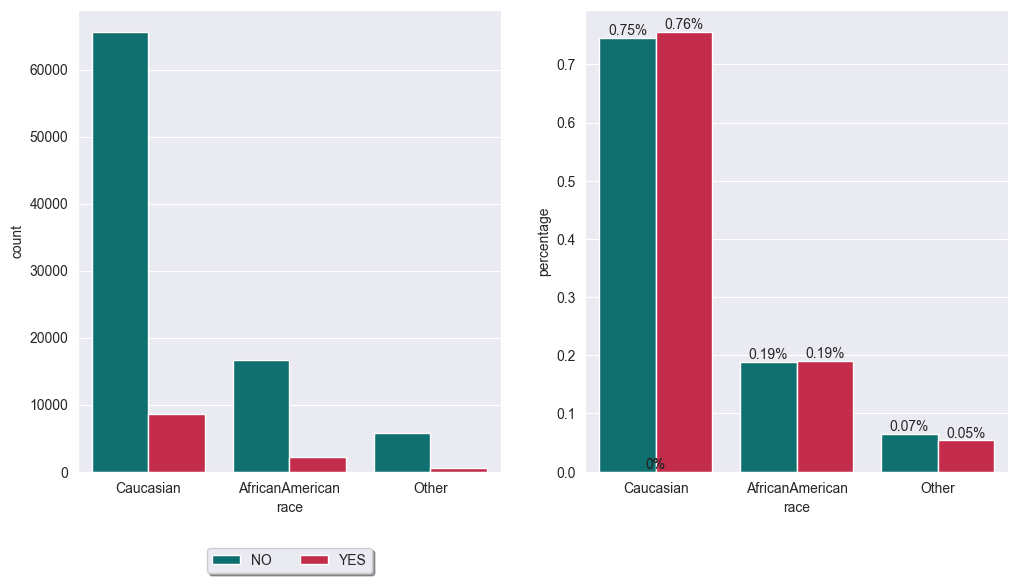

In [444]:
x = 'race'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 4.7 inspect age

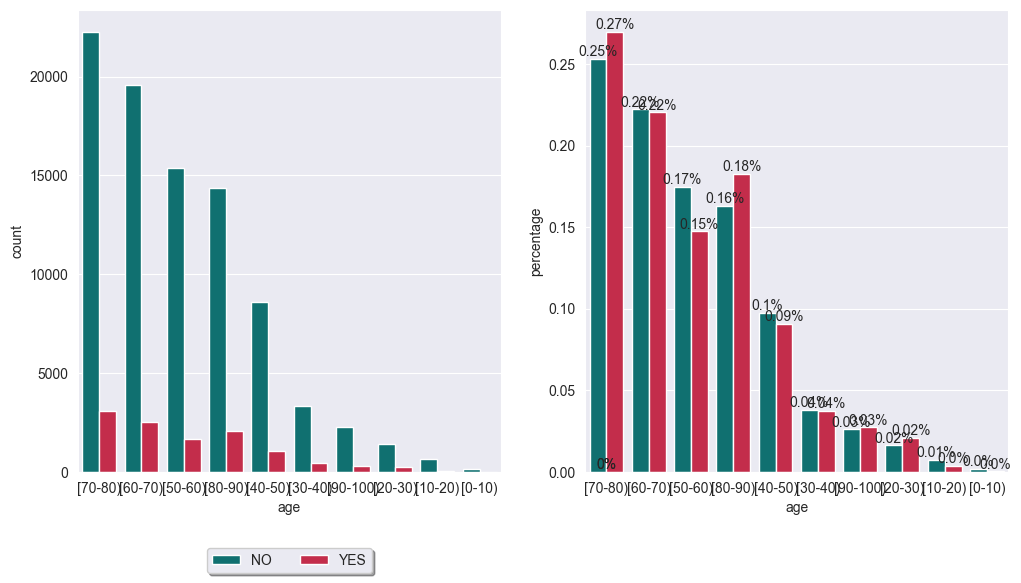

In [445]:
x = 'age'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 5.5 Adding engineered features based on time we are adding int type average for age
this gices us ordered age based on numeric values

In [446]:

mean_age =dt.AddFeatureAverageAge(age_group_col='age')
mean_age.prop_setter = prop_setter
df=mean_age.transform(df)

In [447]:
lookup={'<30': ['[0-10)', '[10-20)', '[20-30)'], '30<60': ['[30-40)', '[40-50)', '[50-60)'], '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']}
age_reducer = dt.CategoryReducer(feature='age', lookup=lookup)
age_reducer.prop_setter = prop_setter
age_reducer._fit(df)
df= age_reducer.transform(df)

CategoryReducer(feature='age',
                lookup={'30<60': ['[30-40)', '[40-50)', '[50-60)'],
                        '<30': ['[0-10)', '[10-20)', '[20-30)'],
                        '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']})

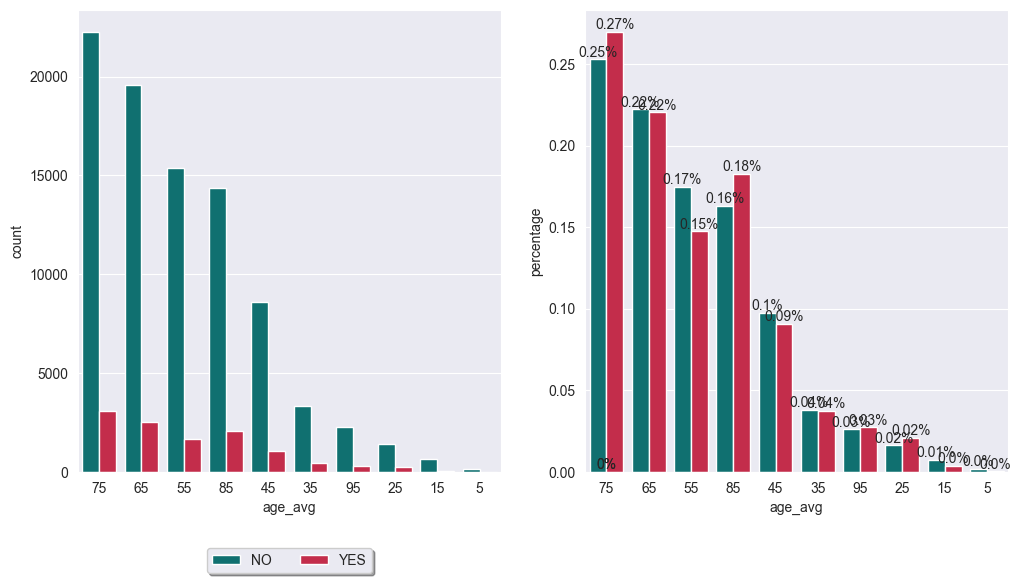

In [450]:
x = 'age_avg'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

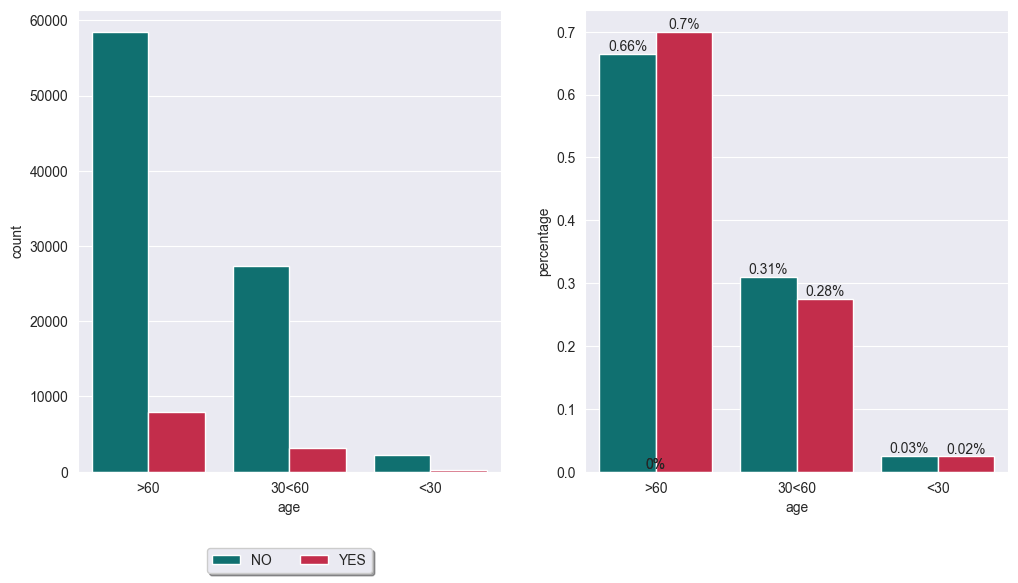

In [448]:
x = 'age'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 4.8 inspect medical_specialty

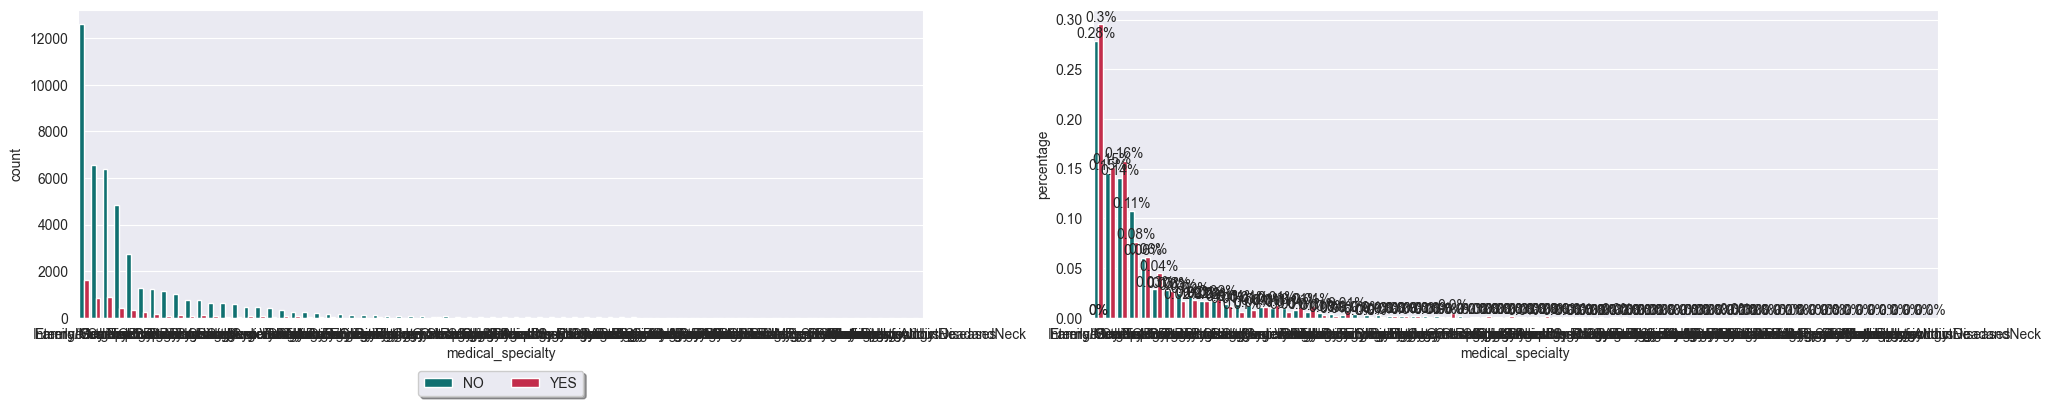

In [451]:
x = 'medical_specialty'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24, 4))

In [453]:
# we keep only the top 8 values in the feature
medical_spec_reduse = dt.CategoryGroupOthers({'medical_specialty': ['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
                              'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics']})
medical_spec_reduse.prop_setter = prop_setter
medical_spec_reduse._fit(df)
df = medical_spec_reduse.transform(df)

CategoryGroupOthers(nonother={'medical_specialty': ['InternalMedicine',
                                                    'Emergency/Trauma',
                                                    'Family/GeneralPractice',
                                                    'Cardiology',
                                                    'Surgery-General',
                                                    'Nephrology',
                                                    'Orthopedics']})

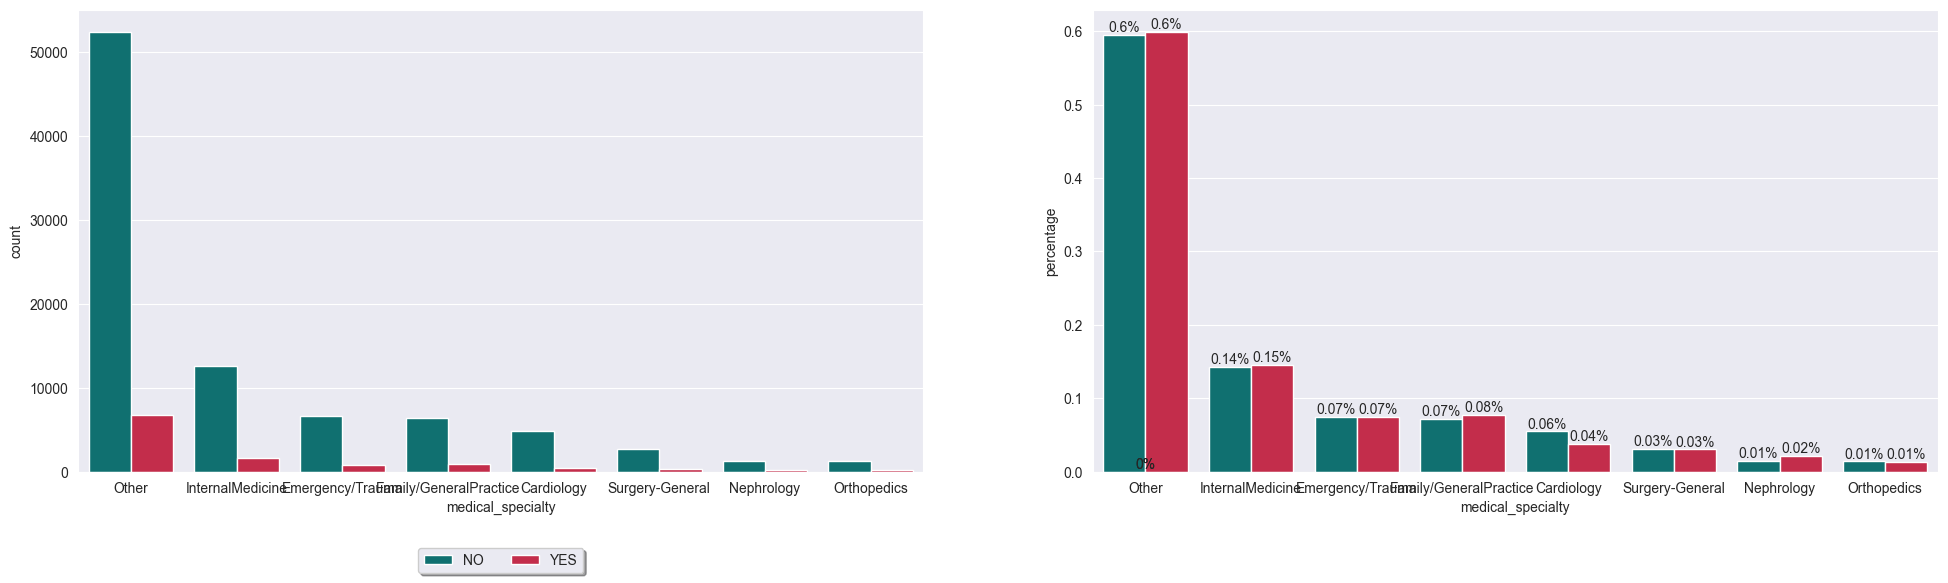

In [454]:
x = 'medical_specialty'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24, 6))

In [455]:
df.keys()

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed',
       'readmitted', 'biguanides_and_related',
       'sulfonylureas_and_meglitinides',
       'thiazolidinediones_and_miscellaneous', 'number_diabetic_famalies',
       'age_avg'],
      dtype='object')

## 4.9 inspect A1Cresult

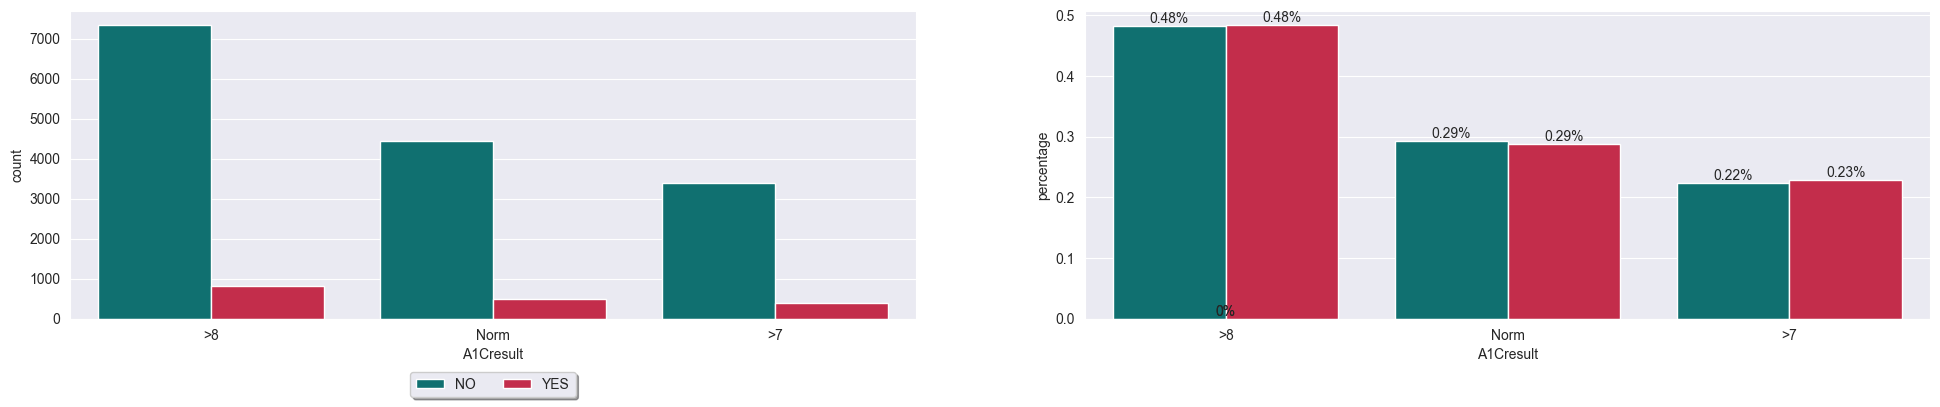

In [456]:
x = 'A1Cresult'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24, 4))

In [457]:
## 4.10 inspect insulin

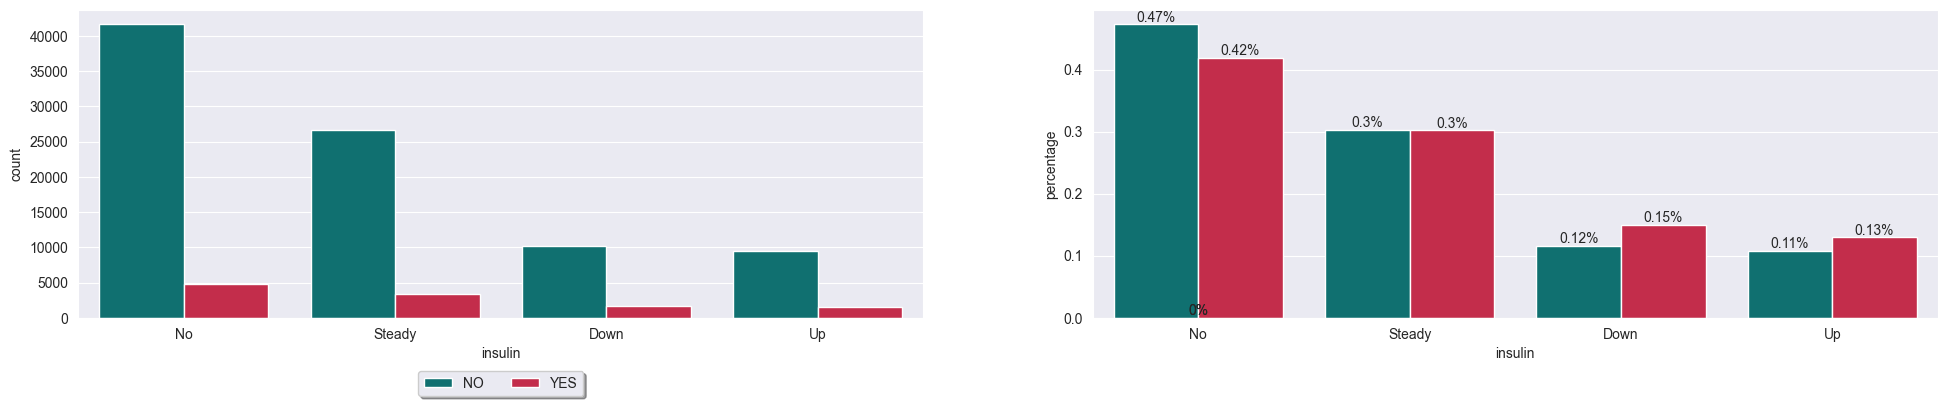

In [458]:
x = 'insulin'
data = df_categorical
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24, 4))

# 5. Feature Engineering

From going over the data we found multiple data editing that can be beneficial:
1. 'encounter_id' and 'patient_nbr' are identifiers and not variables
2.  'admission_type_id', 'discharge_disposition_id', and 'admission_source_id': are numerical, They should be considered categorical.
3.  'examide' and 'citoglipton' have only one unique value thus, not contributing ('No' and 'No') and removed
4.  'acetohexamide',  'tolbutamide', 'troglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone' in all this columns we find two unique values, but one value is in 99.99 percent of the data, we thus remove this columns 
5. following 4 we dicided to remove all coloumns that 95 percent or more is jest one value : ['examide', 'citoglipton', 'acetohexamide', 'tolbutamide','troglitazone', 'glimepiride-pioglitazone','metformin-rosiglitazone', 'metformin-pioglitazone','glipizide-metformin', 'tolazamide', 'glyburide-metformin','acarbose', 'miglitol', 'chlorpropamide', 'nateglinide',
'repaglinide']
6.there are 913 diagnostics, to reduse the dimentinalety we unite codeons based on the  major classification of it, we mannaged to reduse the diag to 19 and we changed it to be catagorical
7. gender to categorical: male, female, we removed unknown only 3
8. We changed the discharge to home/other and changed to categorical
9. addmition_id is changed to categorical, with 3 catagories 'clinic referral', 'high_prayority and other
10. race is cahnged to categorical,  nan values are turned to missing and we unite low repits values (asian and hispanic) with other
11. 6.  


## 5.1 set encounters

If you have diabetes, an ideal HbA1c level is 48mmol/mol (6.5%) or below. If you're at risk of developing type 2 diabetes,
 your target HbA1c level should be below 42mmol/mol (6%)


We considered four groups of encounters: 

(1) no HbA1c test performed.

(2) HbA1c performed and in normal range.

(3) HbA1c performed and the result is greater than 7% with no change in diabetic medications.

(4) HbA1c performed, result is greater than 7%, and diabetic medication was changed.


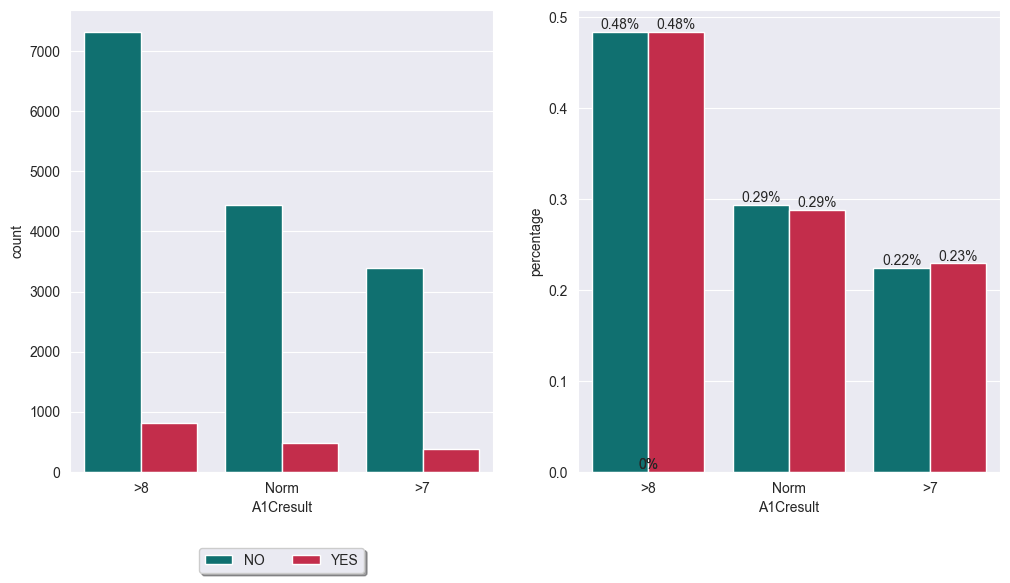

In [460]:
x = 'A1Cresult'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

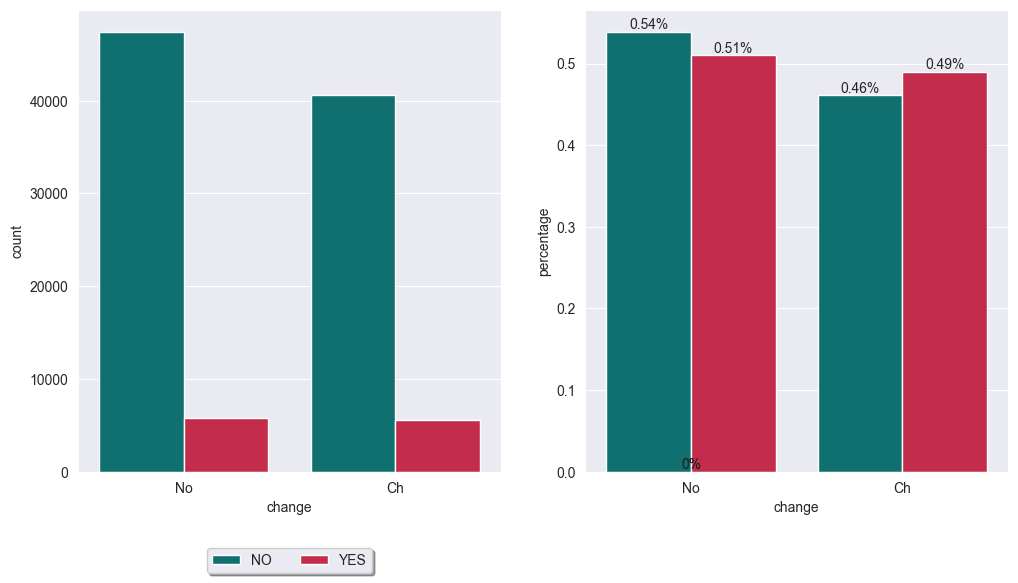

In [459]:
x = 'change'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

In [71]:
add_encounters = dt.AddFeatureEncounter()
add_encounters.prop_setter = prop_setter
df= add_encounters.transform(df)

C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2024\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\dekel\anaconda3\envs\mlc2

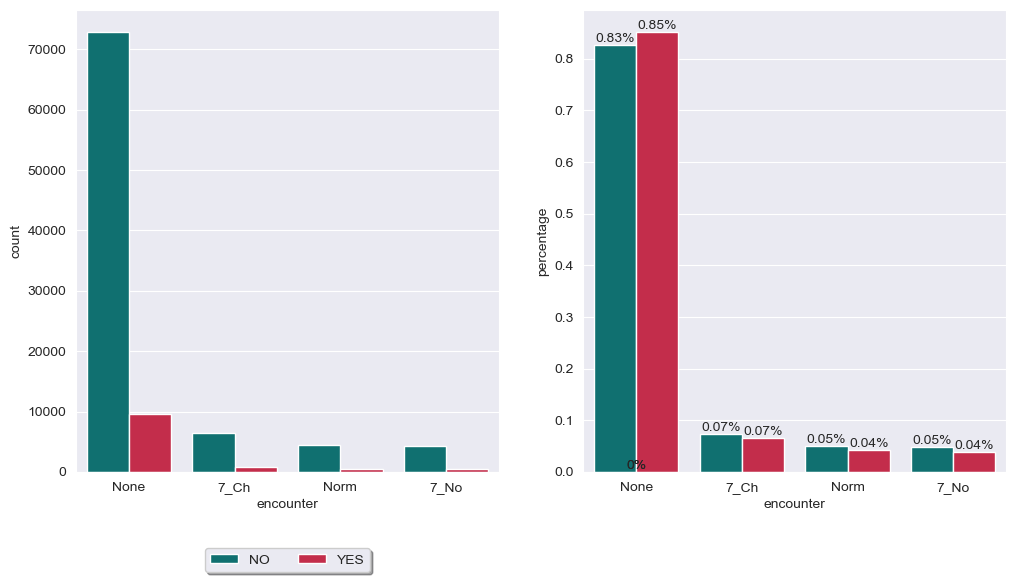

In [72]:
x = 'encounter'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette)

## 5.2 add features by summing
we want to add two features:
1. num_visits = sum(['number_outpatient', 'number_inpatient', 'number_emergency'],)
2. 'num_nonEm_visits': ['number_outpatient', 'number_inpatient']



"We are adding these features because we believe that people who tend to go to hospitals will have a higher chance of readmitting more frequentl."


In [461]:
featuers_to_sum = {
        'num_visits': ['number_outpatient', 'number_inpatient', 'number_emergency'],
        'num_nonEm_visits': ['number_outpatient', 'number_inpatient'],
    }
add_featurs_by_suming = dt.AddFeatureBySumming(featuers_to_sum)
add_featurs_by_suming.prop_setter = prop_setter
df= add_featurs_by_suming.transform(df)

<Axes: xlabel='num_visits', ylabel='Percent'>

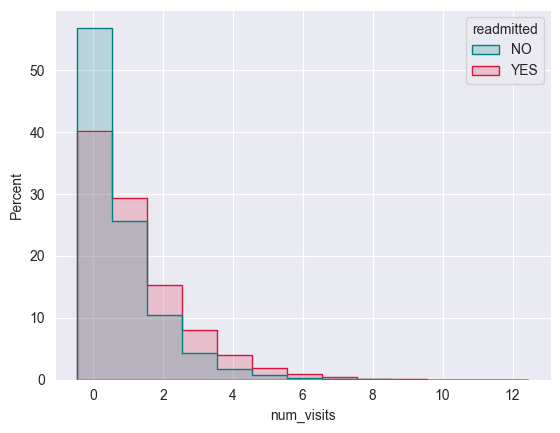

In [462]:
sns.histplot( x='num_visits', data=df, shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

<Axes: xlabel='num_nonEm_visits', ylabel='Percent'>

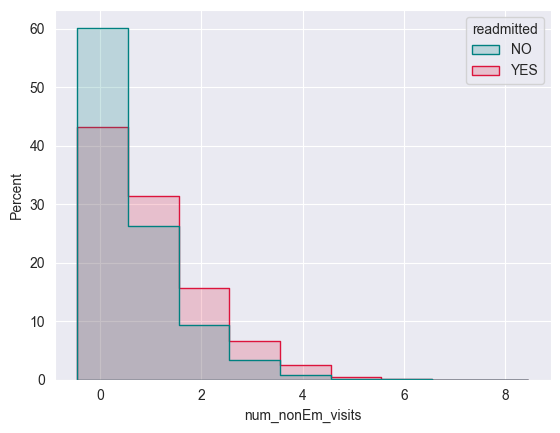

In [463]:
sns.histplot( x='num_nonEm_visits', data=df, shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

In [ ]:
df.drop_duplicates()

In [76]:
#  we can see that patioants with more visits tend to readdmit more

## 5.3 add_features.by_normalize
pationts lab_procedures, and medications are the total number in the encunter, we would like to normelize it by time:
to get the "perday" values:


In [464]:
add_per_day_noem = dt.AddFeatureByNormalizing({
        'time_in_hospital': (['num_lab_procedures', 'num_procedures', 'num_medications'], 'perDay')
    })
add_per_day_noem.prop_setter = prop_setter
df= add_per_day_noem.transform(df)


<Axes: xlabel='num_lab_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'diabetesMed')

<Axes: xlabel='num_procedures', ylabel='Percent'>

Text(0.5, 1.0, 'diabetesMed')

<Axes: xlabel='num_medications', ylabel='Percent'>

Text(0.5, 1.0, 'diabetesMed')

<Axes: xlabel='num_lab_procedures_perDay', ylabel='Percent'>

Text(0.5, 1.0, 'diabetesMed')

<Axes: xlabel='num_procedures_perDay', ylabel='Percent'>

Text(0.5, 1.0, 'diabetesMed')

<Axes: xlabel='num_medications_perDay', ylabel='Percent'>

Text(0.5, 1.0, 'diabetesMed')

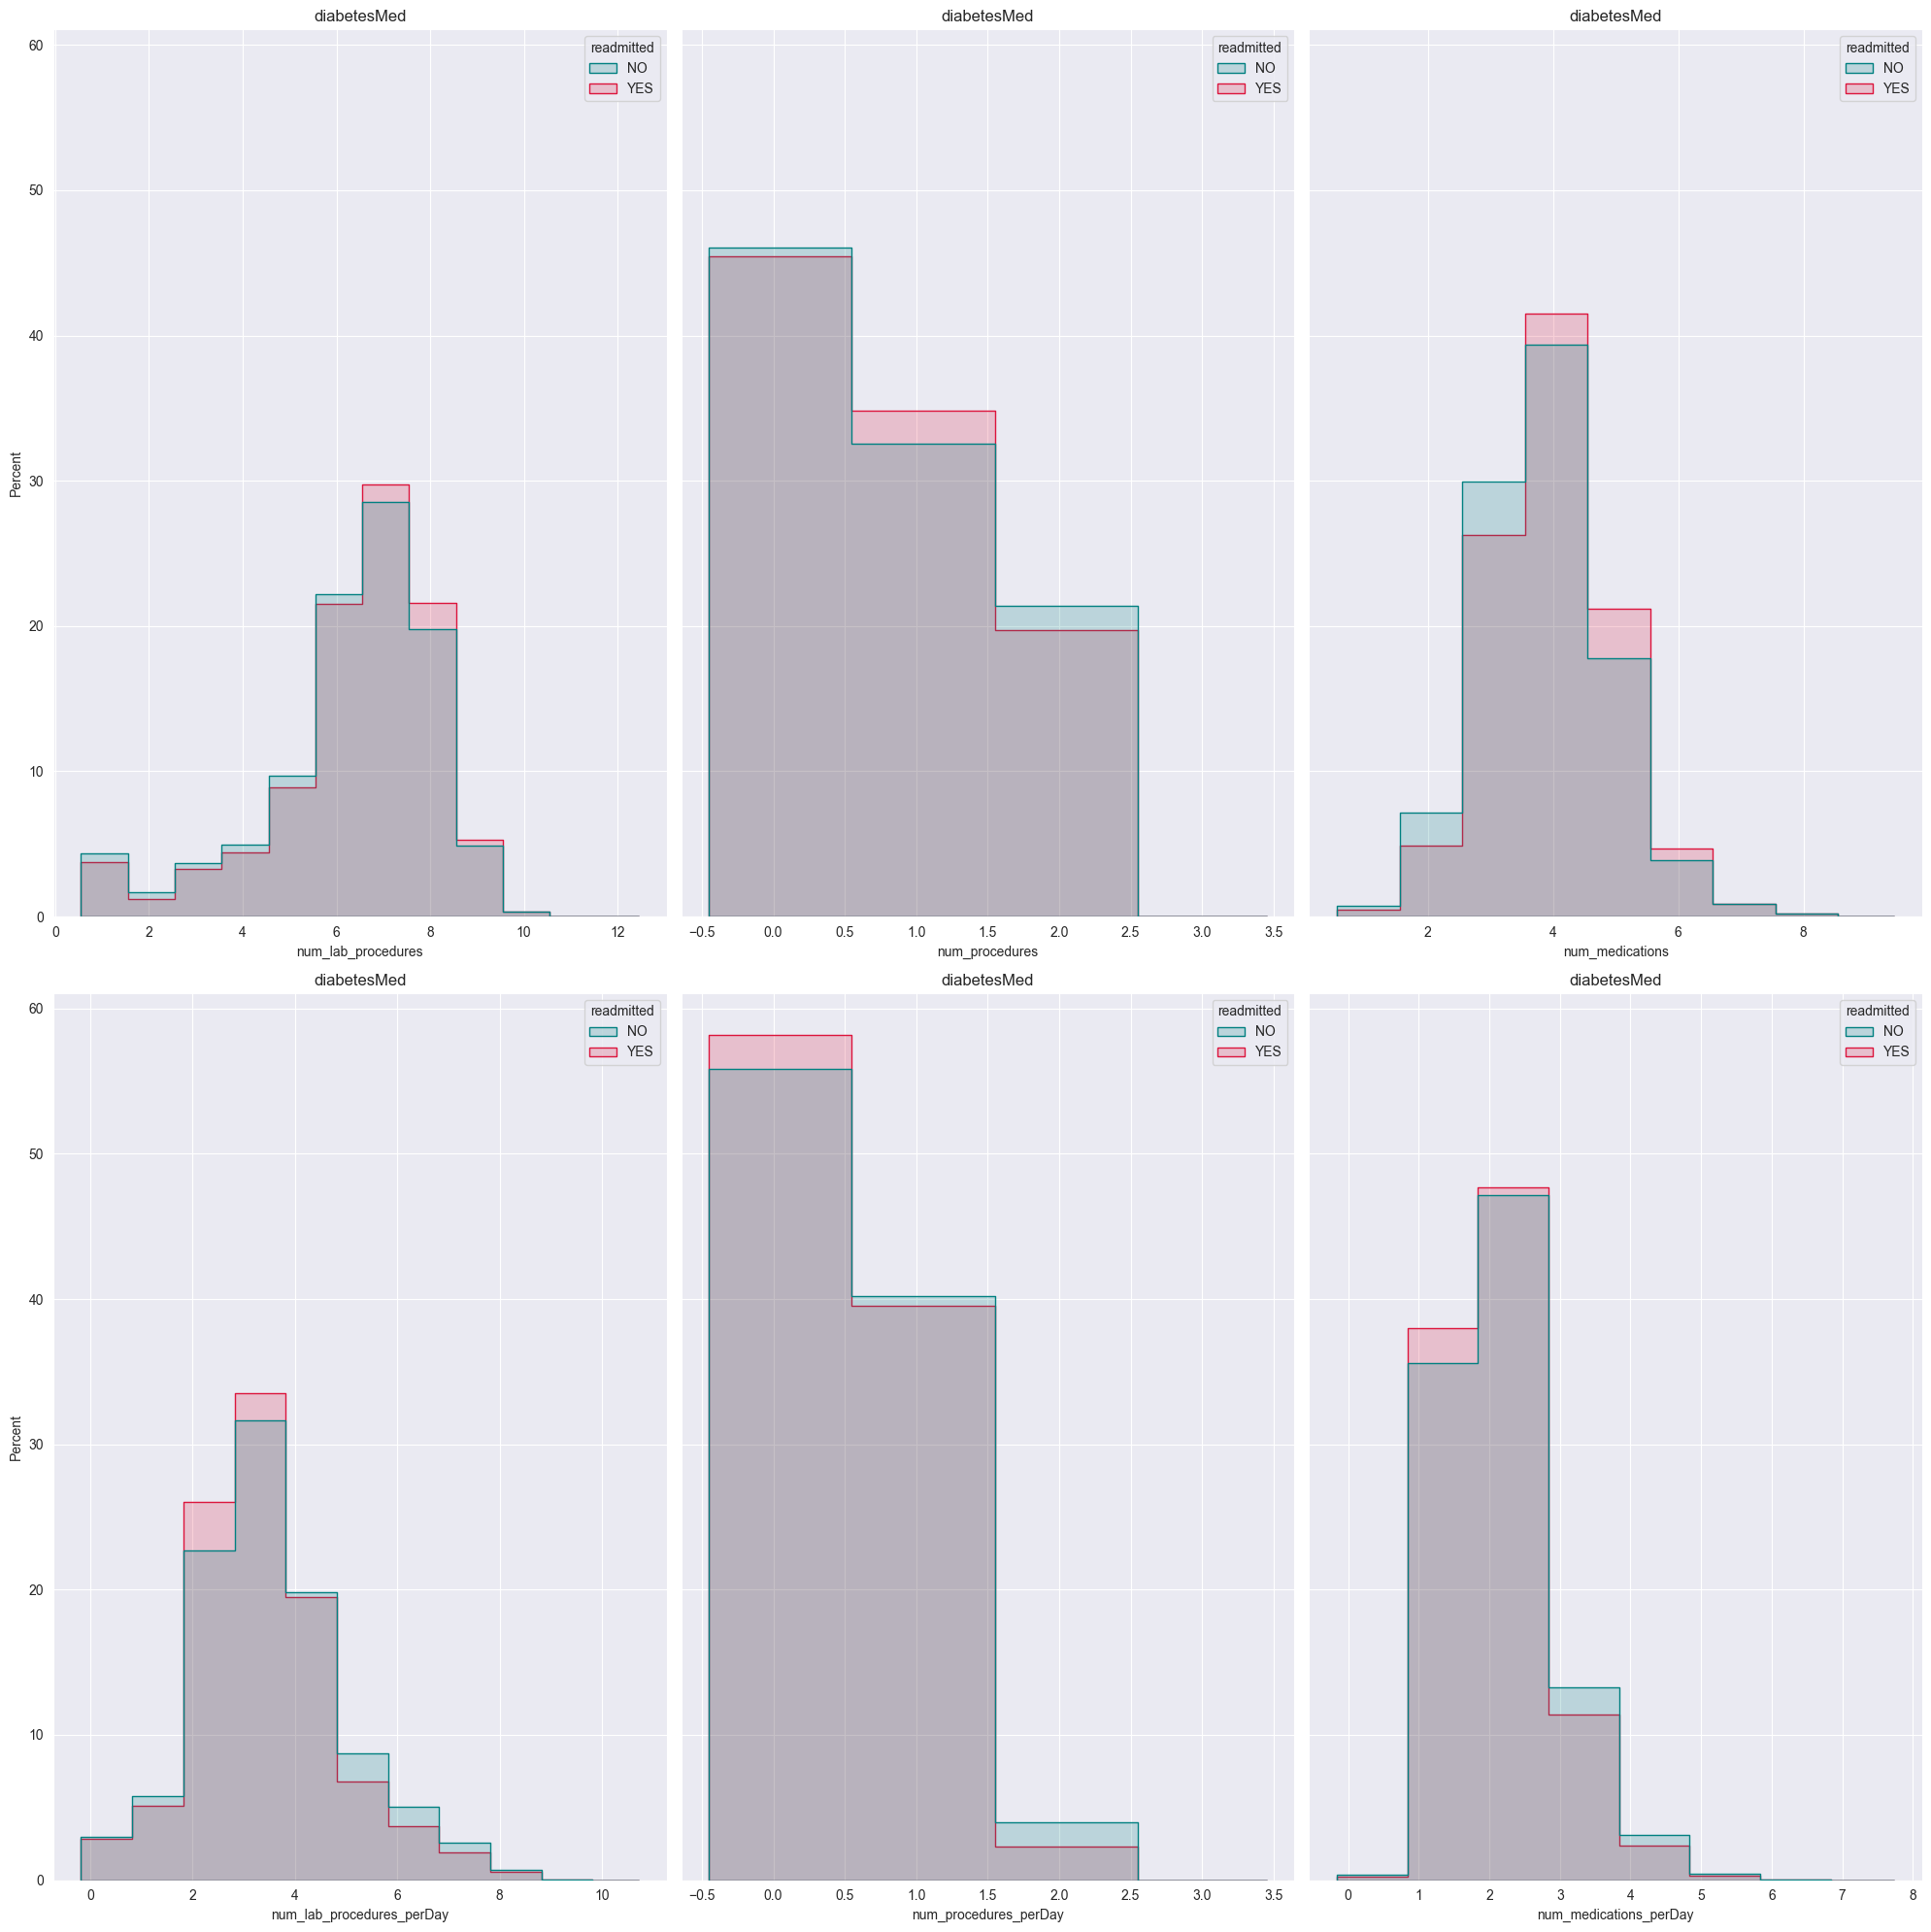

In [465]:
# let's look at the numerical data, we compare readmitted and not readmitted patients. we are looking at the percents so we can see if the distributions are different.
features = ['num_lab_procedures', 'num_procedures', 'num_medications', 'num_lab_procedures_perDay', 'num_procedures_perDay', 'num_medications_perDay']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for i, featur in enumerate(features):
    # Create a hist plot for each numerical column with color-coded bars
    sns.histplot( x=featur, data=df, ax=axes[i],shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)
    axes[i].set_title(column)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [466]:
# when normelizing it seems that readmmited pationts got less lof everiting per a day

In [467]:
df.keys()

Index(['patient_nbr', 'race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed',
       'readmitted', 'biguanides_and_related',
       'sulfonylureas_and_meglitinides',
       'thiazolidinediones_and_miscellaneous', 'number_diabetic_famalies',
       'age_avg', 'num_visits', 'num_nonEm_visits',
       'num_lab_procedures_perDay', 'num_procedures_perDay',
       'num_medications_perDay'],
      dtype='object')

<Axes: xlabel='num_nonEm_visits', ylabel='Percent'>

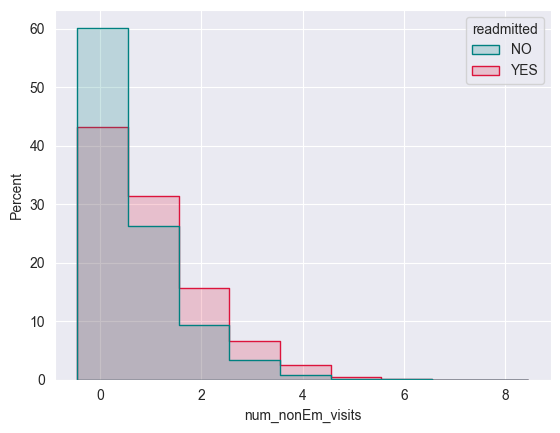

In [468]:
sns.histplot( x='num_nonEm_visits', data=df, shrink=.9, hue='readmitted', discrete=True, element='step', common_norm=False, palette=["teal", "crimson"], stat='percent', alpha=0.2)

## 5.4 inspect diag 

In [469]:
df_categorical

race  gender      age  admission_type_id  \
0            Caucasian  Female   [0-10)                  6   
1            Caucasian  Female  [10-20)                  1   
2      AfricanAmerican  Female  [20-30)                  1   
3            Caucasian    Male  [30-40)                  1   
4            Caucasian    Male  [40-50)                  1   
...                ...     ...      ...                ...   
99338  AfricanAmerican    Male  [70-80)                  1   
99339  AfricanAmerican  Female  [80-90)                  1   
99340        Caucasian    Male  [70-80)                  1   
99341        Caucasian  Female  [80-90)                  2   
99342        Caucasian    Male  [70-80)                  1   

       discharge_disposition_id  admission_source_id  \
0                            25                    1   
1                             1                    7   
2                             1                    7   
3                             1                    7   
4                             1                    7   
...                         ...                  ...   
99338                         3                    7   
99339                         4                    5   
99340                         1                    7   
99341                         3                    7   
99342                         1                    7   

              medical_specialty  diag_1  diag_2 diag_3 max_glu_serum  \
0      Pediatrics-Endocrinology  250.83     NaN    NaN           NaN   
1                           NaN     276  250.01    255           NaN   
2                           NaN     648     250    V27           NaN   
3                           NaN       8  250.43    403           NaN   
4                           NaN     197     157    250           NaN   
...                         ...     ...     ...    ...           ...   
99338                       NaN  250.13     291    458           NaN   
99339                       NaN     560     276    787           NaN   
99340                       NaN      38     590    296           NaN   
99341           Surgery-General     996     285    998           NaN   
99342                       NaN     530     530    787           NaN   

      A1Cresult insulin change diabetesMed readmitted  
0           NaN      No     No          No         NO  
1           NaN      Up     Ch         Yes         NO  
2           NaN      No     No         Yes         NO  
3           NaN      Up     Ch         Yes         NO  
4           NaN  Steady     Ch         Yes         NO  
...         ...     ...    ...         ...        ...  
99338        >8    Down     Ch         Yes         NO  
99339       NaN  Steady     No         Yes         NO  
99340       NaN    Down     Ch         Yes         NO  
99341       NaN      Up     Ch         Yes         NO  
99342       NaN      No     No          No         NO  

[99343 rows x 16 columns]

<Axes: title={'center': 'Count Plot for value'}, xlabel='value', ylabel='count'>

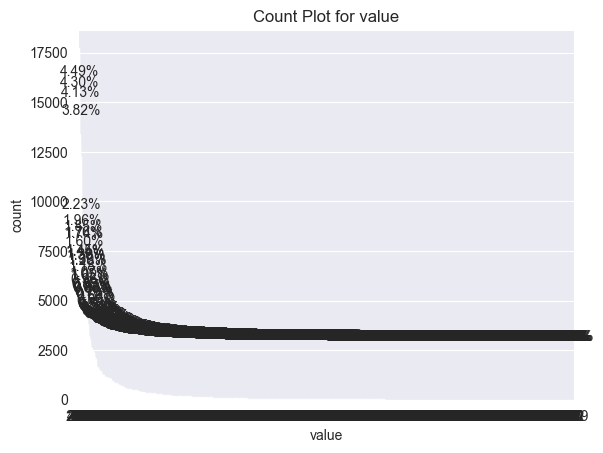

In [471]:
# we have 3 coloumns that are basicly thesame diag_1, diag_2, and diag_3: we decided to turn it to unite and turn it to categorical featurs 
diag = df.reset_index().melt(value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')
# diag.value = diag.apply(lambda row: change_value(row.value), axis=1)
plot_categorical_with_percent(diag, 'value')

ICD-9-CM stands for the International Classification of Diseases, Ninth Revision, Clinical Modification. It is a system of codes used for classifying diseases and health conditions. The ICD-9-CM was used in the United States until it was replaced by ICD-10-CM on October 1, 2015. Despite its replacement, ICD-9-CM codes may still be found in historical medical records.

Each ICD-9-CM code is alphanumeric and consists of up to five digits. Here's a breakdown of how to read the codes:

First Digit (Numeric): The first digit represents the category of the disease or condition.

Second and Third Digits (Numeric): These digits further specify the cause, location, severity, and type of the condition within the category.

Fourth and Fifth Digits (Alphanumeric): These digits provide additional detail, such as etiology, anatomical site, or a specific condition.

For example, consider the ICD-9-CM code 401.9:

401: This is the category code for hypertensive heart disease.
.9: These digits provide additional specificity. In this case, ".9" indicates that the code is unspecified, meaning it does not provide further detail about the type or severity of hypertensive heart disease.
In the ICD-9-CM coding system, the first digit of a code represents a broad category or major classification of diseases or conditions. The first digit is numeric, and it falls into one of the following general categories:

1. 001–139: Infectious and Parasitic Disease2. s 140–239: Neoplasms (Tumor3. s) 240–279: Endocrine, Nutritional, and Metabolic Diseases, and Immunity Disord4. ers 280–289: Diseases of the Blood and Blood-Forming Or5. gans 290–319: Mental Diso6. rders 320–389: Diseases of the Nervous System and Sense 7. Organs 390–459: Diseases of the Circulatory8. System 460–519: Diseases of the Respirator9. y System 520–579: Diseases of the Digesti10. ve System 580–629: Diseases of the Genitourin11. ary System 630–679: Complications of Pregnancy, Childbirth, and the12. Puerperium 680–709: Diseases of the Skin and Subcuta13. neous Tissue 710–739: Diseases of the Musculoskeletal System and Conn14. ective Tissue 740–759: Congen15. ital Anomalies 760–779: Certain Conditions Originating in the P16. erinatal Period 780–799: Symptoms, Signs, and Ill-De17. fined Conditions 800–999: Inj18. uoisoning E800–E999: Supplementary Classification of External Causes of In19. V: codes are used for factors influencing health status and contact with health services. These codes cover a broad range of circumstances that may not be classified as diseases but are relevant to healthcare encounters. heth servicesjury and Poisoning

if we are looking at the unique values we are seeing a lot of variation, dou to unique case in digits 4 and 5 in the code, lets change then we will unite al desises that are in the same catagory it to the first three digits only. we will take only diagnostics that are in 2.5 percent or more in the cases and we will remove '250' becuse all pationt are diabitic

<Axes: title={'center': 'Count Plot for value'}, xlabel='value', ylabel='count'>

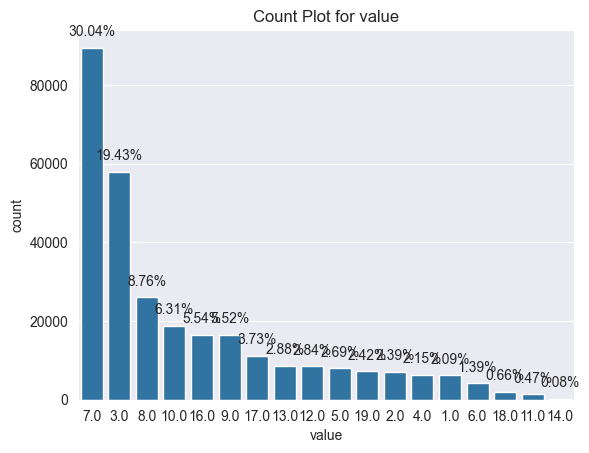

In [472]:
# lokking at the diag data we find two probloms
# 1. high number of fetuers,
# 2. uneven number of diag between patiants
# here we unite the diag based on the ICD-9-CM coding system into groups
# *each patiant can have more then one option

# df_categorical.reset_index()
# daig = df_categorical.reset_index().melt(id_vars='encounter_id', value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')




def change_value(value): 
    diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

    diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

    value = str(value).split('.')[0]
    try:
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan


diag = df.reset_index().melt(value_vars=['diag_1','diag_2','diag_3']).drop(columns='variable')
diag.value = diag.apply(lambda row: change_value(row.value), axis=1)
plot_categorical_with_percent(diag, 'value')
# diag = pd.get_dummies(diag, columns=['value'], prefix='daig_').groupby('encounter_id').sum()

# diag=diag>0
# diag.astype(int).sum(axis=0)/len(diag) *100

# df_with_diag = pd.concat([df_witout_bed_columns.set_index('encounter_id'), diag], axis=1)
# df_with_diag.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)


In [473]:
df.head()

patient_nbr             race  gender    age admission_type_id  \
0      8222157        Caucasian  Female    <30             Other   
1     55629189        Caucasian  Female    <30             HighP   
2     86047875  AfricanAmerican  Female    <30             HighP   
3     82442376        Caucasian    Male  30<60             HighP   
4     42519267        Caucasian    Male  30<60             HighP   

  discharge_disposition_id  admission_source_id  time_in_hospital  \
0                    Other                    1          1.000000   
1                     home                    7          1.732051   
2                     home                    7          1.414214   
3                     home                    7          1.414214   
4                     home                    7          1.000000   

  medical_specialty  num_lab_procedures  ...  biguanides_and_related  \
0             Other            6.403124  ...                       0   
1             Other            7.681146  ...                       0   
2             Other            3.316625  ...                       0   
3             Other            6.633250  ...                       0   
4             Other            7.141428  ...                       0   

   sulfonylureas_and_meglitinides  thiazolidinediones_and_miscellaneous  \
0                               0                                     0   
1                               0                                     0   
2                               1                                     0   
3                               0                                     0   
4                               1                                     0   

   number_diabetic_famalies  age_avg num_visits num_nonEm_visits  \
0                         0        5   0.000000         0.000000   
1                         0       15   0.000000         0.000000   
2                         1       25   2.414214         2.414214   
3                         0       35   0.000000         0.000000   
4                         1       45   0.000000         0.000000   

  num_lab_procedures_perDay  num_procedures_perDay num_medications_perDay  
0                  6.403124               0.000000               1.000000  
1                  4.434712               0.000000               2.449490  
2                  2.345208               1.581139               2.549510  
3                  4.690416               0.707107               2.828427  
4                  7.141428               0.000000               2.828427  

[5 rows x 35 columns]

In [474]:
# Assuming 'change_value' is a function that transforms the values based on the type
def change_value(value): 
    diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000), 18: 'E', 19:'V'}

    diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

    value = str(value).split('.')[0]
    try:
        return diag_dict[int(value)]
    except ValueError:
        try:
            return diag_dict[str(value[0]).upper()]
        except KeyError:
            return np.nan



def change_diag_to_type(row):
    diag_1 = change_value(row['diag_1'])
    diag_2 = change_value(row['diag_2'])
    diag_3 = change_value(row['diag_3'])  
    return pd.Series([diag_1, diag_2, diag_3], index=['diag_1', 'diag_2', 'diag_3'])

# Apply the function to each row and create new columns
df[['diag_1', 'diag_2', 'diag_3']] = df.apply(change_diag_to_type, axis=1)
# df.apply(change_diag_to_type, axis=1)

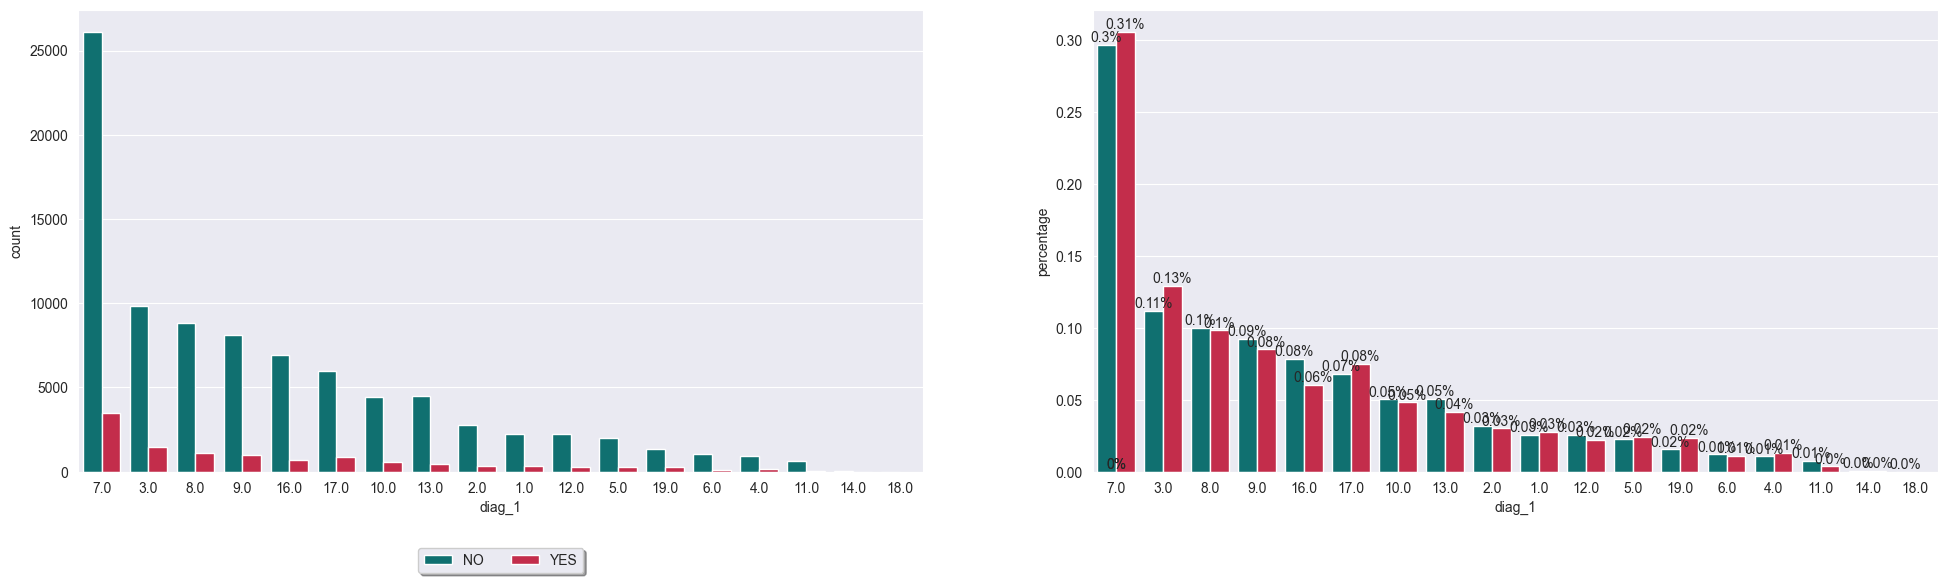

In [475]:
x = 'diag_1'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24,6))

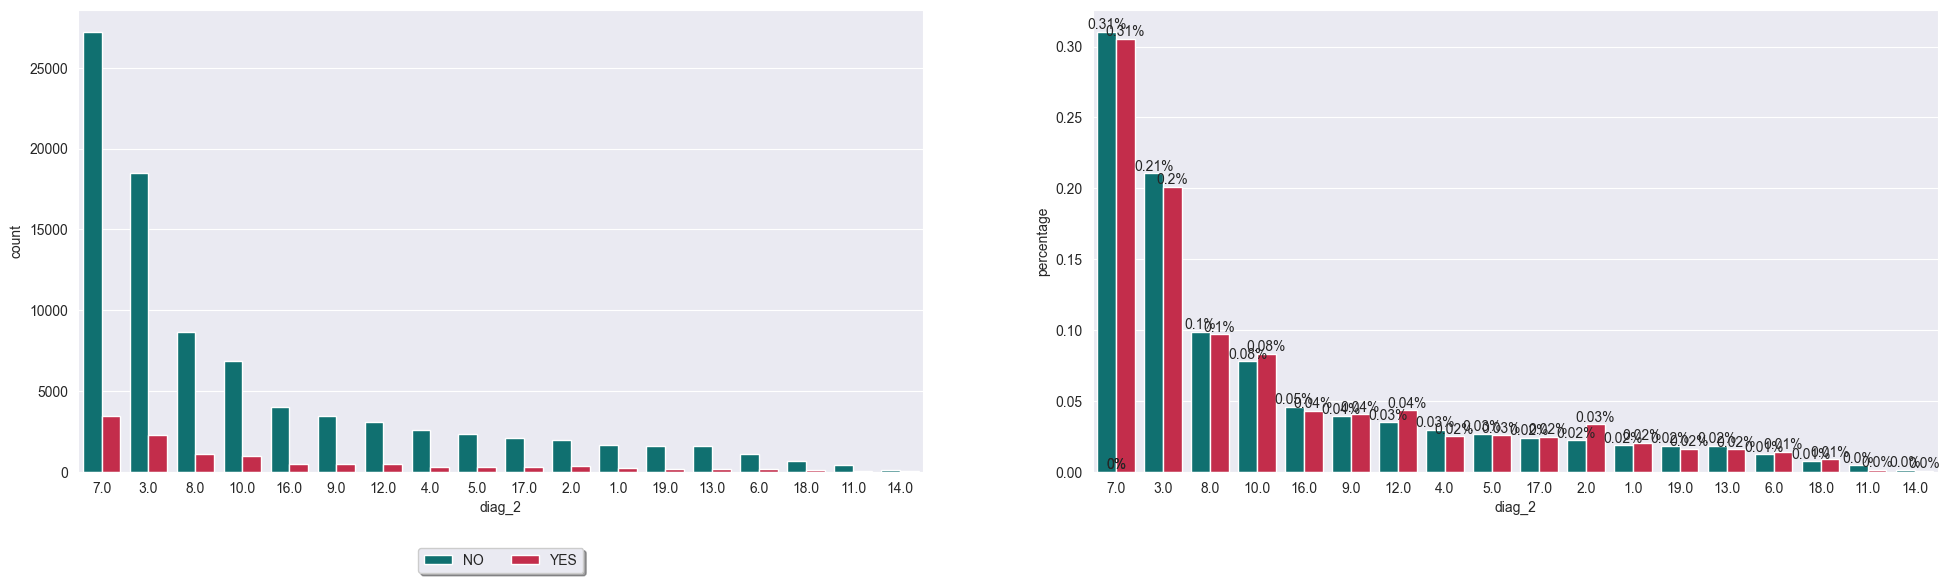

In [476]:
x = 'diag_2'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24,6))

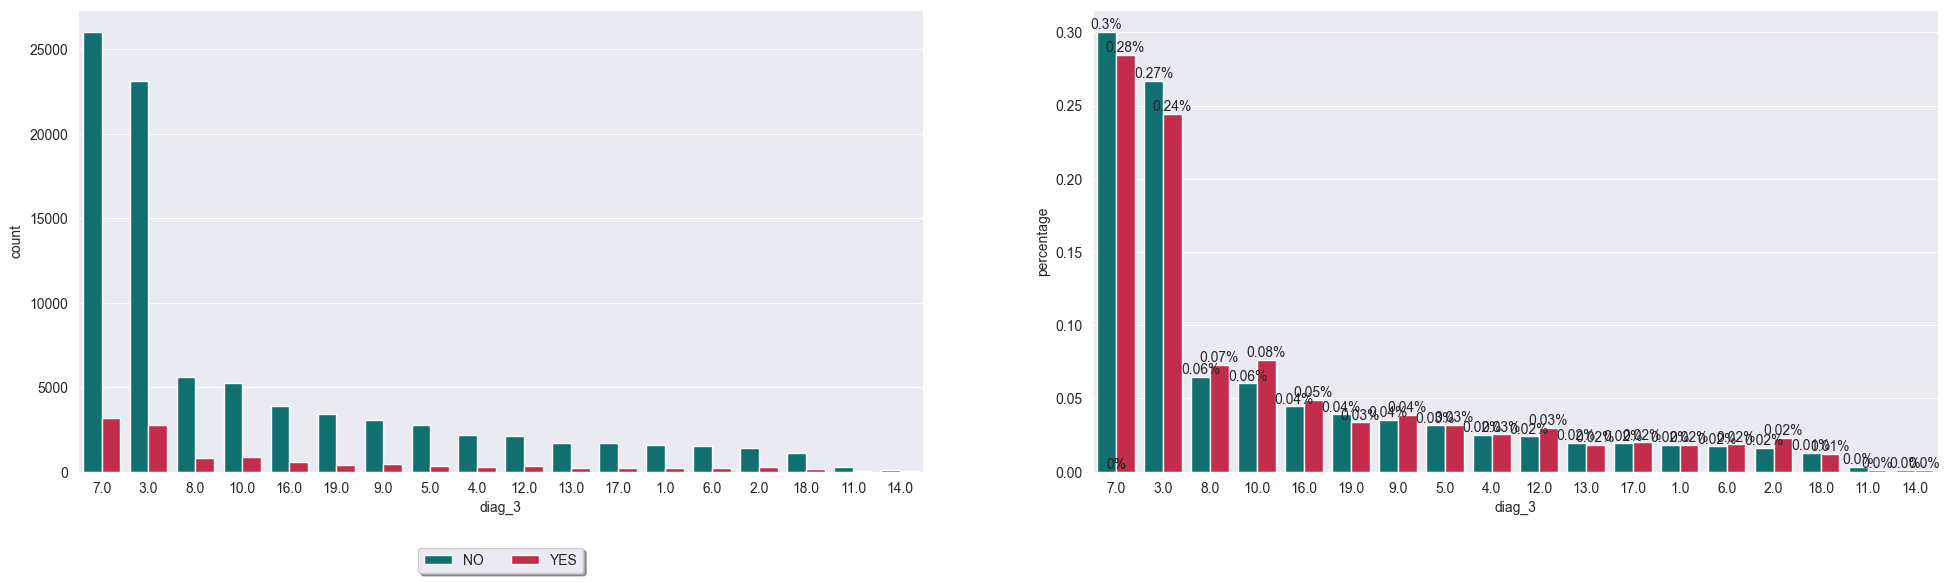

In [477]:
x = 'diag_3'
data = df
hue = 'readmitted'
palette = ["teal", "crimson"]

plot_dual_plot(x, data, hue, palette, figsize=(24,6))

# 6. Split test and validation 

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(result_df, test_size=0.2, random_state=42, stratify=result_df['readmitted'])

In [ ]:
plot_categorical_with_percent(test_set, column='readmitted')

In [ ]:
plot_categorical_with_percent(train_set, column='readmitted')

In [ ]:
train = train_set.drop("readmitted", axis=1) # drop labels for training set
train_labels = train_set["readmitted"].copy()

In [ ]:
cat_columns = df_categorical.drop(columns=['readmitted']).keys()

In [ ]:
df_categorical = df_categorical.drop(columns=['readmitted'])

In [ ]:
df_categorical.info()

In [591]:
import data

In [593]:
import config

In [594]:
data.load_data(config)

encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)    NaN   
1             149190     55629189        Caucasian  Female  [10-20)    NaN   
2              64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3             500364     82442376        Caucasian    Male  [30-40)    NaN   
4              16680     42519267        Caucasian    Male  [40-50)    NaN   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)    NaN   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)    NaN   
101763     443854148     41088789        Caucasian    Male  [70-80)    NaN   
101764     443857166     31693671        Caucasian  Female  [80-90)    NaN   
101765     443867222    175429310        Caucasian    Male  [70-80)    NaN   

        admission_type_id  discharge_disposition_id  admission_source_id  \
0                       6                        25                    1   
1                       1                         1                    7   
2                       1                         1                    7   
3                       1                         1                    7   
4                       1                         1                    7   
...                   ...                       ...                  ...   
101761                  1                         3                    7   
101762                  1                         4                    5   
101763                  1                         1                    7   
101764                  2                         3                    7   
101765                  1                         1                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                      1  ...          No      No                   No   
1                      3  ...          No      Up                   No   
2                      2  ...          No      No                   No   
3                      2  ...          No      Up                   No   
4                      1  ...          No  Steady                   No   
...                  ...  ...         ...     ...                  ...   
101761                 3  ...          No    Down                   No   
101762                 5  ...          No  Steady                   No   
101763                 1  ...          No    Down                   No   
101764                10  ...          No      Up                   No   
101765                 6  ...          No      No                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
0                        No                        No   
1                        No                        No   
2                        No                        No   
3                        No                        No   
4                        No                        No   
...                     ...                       ...   
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   
101765                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
0                            No                      No      No          No   
1                            No                      No      Ch         Yes   
2                            No                      No      No         Yes   
3                            No                      No      Ch         Yes   
4                            No                      No      Ch         Yes   
...                         ...                     ...     ...         ...   
101761                       No

In [596]:
data.build_data_prep_pipe(config)

TypeError: 'module' object is not subscriptable

In [597]:
df

patient_nbr             race  gender    age admission_type_id  \
0          8222157        Caucasian  Female    <30             Other   
1         55629189        Caucasian  Female    <30             HighP   
2         86047875  AfricanAmerican  Female    <30             HighP   
3         82442376        Caucasian    Male  30<60             HighP   
4         42519267        Caucasian    Male  30<60             HighP   
...            ...              ...     ...    ...               ...   
99335    100162476  AfricanAmerican    Male    >60             HighP   
99336     74694222  AfricanAmerican  Female    >60             HighP   
99337     41088789        Caucasian    Male    >60             HighP   
99338     31693671        Caucasian  Female    >60             HighP   
99339    175429310        Caucasian    Male    >60             HighP   

      discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        Other                    1                 1   
1                         home                    7                 3   
2                         home                    7                 2   
3                         home                    7                 2   
4                         home                    7                 1   
...                        ...                  ...               ...   
99335                    Other                    7                 3   
99336                    Other                    5                 5   
99337                     home                    7                 1   
99338                    Other                    7                10   
99339                     home                    7                 6   

      medical_specialty  num_lab_procedures  ...  \
0                 Other                  41  ...   
1                 Other                  59  ...   
2                 Other                  11  ...   
3                 Other                  44  ...   
4                 Other                  51  ...   
...                 ...                 ...  ...   
99335             Other                  51  ...   
99336             Other                  33  ...   
99337             Other                  53  ...   
99338   Surgery-General                  45  ...   
99339             Other                  13  ...   

       sulfonylureas_and_meglitinides  thiazolidinediones_and_miscellaneous  \
0                                   0                                     0   
1                                   0                                     0   
2                                   1                                     0   
3                                   0                                     0   
4                                   1                                     0   
...                               ...                                   ...   
99335                               0                                     0   
99336                               0                                     0   
99337                               0                                     0   
99338                               1                                     1   
99339                               0                                     0   

       number_diabetic_famalies  age_avg  encounter  num_visits  \
0                             0        5       None           0   
1                             0       15       None           0   
2                             1       25       None           3   
3                             0       35       None           0   
4                             1       45       None           0   
...                         ...      ...        ...         ...   
99335                         1       75       7_Ch           0   
99336                         0       85       None           1   
99337                         1       75       None           1   
99338                

In [28]:
group_features_lookup

{'biguanides_and_related': Index([], dtype='object'),
 'sulfonylureas_and_meglitinides': Index([], dtype='object'),
 'thiazolidinediones_and_miscellaneous': Index([], dtype='object'),
 'number_diabetic_drugs': ['biguanides_and_related',
  'sulfonylureas_and_meglitinides',
  'thiazolidinediones_and_miscellaneous']}

In [9]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from optuna import Trial, create_study
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline

diag_values = pd.unique(df[['diag_1', 'diag_2', 'diag_3']].melt().value)
diag_dict = {1: range(0,140), 2: range(140, 240), 3: range(240,280), 4: range(280,290), 5:range(290,320),
            6: range(320, 390), 7: range(390,460), 8: range(460, 520), 9: range(520, 580), 10: range(580,630),
            11: range(630, 680), 12: range(680,710), 13: range(710, 740), 14: range(740, 760), 15: range(760, 780),
            16: range(780, 800), 17: range(800, 1000),
             18: diag_values[['E' in str(value) for value in diag_values]],
             19: diag_values[['V' in str(value) for value in diag_values]]}

# diag_dict = {value: key for key, values_list in diag_dict.items() for value in values_list}

lookup_reduse = {
    'diag_1': diag_dict,
    'diag_2': diag_dict,
    'diag_3': diag_dict,
    
    'readmitted': {
        'YES': ['<30'],
        'NO': ['>30', 'NO']
    },
    'metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glyburide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glimepiride-pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'metformin-rosiglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'repaglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'nateglinide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'chlorpropamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glimepiride': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acetohexamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glipizide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glyburide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'tolbutamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'rosiglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'troglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'acarbose': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'miglitol': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'tolazamide': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'glipizide-metformin': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'metformin-pioglitazone': {
        0: ['No'],
        1: ['Steady', 'Up', 'Down']
    },
    'discharge_disposition_id': {
        'home': [1]
    },
    'admission_type_id': {
        'HighPriority': [1, 2],
        'ClinicReferral': [3, 4, 7]
    },
    'race': {
        'AfricanAmerican': ['AfricanAmerican'],
        'Caucasian': ['Caucasian']
    },
    'age': {
        '<30': ['[0-10)', '[10-20)', '[20-30)'],
        '30<60': ['[30-40)', '[40-50)', '[50-60)'],
        '>60': ['[60-70)', '[70-80)', '[80-90)', '[90-100)']
    },
    'medical_specialty': {
        "InternalMedicine": ['InternalMedicine'],
        'Emergency/Trauma': ['Emergency/Trauma'],
        'Family/GeneralPractice': ['Family/GeneralPractice'],
        'Cardiology': ['Cardiology'],
        'Surgery-General': ['Surgery-General'],
        'Nephrology': ['Nephrology'],
        'Orthopedics': ['Orthopedics']
    }
}

medical_spec_reduse = dt.CategoryGroupOthers({'medical_specialty': ['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
                              'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics']})

lookup_row_drop = {
    'discharge_disposition_id': [11, 13, 14, 19, 20, 21],
    'gender': ['Unknown/Invalid']
}

col_drop = ['weight', 'payer_code']



group_features_lookup = {
    "biguanides_and_related": ["metformin", "glyburide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone"],
    "sulfonylureas_and_meglitinides": ["repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide"],
    "thiazolidinediones_and_miscellaneous": ["pioglitazone", "rosiglitazone", "troglitazone", "acarbose", "miglitol", "tolazamide", "glipizide-metformin", "metformin-pioglitazone"],
    "number_diabetic_drugs": ["biguanides_and_related", "sulfonylureas_and_meglitinides", "thiazolidinediones_and_miscellaneous"]
}

numerical_columns = ['time_in_hospital',
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'biguanides_and_related',
                     'sulfonylureas_and_meglitinides',
                     'thiazolidinediones_and_miscellaneous',
                     'number_diabetic_drugs'
                    ]

columns_to_check_duplicates = ['patient_nbr']



# Define your custom transformers here


class ChangeValueToValue(BaseEstimator, TransformerMixin):
    def __init__(self, value_from: str | int , value_to: str | int, **kwargs) -> None:
        self.value_from = value_from
        self.value_to = value_to

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[X_copy == self.value_from] = self.value_to
        return X_copy

class NanToMissing(BaseEstimator, TransformerMixin):
    def __init__(self, missing_value="missing"):
        self.missing_value = missing_value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        # Replace the imputed value with "MISSING"
        X_copy[X_copy.isnull()] = self.missing_value
        return X_copy


class CategoryReducer(BaseEstimator, TransformerMixin):
    def __init__(self, lookup: dict[str, dict[str, list]], **kwargs):
        self.lookup = lookup

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for feature, feature_lookup in self.lookup.items():
            for change_to, change_from_list in feature_lookup.items():
                X_copy.loc[X_copy[feature].isin(change_from_list), feature] = change_to

            if 'other' not in feature_lookup.keys():
    
                X_copy.loc[~X_copy[feature].isin(feature_lookup.keys()), feature] = 'other'
        return X_copy


class DropRowsByValue(BaseEstimator, TransformerMixin):
    def __init__(self, lookup: dict[str, list], inplace=True, **kwargs):
        self.lookup = lookup
        self.inplace = inplace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for feature, value_to_drop in self.lookup.items():
            X_copy = X_copy[~X_copy[feature].isin(value_to_drop)]
        return X_copy


class DropColByValue(BaseEstimator, TransformerMixin):
    def __init__(self, lookup: list, inplace=True, **kwargs):
        self.lookup = lookup
        self.inplace = inplace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(columns=self.lookup, errors='ignore')
        return X_copy


class DropColWithLowVarious(BaseEstimator, TransformerMixin):
    def __init__(self, various_threshold: int = 100, inplace=True, **kwargs):
        self.various_threshold = various_threshold
        self.inplace = inplace

    def unique_values_and_ratio(self, X):
        unique_counts = X.nunique()
        most_common_ratios = ((X == X.mode().values).sum() / len(X)) * 100
        self.common_ratio_df = pd.DataFrame({"Unique Values": unique_counts, "Most Common Ratio": most_common_ratios})

    def fit(self, X, y=None):
        self.unique_values_and_ratio(X)
        self.columns_to_drop = self.common_ratio_df[self.common_ratio_df['Most Common Ratio'] >= self.various_threshold].index
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.drop(columns=self.columns_to_drop, errors='ignore')
        return X_copy




class GroupCategoriesUsinValues(BaseEstimator, TransformerMixin):

    def convert_to_float(self, df: pd.DataFrame) -> pd.DataFrame:
        for col in df.keys():
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                # If conversion to float raises an error, skip this column
                pass
        return df

    
    def __init__(self, lookup: dict[str, list], mode: str = 'sum', inplace=True, **kwargs):
        self.lookup = deepcopy(lookup)
        self.mode_str = mode
        self.mode = getattr(np, mode, np.sum)
        self.inplace = inplace

    def fit(self, X, y=None):
        for new_feature, old_features in self.lookup.items():
            X = self.convert_to_float(X)
            try:
                self.lookup[new_feature] = X[old_features].select_dtypes(include=np.number).columns
            except KeyError:
                pass 
        return self

    def transform(self, X):
        X_copy = X.copy()
        for new_feature, old_features in self.lookup.items():
     
            try:
                # Try calculating mode for all old_features
                X_copy[new_feature] = self.mode(X_copy[old_features], axis=1).astype(float)
            except KeyError as e:
                # Remove missing keys and recalculate mode
                missing_key = e.args[0]
                print(f'missing key:{missing_key}')
                old_features = [feature for feature in old_features if feature != missing_key]
                X_copy[new_feature] = self.mode(X_copy[old_features], axis=1).astype(float)
                
            # Drop all old_features (including any removed missing keys) this is on hold for now
            # X_copy = X_copy.drop(columns=old_features, errors='ignore')
        
        return X_copy





class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method='RobustScaler', numerical_columns=None, **kwargs):
        self.method = method
        self.numerical_columns = numerical_columns
        self.kwargs = kwargs
        self.scaler = None

    def fit(self, X, y=None):
        if self.method == 'RobustScaler':
            self.scaler = RobustScaler(**self.kwargs)
        elif self.method == 'StandardScaler':
            self.scaler = StandardScaler(**self.kwargs)
        elif self.method == 'NoTransform':
            self.scaler = NoTransform()
        else:
            raise ValueError("Unsupported method. Choose one of: 'RobustScaler', 'StandardScaler', or 'NoTransform'.")
        
        try:
            self.scaler.fit(X[self.numerical_columns])
        except KeyError as e:
            missing_column = str(e).strip('\'')
            try:
                self.numerical_columns.remove(missing_column)
            except ValueError:
                pass  # Column is already removed
            return self.fit(X)
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numerical_columns] = self.scaler.transform(X_copy[self.numerical_columns])
        return X_copy



class SkewFixTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=0.5, method='PowerTransformer', numerical_columns=None, **kwargs):
        self.skew_threshold = skew_threshold
        self.method = method
        self.numerical_columns = numerical_columns
        self.kwargs = kwargs
        self.skewed_columns = []
        self.transformer = None
        self.box_cox_addition = 0

    def fit(self, X, y=None):
        self.skewed_columns = []
        for col in self.numerical_columns:
            col_skew = skew(X[col].dropna())  # Calculate skewness
            if np.abs(col_skew) > self.skew_threshold:
                self.skewed_columns.append(col)
        
        if self.method == 'PowerTransformer':
            self.transformer = PowerTransformer(**self.kwargs)
        elif self.method == 'QuantileTransformer':
            self.transformer = QuantileTransformer(output_distribution='normal', **self.kwargs)
        elif self.method == 'LogTransformer':
            self.transformer = LogTransformer()
        elif self.method == 'BoxCoxTransformer':
            self.box_cox_addition = X[numerical_columns].min()
            self.transformer = PowerTransformer(method='box-cox')
        elif self.method == 'NoTransform':
            self.transformer = NoTransform()
        else:
            raise ValueError("Unsupported method. Choose one of: 'PowerTransformer', 'QuantileTransformer', 'LogTransformer', 'BoxCoxTransformer', or 'NoTransform'.")
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.skewed_columns:
            try:
                X_copy[col] = X_copy[col] - self.box_cox_addition[col] 
            except TypeError: 
                ""
            try:
                X_copy[col] = self.transformer.fit_transform(X_copy[col].values.reshape(-1, 1))
            except ValueError:
                X_copy[col] += 1
                X_copy[col] = self.transformer.fit_transform(X_copy[col].values.reshape(-1, 1))
        return X_copy



class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log1p(X)

class NoTransform(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X




from scipy.stats import rankdata

class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer='RankGaussTransformer', lower_quantile=0.05, upper_quantile=0.95):
        self.transformer_name = transformer
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.transformer = None

    def fit(self, X, y=None):
        # Get the numerical columns
        self.numerical_columns = X.select_dtypes(include=np.number).columns
        
        if self.transformer_name == 'RankGaussTransformer':
            self.transformer = RankGaussTransformer()
        elif self.transformer_name == 'Winsorizer':
            self.transformer = Winsorizer(lower_quantile=self.lower_quantile, upper_quantile=self.upper_quantile)
        elif self.transformer_name == 'NoTransform':
            self.transformer = NoTransform()
        else:
            raise ValueError("Unsupported transformer. Choose either 'RankGaussTransformer' or 'Winsorizer'.")
        
        # Fit only on numerical columns
        self.transformer.fit(X[self.numerical_columns])
        return self

    def transform(self, X):
        # Transform only the numerical columns
        X_transformed = X.copy()
        X_transformed[self.numerical_columns] = self.transformer.transform(X[self.numerical_columns])
        return X_transformed


class RankGaussTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_rank = np.apply_along_axis(rankdata, 0, X)
        X_rank /= X_rank.max()
        X_rank -= 0.5
        return np.arcsin(X_rank)

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.lower_bound = None
        self.upper_bound = None

    def fit(self, X, y=None):
        self.lower_bound = np.quantile(X, self.lower_quantile, axis=0)
        self.upper_bound = np.quantile(X, self.upper_quantile, axis=0)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for i in range(X_copy.shape[1]):
            X_copy.iloc[:, i] = np.where(X_copy.iloc[:, i] < self.lower_bound[i], self.lower_bound[i], X_copy.iloc[:, i])
            X_copy.iloc[:, i] = np.where(X_copy.iloc[:, i] > self.upper_bound[i], self.upper_bound[i], X_copy.iloc[:, i])
        return X_copy




class ObjectToCategoryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in X_transformed.columns:
            if X_transformed[col].dtype == 'object' or '_ID' in col.upper() or 'DIAG_' in col.upper():
                X_transformed[col] = X_transformed[col].astype('str')
                X_transformed[col] = X_transformed[col].astype('category')
        return X_transformed

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.base import BaseEstimator, TransformerMixin


# ___________________________________________________________________________________________________________________

class DropDuplicatesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_check_duplicates=None, keep='first'):
        self.columns_to_check_duplicates = columns_to_check_duplicates
        self.keep = keep
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.columns_to_check_duplicates is None:
            return X
        X_transformed = X.copy()
        X_transformed = X_transformed.drop_duplicates(subset=self.columns_to_check_duplicates, keep=self.keep)
        return X_transformed



def instantiate_DropDuplicatesTransformer(trial: optuna.Trial) -> DropDuplicatesTransformer:
    drop_duplicates = trial.suggest_categorical('drop_duplicates', [True])
    if drop_duplicates:
        keep = trial.suggest_categorical('keep', ['first'])
        columns_to_check_duplicates = ['patient_nbr']
    else:
        keep = 'first'
        columns_to_check_duplicates = None
    return DropDuplicatesTransformer(columns_to_check_duplicates=columns_to_check_duplicates, keep=keep)

# ____________________________________________________________________________________________________________________


class DropRowsByValue(BaseEstimator, TransformerMixin):
    def __init__(self, lookup: dict[str, list], inplace=True, **kwargs):
        self.lookup = lookup
        self.inplace = inplace

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for feature, value_to_drop in self.lookup.items():
            X_copy = X_copy[~X_copy[feature].isin(value_to_drop)]
        return X_copy


# ______________________________________________________________________________________________________________________

def instantiate_TransformerLookup(trial: optuna.Trial, lookup, transformer, must_True_coloumns=['readmitted'], **kwargs):
# select whether to drop each category specified in the lookup dictionary. 
    # Choose one or more categories to drop from the lookup values
    if type(lookup) == dict:
        categories_to_drop = []
        values_to_drop = []
        for key, values in lookup.items():
            if  (trial.suggest_categorical(f'TransformerLookup_{str(transformer)}_{str(key)}', [True, False]) | (key in must_True_coloumns)):
                categories_to_drop.append(key)
                values_to_drop.append(values)
        new_lookup = {category: values_to_drop[index] for index, category in enumerate(categories_to_drop)}
    
    elif type(lookup) == list:
        new_lookup = []
        for value in lookup:
            if trial.suggest_categorical(f'TransformerLookup_{str(transformer)}_{str(value)}', [True, False]):
                new_lookup.append(value)
    
    # Create the DropRowsByValue transformer instance
    return transformer(lookup=new_lookup, **kwargs)
# _____________________________________________



def instantiate_DropColWithLowVarious(trial: optuna.Trial) -> DropColWithLowVarious:
    various_threshold = trial.suggest_int('various_threshold', 99, 100)
    return DropColWithLowVarious(various_threshold=various_threshold)

def instantiate_GroupCategoriesUsinValues(trial: optuna.Trial, lookup=group_features_lookup) -> GroupCategoriesUsinValues:
    # Define your group features lookup here or pass it as an argument
    mode = trial.suggest_categorical('mode', ['sum', 'mean', 'median'])  # Choose mode
    return GroupCategoriesUsinValues(lookup=lookup, mode=mode)

def instantiate_SkewFixTransformer(trial: optuna.Trial, numerical_columns=numerical_columns) -> SkewFixTransformer:
    new_lookup = []
    for value in numerical_columns:
        if trial.suggest_categorical(f'skefix_{str(value)}', [True, False]):
            new_lookup.append(value)

    skew_threshold = trial.suggest_float('skew_threshold', -3.0, 3.0)
    method_type = trial.suggest_categorical('method', ['PowerTransformer', 'QuantileTransformer', 'LogTransformer', 'BoxCoxTransformer', 'NoTransform'])
    return SkewFixTransformer(skew_threshold=skew_threshold, method=method_type, numerical_columns=new_lookup)

def instantiate_ScalerTransformer(trial: optuna.Trial, numerical_columns=numerical_columns) -> ScalerTransformer:
    new_lookup = []
    for value in numerical_columns:
        if trial.suggest_categorical(f'ScalerTransforme_{str(value)}', [True, False]):
            new_lookup.append(value)

    method_choices = ['RobustScaler', 'StandardScaler', 'NoTransform']
    method_type = trial.suggest_categorical('method_type', method_choices)
        
    return ScalerTransformer(method=method_type, numerical_columns=new_lookup)

def instantiate_OutlierTransformer(trial: optuna.Trial) -> OutlierTransformer:
    transformer = trial.suggest_categorical('transformer', ['RankGaussTransformer', 'Winsorizer', 'NoTransform'])
    lower_quantile = trial.suggest_float('lower_quantile', 0, 0.5)
    upper_quantile = trial.suggest_float('upper_quantile', 0.5, 1)
    return OutlierTransformer(transformer=transformer, lower_quantile=lower_quantile, upper_quantile=upper_quantile)


    

# # Define your pipeline
# pipeline = Pipeline([
#     ('?_to_missing', ChangeValueToValue('?', 'missing')),
#     ('nan_to_missing', NanToMissing()),
#     ('dropduplications', DropDuplicatesTransformer(columns_to_check_duplicates=columns_to_check_duplicates, keep='first')),
#     ('droprowbyvalues', DropRowsByValue(lookup=lookup_row_drop)),
#     ('categoryreducer', CategoryReducer(lookup=lookup_reduse)),
#     ('dropcolbyvalue', DropColByValue(lookup=col_drop)),
#     ('drop_high_various', DropColWithLowVarious(various_threshold=100)),
#     ('group_features_lookup', GroupCategoriesUsinValues(lookup=group_features_lookup, mode='sum')),
#     ('skew_fix', SkewFixTransformer(skew_threshold=0.5, method='PowerTransformer', numerical_columns=numerical_columns)),
#     ('scaler', ScalerTransformer(method='RobustScaler', numerical_columns=numerical_columns)),
#     ('outlier_transformer', OutlierTransformer(transformer='Winsorizer', lower_quantile=0.05, upper_quantile=0.95)),
#     ('object_to_catagory', ObjectToCategoryTransformer()),
    
# ])

# # Fit and transform your DataFrame
# transformed_df = pipeline.fit_transform(df)
# transformed_df


In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier, Pool

def balancer(trial, X_train, y_train):

    # Choose a balancing method
    balance_method = trial.suggest_categorical('balance_method', ['none', 'oversample', 'undersample', 'smote', 'adasyn', 'class_weight'])

    if balance_method == 'none':
        # No balancing
        X_train_balanced, y_train_balanced = X_train, y_train
    elif balance_method == 'oversample':
        # Oversample the minority class by duplicating samples
        over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
        X_train_balanced, y_train_balanced = over_sampler.fit_resample(X_train, y_train)
    elif balance_method == 'undersample':
        # Undersample the majority class
        under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
        X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train, y_train)
    elif balance_method == 'smote':
        # Use SMOTE to generate synthetic samples
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    elif balance_method == 'adasyn':
        # Use ADASYN to generate synthetic samples
        adasyn = ADASYN(sampling_strategy='auto', random_state=42)
        X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)
    elif balance_method == 'class_weight':
        # Use class weighting in the classifier
        class_weight = 'Balanced'
        X_train_balanced, y_train_balanced = X_train, y_train
    else:
        raise ValueError("Unsupported balance method")

    return X_train_balanced, y_train_balanced

    # CatBoost parameters
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'eval_metric': 'F1',
        'logging_level': 'Silent',
        'random_seed': 42
    }

    if balance_method == 'class_weight':
        params['class_weights'] = [0.1, 0.9]

    # Train the classifier
    train_pool = Pool(X_train_balanced, y_train_balanced)
    test_pool = Pool(X_test, y_test)
    model = CatBoostClassifier(**params)
    model.fit(train_pool)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1

# Optimize the objective function
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print("Best trial:")
# trial = study.best_trial
# print("  F1-Score: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))


In [8]:
def balancer(trial, X_train, y_train, random_state=42):

    # Choose a balancing method
    balance_method = trial.suggest_categorical('balance_method', ['oversample', 'undersample', 'smote', 'adasyn', 'class_weight'])
   
    if balance_method == 'oversample':
        # Oversample the minority class by duplicating samples
        over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = over_sampler.fit_resample(X_train, y_train)
    elif balance_method == 'undersample':
        # Undersample the majority class
        under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train, y_train)
    elif balance_method == 'smote':
        # Use SMOTE to generate synthetic samples
        smote = SMOTE(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    elif balance_method == 'adasyn':
        # Use ADASYN to generate synthetic samples
        adasyn = ADASYN(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)
    else:
        raise ValueError("Unsupported balance method")

    return X_train_balanced, y_train_balanced

In [10]:
import pandas as pd
import optuna
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sdv.single_table import TVAESynthesizer as TVAE
from sdv.single_table import CTGANSynthesizer as CTGAN
from gretel_synthetics.config import LocalConfig
from gretel_synthetics.train import train_rnn
from gretel_synthetics.generate import generate_text


def balancer(trial, X_train, y_train, random_state=42):

    def generate_and_concatenate_synthetic_data(model, X_train, y_train):
        data = X_train.copy()
        data['target'] = y_train
        model.fit(data)
        synthetic_data = model.sample(len(data))
        return synthetic_data

    def separate_and_concatenate_synthetic_data(synthetic_data, X_train, y_train):
        X_synth = synthetic_data.drop(columns=['target'])
        y_synth = synthetic_data['target']
        X_train_balanced = pd.concat([X_train, X_synth])
        y_train_balanced = pd.concat([y_train, y_synth])
        return X_train_balanced, y_train_balanced

    balance_method = trial.suggest_categorical('balance_method', [
        'oversample', 'undersample', 'smote', 'adasyn', 'ctgan', 'tvae', 'gretel', 'ydata_synth'
    ])

    if balance_method == 'oversample':
        over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = over_sampler.fit_resample(X_train, y_train)

    elif balance_method == 'undersample':
        under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train, y_train)

    elif balance_method == 'smote':
        smote = SMOTE(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    elif balance_method == 'adasyn':
        adasyn = ADASYN(sampling_strategy='auto', random_state=random_state)
        X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

    elif balance_method == 'ctgan':
        model = CTGAN()
        synthetic_data = generate_and_concatenate_synthetic_data(model, X_train, y_train)
        X_train_balanced, y_train_balanced = separate_and_concatenate_synthetic_data(synthetic_data, X_train, y_train)

    elif balance_method == 'tvae':
        model = TVAE()
        synthetic_data = generate_and_concatenate_synthetic_data(model, X_train, y_train)
        X_train_balanced, y_train_balanced = separate_and_concatenate_synthetic_data(synthetic_data, X_train, y_train)

    elif balance_method == 'gretel':
        # Configuration for Gretel
        config = LocalConfig(
            output_dir='.',
            epochs=500,
            batch_size=128,
            learning_rate=0.001,
            latent_size=100,
            dataloader_workers=1
        )
        # Prepare the training data
        train_data = pd.concat([X_train, y_train], axis=1)
        # Train the model
        model = train_rnn(config, training_data=train_data)
        # Generate synthetic data
        synthetic_data = generate_text(model, num_lines=len(train_data))
        synthetic_data = pd.DataFrame(synthetic_data, columns=train_data.columns)
        X_train_balanced, y_train_balanced = separate_and_concatenate_synthetic_data(synthetic_data, X_train, y_train)

    else:
        raise ValueError("Unsupported balance method")

    return X_train_balanced, y_train_balanced


In [ ]:

def instantiate_data(trial: Trial, lookup_row_drop: dict[str, list] = lookup_row_drop, lookup_reduse=lookup_reduse, col_drop=col_drop, group_features_lookup=group_features_lookup, numerical_columns=numerical_columns) -> Pipeline:
    pipeline = Pipeline([
        ('?_to_missing', ChangeValueToValue('?', 'missing')),
        ('nan_to_missing', NanToMissing()),
        ('drop_duplications', instantiate_DropDuplicatesTransformer(trial)),
        ('droprowbyvalues', instantiate_TransformerLookup(trial, lookup=lookup_row_drop, transformer=DropRowsByValue)),
        ('categoryreducer', instantiate_TransformerLookup(trial, lookup=lookup_reduse, transformer=CategoryReducer)),
        ('dropcolbyvalue', instantiate_TransformerLookup(trial, lookup=col_drop, transformer=DropColByValue)),
        ('drop_low_various', instantiate_DropColWithLowVarious(trial)),
        ('group_features_lookup', instantiate_GroupCategoriesUsinValues(trial, lookup=group_features_lookup)), 
        ('skew_fix', instantiate_SkewFixTransformer(trial, numerical_columns=numerical_columns)),
        ('scaler', instantiate_ScalerTransformer(trial, numerical_columns=numerical_columns)),
        ('outlier_transformer', instantiate_OutlierTransformer(trial)),
        ('object_to_catagory', ObjectToCategoryTransformer()),   
    ])
    return pipeline


# 

def instantiate_catboost_classifier(trial: optuna.Trial, X, verbose=False, random_state : int=42, model_weight=False, **kwargs) -> CatBoostClassifier:
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 100.0),
        'iterations': trial.suggest_int('iterations', 100, 1000),   
    }
    params[ 'early_stopping_rounds'] = trial.suggest_int('early_stopping_rounds', 0, params['iterations'])

    if model_weight:
        imbalance_method = trial.suggest_categorical('imbalance_method', ['scale_pos_weight', 'class_weights', 'auto_class_weights'])

        # Set the appropriate parameter based on the chosen method
        if imbalance_method == 'scale_pos_weight':
            params['scale_pos_weight'] = trial.suggest_float('scale_pos_weight', 1, 100.0)
        elif imbalance_method == 'class_weights':
            #  binary classification for simplicity; adjust as needed for multiclass
            weight_class_0 = trial.suggest_float('weight_class_0', 0.1, 10.0)
            weight_class_1 = trial.suggest_float('weight_class_1', 0.1, 10.0)
            params['class_weights'] = [weight_class_0, weight_class_1]
        elif imbalance_method == 'auto_class_weights':
            params['auto_class_weights'] = 'Balanced'
    
    # Suggest value for early stopping rounds
    params['early_stopping_rounds'] = trial.suggest_int('early_stopping_rounds', 0, params['iterations'])
    
    # Identify categorical features

    cat_indices = X.select_dtypes(include=['category', 'object']).columns.tolist()
    return CatBoostClassifier(cat_features=cat_indices,  verbose=verbose, random_state=random_state, **params, **kwargs)




from typing import Optional
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, make_scorer
from pandas import DataFrame, Series
import numpy as np

def objective(trial : Trial, X : DataFrame, random_state : int=42, verbose=False) -> float:
    # Preprosess 
    preprocessor = instantiate_data(trial)
    X = preprocessor.fit_transform(X)

    # random drop features
    
    drop = trial.suggest_categorical(f'random_drop', [True, False])
    if drop:
        random_drop = instantiate_TransformerLookup(trial, lookup=list(X.drop(columns=['readmitted']).keys()), transformer=DropColByValue)
        X = random_drop.transform(X)

    
    # print(X.info())
    # print(X.head())
    
    y = X['readmitted']
    X = X.drop(columns=['readmitted'])


    # Balance data
    balance = trial.suggest_categorical(f'random_drop', [True, False])
    model_weight = trial.suggest_categorical(f'random_drop', [True, False])
    if balance:   
        if not model_weight:
            X, y = balancer(trial=trial, X_train=X, y_train=y, random_state=random_state)
        
    model = instantiate_catboost_classifier(trial, verbose=verbose, X=X, random_state=random_state, model_weight=model_weight)
    
    
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
    scores = cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=kf)
    
    return np.min([np.mean(scores), np.median([scores])])
    


X = df
# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


from optuna import create_study

study = create_study(study_name='optimization', direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, verbose=True), n_trials=2, show_progress_bar=True, n_jobs=1)

[I 2024-05-20 14:40:40,606] A new study created in memory with name: optimization


  0%|          | 0/2 [00:00<?, ?it/s]

0:	learn: 0.6772057	total: 291ms	remaining: 4m 6s
1:	learn: 0.6688778	total: 351ms	remaining: 2m 28s
2:	learn: 0.6641751	total: 639ms	remaining: 2m 59s
3:	learn: 0.6617609	total: 834ms	remaining: 2m 55s
4:	learn: 0.6582656	total: 1.09s	remaining: 3m 4s
5:	learn: 0.6570410	total: 1.18s	remaining: 2m 45s
6:	learn: 0.6556089	total: 1.4s	remaining: 2m 47s
7:	learn: 0.6555854	total: 1.44s	remaining: 2m 31s
8:	learn: 0.6536410	total: 1.81s	remaining: 2m 48s
9:	learn: 0.6530149	total: 1.94s	remaining: 2m 42s
10:	learn: 0.6506008	total: 2.24s	remaining: 2m 50s
11:	learn: 0.6496379	total: 2.42s	remaining: 2m 48s
12:	learn: 0.6495548	total: 2.52s	remaining: 2m 41s
13:	learn: 0.6488946	total: 2.79s	remaining: 2m 46s
14:	learn: 0.6477135	total: 3.01s	remaining: 2m 46s
15:	learn: 0.6474628	total: 3.1s	remaining: 2m 40s
16:	learn: 0.6464366	total: 3.43s	remaining: 2m 47s
17:	learn: 0.6433299	total: 3.76s	remaining: 2m 53s
18:	learn: 0.6430085	total: 3.95s	remaining: 2m 52s
19:	learn: 0.6422990	total

In [38]:
X_copy[X_copy == self.value_from] = self.value_to

NameError: name 'self' is not defined

In [42]:
df

patient_nbr             race  gender      age weight  \
encounter_id                                                         
2278392           8222157        Caucasian  Female   [0-10)      ?   
149190           55629189        Caucasian  Female  [10-20)      ?   
64410            86047875  AfricanAmerican  Female  [20-30)      ?   
500364           82442376        Caucasian    Male  [30-40)      ?   
16680            42519267        Caucasian    Male  [40-50)      ?   
...                   ...              ...     ...      ...    ...   
443847548       100162476  AfricanAmerican    Male  [70-80)      ?   
443847782        74694222  AfricanAmerican  Female  [80-90)      ?   
443854148        41088789        Caucasian    Male  [70-80)      ?   
443857166        31693671        Caucasian  Female  [80-90)      ?   
443867222       175429310        Caucasian    Male  [70-80)      ?   

              admission_type_id  discharge_disposition_id  \
encounter_id                                                
2278392                       6                        25   
149190                        1                         1   
64410                         1                         1   
500364                        1                         1   
16680                         1                         1   
...                         ...                       ...   
443847548                     1                         3   
443847782                     1                         4   
443854148                     1                         1   
443857166                     2                         3   
443867222                     1                         1   

              admission_source_id  time_in_hospital payer_code  ...  \
encounter_id                                                    ...   
2278392                         1                 1          ?  ...   
149190                          7                 3          ?  ...   
64410                           7                 2          ?  ...   
500364                          7                 2          ?  ...   
16680                           7                 1          ?  ...   
...                           ...               ...        ...  ...   
443847548                       7                 3         MC  ...   
443847782                       5                 5         MC  ...   
443854148                       7                 1         MC  ...   
443857166                       7                10         MC  ...   
443867222                       7                 6          ?  ...   

             citoglipton  insulin  glyburide-metformin  glipizide-metformin  \
encounter_id                                                                  
2278392               No       No                   No                   No   
149190                No       Up                   No                   No   
64410                 No       No                   No                   No   
500364                No       Up                   No                   No   
16680                 No   Steady                   No                   No   
...                  ...      ...                  ...                  ...   
443847548             No     Down                   No                   No   
443847782             No   Steady                   No                   No   
443854148             No     Down                   No                   No   
443857166             No       Up                   No                   No   
443867222             No       No                   No                   No   

              glimepiride-pioglitazone  metformin-rosiglitazone  \
encounter_id                                                      
2278392                             No                       No   
149190                              No                       No   
64410                               No                       No   
500364                

In [43]:
df[df==0]

patient_nbr race gender  age weight  admission_type_id  \
encounter_id                                                           
2278392               NaN  NaN    NaN  NaN    NaN                NaN   
149190                NaN  NaN    NaN  NaN    NaN                NaN   
64410                 NaN  NaN    NaN  NaN    NaN                NaN   
500364                NaN  NaN    NaN  NaN    NaN                NaN   
16680                 NaN  NaN    NaN  NaN    NaN                NaN   
...                   ...  ...    ...  ...    ...                ...   
443847548             NaN  NaN    NaN  NaN    NaN                NaN   
443847782             NaN  NaN    NaN  NaN    NaN                NaN   
443854148             NaN  NaN    NaN  NaN    NaN                NaN   
443857166             NaN  NaN    NaN  NaN    NaN                NaN   
443867222             NaN  NaN    NaN  NaN    NaN                NaN   

              discharge_disposition_id  admission_source_id  time_in_hospital  \
encounter_id                                                                    
2278392                            NaN                  NaN               NaN   
149190                             NaN                  NaN               NaN   
64410                              NaN                  NaN               NaN   
500364                             NaN                  NaN               NaN   
16680                              NaN                  NaN               NaN   
...                                ...                  ...               ...   
443847548                          NaN                  NaN               NaN   
443847782                          NaN                  NaN               NaN   
443854148                          NaN                  NaN               NaN   
443857166                          NaN                  NaN               NaN   
443867222                          NaN                  NaN               NaN   

             payer_code  ... citoglipton  insulin  glyburide-metformin  \
encounter_id             ...                                             
2278392             NaN  ...         NaN      NaN                  NaN   
149190              NaN  ...         NaN      NaN                  NaN   
64410               NaN  ...         NaN      NaN                  NaN   
500364              NaN  ...         NaN      NaN                  NaN   
16680               NaN  ...         NaN      NaN                  NaN   
...                 ...  ...         ...      ...                  ...   
443847548           NaN  ...         NaN      NaN                  NaN   
443847782           NaN  ...         NaN      NaN                  NaN   
443854148           NaN  ...         NaN      NaN                  NaN   
443857166           NaN  ...         NaN      NaN                  NaN   
443867222           NaN  ...         NaN      NaN                  NaN   

              glipizide-metformin  glimepiride-pioglitazone  \
encounter_id                                                  
2278392                       NaN                       NaN   
149190                        NaN                       NaN   
64410                         NaN                       NaN   
500364                        NaN                       NaN   
16680                         NaN                       NaN   
...                           ...                       ...   
443847548                     NaN                       NaN   
443847782                     NaN                       NaN   
443854148                     NaN                       NaN   
443857166                     NaN                       NaN   
443867222                     NaN                       NaN   

              metformin-rosiglitazone  metformin-pioglitazone change  \
encounter_id                                                           
2278392                           NaN                     NaN    NaN   
149190                  

In [18]:
X.keys()

Index(['patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [17]:
X['readmitted']

encounter_id
2278392       NO
149190       >30
64410         NO
500364        NO
16680         NO
            ... 
443847548    >30
443847782     NO
443854148     NO
443857166     NO
443867222     NO
Name: readmitted, Length: 101766, dtype: object

In [12]:
import pickle

# Save the full study object
with open("study_50_t.pkl", "wb") as f:
    pickle.dump(study, f)

In [13]:
df['admission_type_id'] - 0

encounter_id
2278392      6
149190       1
64410        1
500364       1
16680        1
            ..
443847548    1
443847782    1
443854148    1
443857166    2
443867222    1
Name: admission_type_id, Length: 101766, dtype: int64

In [56]:
pd.unique(df['readmitted'])

array(['NO', '>30', '<30'], dtype=object)

In [623]:
study.best_params

{'drop_duplicates': True,
 'keep': 'first',
 "TransformerLookup_<class '__main__.DropRowsByValue'>_discharge_disposition_id": False,
 "TransformerLookup_<class '__main__.DropRowsByValue'>_gender": False,
 "TransformerLookup_<class '__main__.CategoryReducer'>_diag_1": False,
 "TransformerLookup_<class '__main__.CategoryReducer'>_diag_2": False,
 "TransformerLookup_<class '__main__.CategoryReducer'>_diag_3": True,
 "TransformerLookup_<class '__main__.CategoryReducer'>_metformin": True,
 "TransformerLookup_<class '__main__.CategoryReducer'>_glyburide-metformin": False,
 "TransformerLookup_<class '__main__.CategoryReducer'>_glimepiride-pioglitazone": True,
 "TransformerLookup_<class '__main__.CategoryReducer'>_metformin-rosiglitazone": False,
 "TransformerLookup_<class '__main__.CategoryReducer'>_repaglinide": False,
 "TransformerLookup_<class '__main__.CategoryReducer'>_nateglinide": False,
 "TransformerLookup_<class '__main__.CategoryReducer'>_chlorpropamide": False,
 "TransformerLookup_

In [625]:
study.best_value

0.6347598405916386